In [2]:
from __future__ import division
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import time, os, math, warnings
from matplotlib import pyplot

import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, TimeDistributed, Reshape
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.utils import plot_model

Using TensorFlow backend.


In [1]:
# Set up some global variables
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /device:GPU:0


### Pre-processing Functions

In [0]:
def create_timeblock(X, Y, look_back=1):
    dataX, dataY = [], []
    for i in range(len(X) - look_back):
        a = X[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(Y[i + look_back, :])
    print('# of data: ', len(dataY))
    return np.array(dataX), np.array(dataY)

### Plotting Functions

In [38]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def load_data(filename):
    """
    This function reads csv file from the given url and extracts time-series data of oil & water rate,
    pressure, and water cut.
    :param filename: the url of csv file (stored in GitHub)
    :return: t: vector of time; qo: matrix of oil rate in all wells; qo: matrix of water rate in all wells;
            and p: matrix of bottom hole pressure in all wells
    """
    df = pd.read_csv(filename)

    t = df.loc[:, ['TIME']] # Time in simulation: DAY
    t *= 24 # Converting time from DAY to HOUR
    qo = df.loc[:, ['WOPR:P1', 'WOPR:P2', 'WOPR:P3']]
    qw = df.loc[:, ['WWPR:P1', 'WWPR:P2', 'WWPR:P3']]
    p = df.loc[:, ['WBHP:P1', 'WBHP:P2', 'WBHP:P3']]
    wc = df.loc[:, ['WWCT:P1', 'WWCT:P2', 'WWCT:P3']]
    return t, qo, qw, wc, p

def plot_pressure(t, q_actual, q_pred, dev_fraction, test_fraction, well):
    """This function plots actual and predicted bottom hole pressure"""
    # Plotting pwf v time
    plt.figure()
    plt.plot(t, q_actual, 'k-', linewidth=3, label='Actual oil rate')

    # Training
    train_end = int((1 - dev_fraction - test_fraction) * q_pred.shape[0])
    plt.plot(t[0:train_end], q_pred[0:train_end],
                 'r-', markeredgecolor='red', label='Training Set', linewidth=3)
    
    # Dev
    dev_end = int((1 - test_fraction) * q_pred.shape[0])
    plt.plot(t[train_end:dev_end], q_pred[train_end:dev_end],
                 'y-', markeredgecolor='orange', label='Dev Set', linewidth=3)
    
    # Test
    plt.plot(t[dev_end:], q_pred[dev_end:],
                 'g-', markeredgecolor='green', label='Test Set', linewidth=3)    
    
    plt.xlabel("Time (hours)", fontsize=14)
    plt.ylabel("Bottom Hole Pressure (psi)", fontsize=14)
    plt.title("Bottom Hole Pressure Well "+str(well), y=1, fontsize=13)
    plt.legend(loc="best", prop=dict(size=14))
    plt.xlim(0, max(t))
    plt.ylim(0, max(max(q_actual), max(q_pred)) + 10)
    plt.grid(True)

def plot_pred_rate(t, q_actual, q_pred, dev_fraction, test_fraction, well):
    """This function plots actual and predicted bottom hole pressure"""
    # Plotting pwf v time
    plt.figure()
    plt.plot(t, q_actual, 'k-', linewidth=3, label='Actual oil rate')

    # Training
    train_end = int((1 - dev_fraction - test_fraction) * q_pred.shape[0])
    plt.plot(t[0:train_end], q_pred[0:train_end],
                 'r-', markeredgecolor='red', label='Training Set', linewidth=3)
    
    # Dev
    dev_end = int((1 - test_fraction) * q_pred.shape[0])
    plt.plot(t[train_end:dev_end], q_pred[train_end:dev_end],
                 'y-', markeredgecolor='orange', label='Dev Set', linewidth=3)
    
    # Test
    plt.plot(t[dev_end:], q_pred[dev_end:],
                 'g-', markeredgecolor='green', label='Test Set', linewidth=3)    
    
    plt.xlabel("Time (hours)", fontsize=14)
    plt.ylabel("Flow Rate (STB/d)", fontsize=14)
    plt.title("Flow Rate Well " +str(well), y=1, fontsize=13)
    plt.legend(loc="best", prop=dict(size=14))
    plt.xlim(0, max(t))
    plt.ylim(0, max(max(q_actual), max(q_pred)) + 10)
    plt.grid(True)

def plot_rates(t, q, wellname, color, label):
    """This function plots actual flow rates"""
    # Plotting Flow Rate v time
    plt.plot(t, q, color, linewidth=3, label=label)
    plt.xlabel("Time (hours)", fontsize=11)
    plt.ylabel("Flow Rate (STB/D)", fontsize=11)
    plt.title('Flow Rate Well ' + wellname, y=0.82, fontsize=9)
    plt.legend(loc=1, prop=dict(size=8))
    plt.xlim(0, max(t))
    plt.ylim(0, max(q) + 10)
    plt.grid(True)

def plot_pressure_rates(x, y, y_pred, labelname):
    """This function plots both pressure and actual flow rates"""
    plt.figure()
    if labelname=='Training Data':
        color='red'
    else:
        color='green'

    plt.subplot(411)
    plot_pressure(x['TIME'], y, y_pred, labelname, color)

    plt.subplot(412)
    plot_rates(x['TIME'], x['WWPR:P1'], wellname='A', color='blue', label='Water Rate')
    plot_rates(x['TIME'], x['WOPR:P1'], wellname='A', color='green', label='Oil Rate')
    plt.ylim(0, max(max(x['WWPR:P1'].values), max(x['WOPR:P1'].values)) + 10)

    plt.subplot(413)
    plot_rates(x['TIME'], x['WOPR:P2'],wellname='B',color='green', label='Oil Rate')
    plot_rates(x['TIME'], x['WWPR:P2'],wellname='B',color='blue', label='Water Rate')
    plt.ylim(0, max(max(x['WWPR:P2'].values), max(x['WOPR:P2'].values)) + 10)

    plt.subplot(414)
    plot_rates(x['TIME'], x['WOPR:P3'], wellname='C', color='green', label='Oil Rate')
    plot_rates(x['TIME'], x['WWPR:P3'], wellname='C', color='blue', label='Water Rate')
    plt.ylim(0, max(max(x['WWPR:P3'].values), max(x['WOPR:P3'].values)) + 10)

def plot_loss(history, title):
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss', linewidth=3)
    plt.plot(history.history['val_loss'], label='Dev Loss', linewidth=3)
    plt.legend()
    plt.grid()
    plt.xlabel("No of Epochs", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.title('Loss - ' + title, fontsize=15)
    plt.xlim(0, len(history.history['loss']))
    plt.ylim(0, max(history.history['val_loss']))
    plt.show()

def plot_loss_comparison(histories):
    plt.figure()
    plt.plot(histories['Simple RNN'].history['val_loss'], linewidth=3, label='Simple RNN')
    plt.plot(histories['GRU'].history['val_loss'], linewidth=3, label='GRU')
    plt.plot(histories['LSTM'].history['val_loss'], linewidth=3, label='LSTM')
    plt.legend()
    plt.grid()
    plt.xlabel("No of Epochs", fontsize=15)
    plt.ylabel("Loss", fontsize=15)
    plt.title(' Dev Loss', fontsize=15)
    plt.xlim(0, len(histories['Simple RNN'].history['loss']))
    plt.ylim(0, 0.02)
    plt.show()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data

In [0]:
t, qo, qw, wc, p = load_data('https://raw.githubusercontent.com/titaristanto/data-driven-production-problem/master/close_highWC_long.csv')


# Flow Rate Prediction

### Pre-processing

In [14]:
# Group the input
X_raw = pd.concat([p['WBHP:P1'], p['WBHP:P2'], p['WBHP:P3']], axis=1, join='inner')
Y_raw = pd.concat([qo['WOPR:P1'], qo['WOPR:P2'], qo['WOPR:P3']], axis=1, join='inner')

# Split train-dev and test sets
test_fraction = 0.15
x_traindev_raw, x_test_raw, y_traindev_raw, y_test_raw = train_test_split(X_raw,
                                                  Y_raw,
                                                  test_size=test_fraction,
                                                  shuffle=False)

# Split train and dev sets
dev_fraction = 0.15 # of total dataset
x_train_raw, x_dev_raw, y_train_raw, y_dev_raw = train_test_split(x_traindev_raw,
                                                  y_traindev_raw,
                                                  test_size= dev_fraction/(1-test_fraction),
                                                  shuffle=False)

# Data Scaling
scaler_x = MinMaxScaler()
x_train_norm = scaler_x.fit_transform(x_train_raw.as_matrix())
x_dev_norm = scaler_x.transform(x_dev_raw.as_matrix())
x_test_norm = scaler_x.transform(x_test_raw.as_matrix())

scaler_y = MinMaxScaler()
y_train_norm = scaler_y.fit_transform(y_train_raw.as_matrix())
y_dev_norm = scaler_y.transform(y_dev_raw.as_matrix())
y_test_norm = scaler_y.transform(y_test_raw.as_matrix())

# Create time blocks
x_train, y_train = create_timeblock(x_train_norm, y_train_norm, look_back=25)
x_dev, y_dev = create_timeblock(x_dev_norm, y_dev_norm, look_back=25)
x_test, y_test = create_timeblock(x_test_norm, y_test_norm, look_back=25)


# of data:  1235
# of data:  245
# of data:  246


In [0]:
def run_model(x_train, y_train, x_dev, y_dev, epochs=500, batch_size=400, method='LSTM'):
    classifier = {'GRU' : GRU,
                  'LSTM' : LSTM,
                  'Simple RNN' : SimpleRNN}


    inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))

    X = classifier[method](512, return_sequences=True)(inputs)
    X = classifier[method](1024, return_sequences=True)(X)
    
    X = TimeDistributed(Dense(256, activation='relu'))(X)
    X = Dropout(0.4)(X)
    
    out1 = Dense(1, activation='linear')(Flatten()(X))
    out2 = Dense(1, activation='linear')(Flatten()(X))
    out3 = Dense(1, activation='linear')(Flatten()(X))
    
    model = Model(input=inputs, output=[out1, out2, out3])
    
    #parallel_model = multi_gpu_model(model, gpus=8)

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae','accuracy'])
    history = model.fit(x_train, [y_train[:, 0], y_train[:, 1], y_train[:, 2]], 
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(x_dev, [y_dev[:, 0], y_dev[:, 1], y_dev[:, 2]]), 
                        verbose=1, shuffle=False)
    return model, history

In [16]:
model_LSTM, history_LSTM = run_model(x_train, y_train, x_dev, y_dev, epochs=300, batch_size=300, method='LSTM')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


Train on 1235 samples, validate on 245 samples
Epoch 1/300
1235/1235 [==============================] - 4s 3ms/step - loss: 0.2229 - dense_2_loss: 0.1024 - dense_3_loss: 0.0758 - dense_4_loss: 0.0448 - dense_2_mean_absolute_error: 0.2577 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.2159 - dense_3_acc: 0.0000e+00 - dense_4_mean_absolute_error: 0.1557 - dense_4_acc: 0.0000e+00 - val_loss: 0.0576 - val_dense_2_loss: 0.0261 - val_dense_3_loss: 0.0171 - val_dense_4_loss: 0.0144 - val_dense_2_mean_absolute_error: 0.1331 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.1025 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.1070 - val_dense_4_acc: 0.0000e+00
Epoch 2/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.1993 - dense_2_loss: 0.0527 - dense_3_loss: 0.0999 - dense_4_loss: 0.0467 - dense_2_mean_absolute_error: 0.1682 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.2267 - dense_3_acc: 0.0000e+00 - dense_4_m

Epoch 8/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0694 - dense_2_loss: 0.0292 - dense_3_loss: 0.0258 - dense_4_loss: 0.0144 - dense_2_mean_absolute_error: 0.1313 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.1045 - dense_3_acc: 0.0000e+00 - dense_4_mean_absolute_error: 0.0694 - dense_4_acc: 0.0000e+00 - val_loss: 0.0242 - val_dense_2_loss: 0.0063 - val_dense_3_loss: 0.0088 - val_dense_4_loss: 0.0091 - val_dense_2_mean_absolute_error: 0.0707 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0919 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0942 - val_dense_4_acc: 0.0000e+00
Epoch 9/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0615 - dense_2_loss: 0.0240 - dense_3_loss: 0.0230 - dense_4_loss: 0.0145 - dense_2_mean_absolute_error: 0.0989 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.1027 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0776 - dense_4_acc: 0.000

Epoch 15/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0415 - dense_2_loss: 0.0139 - dense_3_loss: 0.0153 - dense_4_loss: 0.0123 - dense_2_mean_absolute_error: 0.0769 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0837 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0691 - dense_4_acc: 8.0972e-04 - val_loss: 0.0187 - val_dense_2_loss: 0.0038 - val_dense_3_loss: 0.0072 - val_dense_4_loss: 0.0077 - val_dense_2_mean_absolute_error: 0.0543 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0830 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0860 - val_dense_4_acc: 0.0000e+00
Epoch 16/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0409 - dense_2_loss: 0.0141 - dense_3_loss: 0.0151 - dense_4_loss: 0.0118 - dense_2_mean_absolute_error: 0.0794 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0894 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0662 - dense_4_acc: 8.0

Epoch 22/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0378 - dense_2_loss: 0.0147 - dense_3_loss: 0.0116 - dense_4_loss: 0.0115 - dense_2_mean_absolute_error: 0.0888 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0728 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0674 - dense_4_acc: 0.0000e+00 - val_loss: 0.0192 - val_dense_2_loss: 0.0041 - val_dense_3_loss: 0.0072 - val_dense_4_loss: 0.0078 - val_dense_2_mean_absolute_error: 0.0556 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0780 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0870 - val_dense_4_acc: 0.0000e+00
Epoch 23/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0352 - dense_2_loss: 0.0119 - dense_3_loss: 0.0122 - dense_4_loss: 0.0111 - dense_2_mean_absolute_error: 0.0693 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0770 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0703 - dense_4_acc: 8.0

Epoch 29/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0285 - dense_2_loss: 0.0097 - dense_3_loss: 0.0087 - dense_4_loss: 0.0101 - dense_2_mean_absolute_error: 0.0627 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0602 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0646 - dense_4_acc: 8.0972e-04 - val_loss: 0.0127 - val_dense_2_loss: 0.0025 - val_dense_3_loss: 0.0041 - val_dense_4_loss: 0.0061 - val_dense_2_mean_absolute_error: 0.0364 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0581 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0763 - val_dense_4_acc: 0.0000e+00
Epoch 30/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0273 - dense_2_loss: 0.0088 - dense_3_loss: 0.0094 - dense_4_loss: 0.0090 - dense_2_mean_absolute_error: 0.0571 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0667 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0608 - dense_4_acc: 8.0

Epoch 36/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0239 - dense_2_loss: 0.0091 - dense_3_loss: 0.0073 - dense_4_loss: 0.0075 - dense_2_mean_absolute_error: 0.0580 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0574 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0536 - dense_4_acc: 8.0972e-04 - val_loss: 0.0161 - val_dense_2_loss: 0.0045 - val_dense_3_loss: 0.0058 - val_dense_4_loss: 0.0057 - val_dense_2_mean_absolute_error: 0.0544 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0699 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0743 - val_dense_4_acc: 0.0000e+00
Epoch 37/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0259 - dense_2_loss: 0.0104 - dense_3_loss: 0.0078 - dense_4_loss: 0.0077 - dense_2_mean_absolute_error: 0.0700 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0605 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0563 - dense_4_acc: 8.0

Epoch 43/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0227 - dense_2_loss: 0.0086 - dense_3_loss: 0.0070 - dense_4_loss: 0.0070 - dense_2_mean_absolute_error: 0.0570 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0544 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0521 - dense_4_acc: 8.0972e-04 - val_loss: 0.0091 - val_dense_2_loss: 0.0023 - val_dense_3_loss: 0.0028 - val_dense_4_loss: 0.0040 - val_dense_2_mean_absolute_error: 0.0394 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0489 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0599 - val_dense_4_acc: 0.0000e+00
Epoch 44/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0216 - dense_2_loss: 0.0083 - dense_3_loss: 0.0066 - dense_4_loss: 0.0067 - dense_2_mean_absolute_error: 0.0592 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0538 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0510 - dense_4_acc: 8.0

Epoch 50/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0249 - dense_2_loss: 0.0091 - dense_3_loss: 0.0080 - dense_4_loss: 0.0079 - dense_2_mean_absolute_error: 0.0611 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0612 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0548 - dense_4_acc: 8.0972e-04 - val_loss: 0.0093 - val_dense_2_loss: 0.0021 - val_dense_3_loss: 0.0035 - val_dense_4_loss: 0.0038 - val_dense_2_mean_absolute_error: 0.0264 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0538 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0574 - val_dense_4_acc: 0.0000e+00
Epoch 51/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0236 - dense_2_loss: 0.0086 - dense_3_loss: 0.0071 - dense_4_loss: 0.0079 - dense_2_mean_absolute_error: 0.0557 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0553 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0576 - dense_4_acc: 8.0

Epoch 57/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0185 - dense_2_loss: 0.0069 - dense_3_loss: 0.0059 - dense_4_loss: 0.0058 - dense_2_mean_absolute_error: 0.0488 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0485 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0480 - dense_4_acc: 8.0972e-04 - val_loss: 0.0063 - val_dense_2_loss: 0.0021 - val_dense_3_loss: 0.0015 - val_dense_4_loss: 0.0027 - val_dense_2_mean_absolute_error: 0.0290 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0325 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0463 - val_dense_4_acc: 0.0000e+00
Epoch 58/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0199 - dense_2_loss: 0.0065 - dense_3_loss: 0.0071 - dense_4_loss: 0.0063 - dense_2_mean_absolute_error: 0.0446 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0576 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0484 - dense_4_acc: 8.0

Epoch 64/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0228 - dense_2_loss: 0.0100 - dense_3_loss: 0.0060 - dense_4_loss: 0.0068 - dense_2_mean_absolute_error: 0.0692 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0504 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0555 - dense_4_acc: 8.0972e-04 - val_loss: 0.0131 - val_dense_2_loss: 0.0066 - val_dense_3_loss: 0.0034 - val_dense_4_loss: 0.0031 - val_dense_2_mean_absolute_error: 0.0700 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0442 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0516 - val_dense_4_acc: 0.0000e+00
Epoch 65/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0258 - dense_2_loss: 0.0119 - dense_3_loss: 0.0065 - dense_4_loss: 0.0073 - dense_2_mean_absolute_error: 0.0734 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0554 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0548 - dense_4_acc: 8.0

Epoch 71/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0167 - dense_2_loss: 0.0064 - dense_3_loss: 0.0049 - dense_4_loss: 0.0054 - dense_2_mean_absolute_error: 0.0451 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0479 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0468 - dense_4_acc: 8.0972e-04 - val_loss: 0.0085 - val_dense_2_loss: 0.0027 - val_dense_3_loss: 0.0032 - val_dense_4_loss: 0.0027 - val_dense_2_mean_absolute_error: 0.0383 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0526 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0455 - val_dense_4_acc: 0.0000e+00
Epoch 72/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0174 - dense_2_loss: 0.0060 - dense_3_loss: 0.0057 - dense_4_loss: 0.0056 - dense_2_mean_absolute_error: 0.0465 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0478 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0491 - dense_4_acc: 8.0

Epoch 78/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0166 - dense_2_loss: 0.0063 - dense_3_loss: 0.0051 - dense_4_loss: 0.0052 - dense_2_mean_absolute_error: 0.0513 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0475 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0469 - dense_4_acc: 8.0972e-04 - val_loss: 0.0059 - val_dense_2_loss: 0.0019 - val_dense_3_loss: 0.0018 - val_dense_4_loss: 0.0022 - val_dense_2_mean_absolute_error: 0.0309 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0394 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0400 - val_dense_4_acc: 0.0000e+00
Epoch 79/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0160 - dense_2_loss: 0.0060 - dense_3_loss: 0.0051 - dense_4_loss: 0.0049 - dense_2_mean_absolute_error: 0.0447 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0468 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0436 - dense_4_acc: 8.0

Epoch 85/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0138 - dense_2_loss: 0.0051 - dense_3_loss: 0.0043 - dense_4_loss: 0.0045 - dense_2_mean_absolute_error: 0.0374 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0403 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0445 - dense_4_acc: 8.0972e-04 - val_loss: 0.0077 - val_dense_2_loss: 0.0018 - val_dense_3_loss: 0.0034 - val_dense_4_loss: 0.0025 - val_dense_2_mean_absolute_error: 0.0305 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0439 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0378 - val_dense_4_acc: 0.0000e+00
Epoch 86/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0137 - dense_2_loss: 0.0049 - dense_3_loss: 0.0043 - dense_4_loss: 0.0045 - dense_2_mean_absolute_error: 0.0388 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0413 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0416 - dense_4_acc: 8.0

Epoch 92/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0149 - dense_2_loss: 0.0060 - dense_3_loss: 0.0045 - dense_4_loss: 0.0044 - dense_2_mean_absolute_error: 0.0443 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0444 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0418 - dense_4_acc: 8.0972e-04 - val_loss: 0.0059 - val_dense_2_loss: 0.0013 - val_dense_3_loss: 0.0025 - val_dense_4_loss: 0.0021 - val_dense_2_mean_absolute_error: 0.0238 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0371 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0428 - val_dense_4_acc: 0.0000e+00
Epoch 93/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0140 - dense_2_loss: 0.0058 - dense_3_loss: 0.0040 - dense_4_loss: 0.0042 - dense_2_mean_absolute_error: 0.0486 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0398 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0403 - dense_4_acc: 8.0

Epoch 99/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0128 - dense_2_loss: 0.0048 - dense_3_loss: 0.0042 - dense_4_loss: 0.0038 - dense_2_mean_absolute_error: 0.0385 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0409 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0389 - dense_4_acc: 8.0972e-04 - val_loss: 0.0064 - val_dense_2_loss: 0.0014 - val_dense_3_loss: 0.0024 - val_dense_4_loss: 0.0026 - val_dense_2_mean_absolute_error: 0.0240 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0364 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0396 - val_dense_4_acc: 0.0000e+00
Epoch 100/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0123 - dense_2_loss: 0.0047 - dense_3_loss: 0.0039 - dense_4_loss: 0.0037 - dense_2_mean_absolute_error: 0.0387 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0394 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0375 - dense_4_acc: 8.

Epoch 106/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0113 - dense_2_loss: 0.0045 - dense_3_loss: 0.0033 - dense_4_loss: 0.0035 - dense_2_mean_absolute_error: 0.0360 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0335 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0352 - dense_4_acc: 8.0972e-04 - val_loss: 0.0051 - val_dense_2_loss: 0.0016 - val_dense_3_loss: 0.0019 - val_dense_4_loss: 0.0016 - val_dense_2_mean_absolute_error: 0.0292 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0381 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0338 - val_dense_4_acc: 0.0000e+00
Epoch 107/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0115 - dense_2_loss: 0.0045 - dense_3_loss: 0.0034 - dense_4_loss: 0.0035 - dense_2_mean_absolute_error: 0.0365 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0361 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0360 - dense_4_acc: 8

Epoch 113/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0135 - dense_2_loss: 0.0046 - dense_3_loss: 0.0043 - dense_4_loss: 0.0046 - dense_2_mean_absolute_error: 0.0390 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0446 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0460 - dense_4_acc: 8.0972e-04 - val_loss: 0.0040 - val_dense_2_loss: 8.8820e-04 - val_dense_3_loss: 0.0015 - val_dense_4_loss: 0.0016 - val_dense_2_mean_absolute_error: 0.0238 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0334 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0343 - val_dense_4_acc: 0.0000e+00
Epoch 114/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0129 - dense_2_loss: 0.0047 - dense_3_loss: 0.0044 - dense_4_loss: 0.0038 - dense_2_mean_absolute_error: 0.0393 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0428 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0373 - dense_4_ac

Epoch 120/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0121 - dense_2_loss: 0.0046 - dense_3_loss: 0.0041 - dense_4_loss: 0.0034 - dense_2_mean_absolute_error: 0.0377 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0413 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0339 - dense_4_acc: 8.0972e-04 - val_loss: 0.0050 - val_dense_2_loss: 0.0014 - val_dense_3_loss: 0.0014 - val_dense_4_loss: 0.0022 - val_dense_2_mean_absolute_error: 0.0301 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0349 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0349 - val_dense_4_acc: 0.0000e+00
Epoch 121/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0113 - dense_2_loss: 0.0043 - dense_3_loss: 0.0037 - dense_4_loss: 0.0033 - dense_2_mean_absolute_error: 0.0357 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0384 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0334 - dense_4_acc: 8

Epoch 127/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0100 - dense_2_loss: 0.0041 - dense_3_loss: 0.0031 - dense_4_loss: 0.0029 - dense_2_mean_absolute_error: 0.0364 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0335 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0299 - dense_4_acc: 8.0972e-04 - val_loss: 0.0038 - val_dense_2_loss: 0.0013 - val_dense_3_loss: 0.0012 - val_dense_4_loss: 0.0014 - val_dense_2_mean_absolute_error: 0.0260 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0319 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0310 - val_dense_4_acc: 0.0000e+00
Epoch 128/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0099 - dense_2_loss: 0.0038 - dense_3_loss: 0.0031 - dense_4_loss: 0.0030 - dense_2_mean_absolute_error: 0.0322 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0327 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0317 - dense_4_acc: 8

Epoch 134/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0106 - dense_2_loss: 0.0046 - dense_3_loss: 0.0030 - dense_4_loss: 0.0030 - dense_2_mean_absolute_error: 0.0446 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0322 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0316 - dense_4_acc: 8.0972e-04 - val_loss: 0.0041 - val_dense_2_loss: 0.0014 - val_dense_3_loss: 8.6041e-04 - val_dense_4_loss: 0.0018 - val_dense_2_mean_absolute_error: 0.0282 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0258 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0314 - val_dense_4_acc: 0.0000e+00
Epoch 135/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0103 - dense_2_loss: 0.0045 - dense_3_loss: 0.0029 - dense_4_loss: 0.0029 - dense_2_mean_absolute_error: 0.0401 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0306 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0345 - dense_4_ac

Epoch 141/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0098 - dense_2_loss: 0.0038 - dense_3_loss: 0.0030 - dense_4_loss: 0.0030 - dense_2_mean_absolute_error: 0.0329 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0326 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0322 - dense_4_acc: 8.0972e-04 - val_loss: 0.0040 - val_dense_2_loss: 9.1362e-04 - val_dense_3_loss: 0.0014 - val_dense_4_loss: 0.0016 - val_dense_2_mean_absolute_error: 0.0195 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0255 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0300 - val_dense_4_acc: 0.0000e+00
Epoch 142/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0092 - dense_2_loss: 0.0036 - dense_3_loss: 0.0028 - dense_4_loss: 0.0027 - dense_2_mean_absolute_error: 0.0331 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0316 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0299 - dense_4_ac

Epoch 148/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0091 - dense_2_loss: 0.0036 - dense_3_loss: 0.0029 - dense_4_loss: 0.0025 - dense_2_mean_absolute_error: 0.0321 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0323 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0277 - dense_4_acc: 8.0972e-04 - val_loss: 0.0046 - val_dense_2_loss: 0.0010 - val_dense_3_loss: 0.0017 - val_dense_4_loss: 0.0019 - val_dense_2_mean_absolute_error: 0.0219 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0385 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0381 - val_dense_4_acc: 0.0000e+00
Epoch 149/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0098 - dense_2_loss: 0.0038 - dense_3_loss: 0.0029 - dense_4_loss: 0.0032 - dense_2_mean_absolute_error: 0.0364 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0327 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0366 - dense_4_acc: 8

Epoch 155/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0100 - dense_2_loss: 0.0039 - dense_3_loss: 0.0031 - dense_4_loss: 0.0030 - dense_2_mean_absolute_error: 0.0339 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0354 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0327 - dense_4_acc: 8.0972e-04 - val_loss: 0.0040 - val_dense_2_loss: 0.0012 - val_dense_3_loss: 0.0018 - val_dense_4_loss: 0.0010 - val_dense_2_mean_absolute_error: 0.0252 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0312 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0264 - val_dense_4_acc: 0.0000e+00
Epoch 156/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0098 - dense_2_loss: 0.0041 - dense_3_loss: 0.0031 - dense_4_loss: 0.0027 - dense_2_mean_absolute_error: 0.0387 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0364 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0283 - dense_4_acc: 8

Epoch 162/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0095 - dense_2_loss: 0.0039 - dense_3_loss: 0.0028 - dense_4_loss: 0.0029 - dense_2_mean_absolute_error: 0.0358 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0321 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0306 - dense_4_acc: 8.0972e-04 - val_loss: 0.0048 - val_dense_2_loss: 0.0013 - val_dense_3_loss: 5.9943e-04 - val_dense_4_loss: 0.0029 - val_dense_2_mean_absolute_error: 0.0263 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0196 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0449 - val_dense_4_acc: 0.0000e+00
Epoch 163/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0095 - dense_2_loss: 0.0039 - dense_3_loss: 0.0025 - dense_4_loss: 0.0031 - dense_2_mean_absolute_error: 0.0349 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0305 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0340 - dense_4_ac

Epoch 169/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0088 - dense_2_loss: 0.0034 - dense_3_loss: 0.0025 - dense_4_loss: 0.0029 - dense_2_mean_absolute_error: 0.0322 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0303 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0327 - dense_4_acc: 8.0972e-04 - val_loss: 0.0055 - val_dense_2_loss: 7.6721e-04 - val_dense_3_loss: 0.0022 - val_dense_4_loss: 0.0025 - val_dense_2_mean_absolute_error: 0.0168 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0405 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0496 - val_dense_4_acc: 0.0000e+00
Epoch 170/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0108 - dense_2_loss: 0.0036 - dense_3_loss: 0.0031 - dense_4_loss: 0.0041 - dense_2_mean_absolute_error: 0.0336 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0372 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0442 - dense_4_ac

Epoch 176/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0094 - dense_2_loss: 0.0040 - dense_3_loss: 0.0026 - dense_4_loss: 0.0028 - dense_2_mean_absolute_error: 0.0378 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0291 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0306 - dense_4_acc: 8.0972e-04 - val_loss: 0.0043 - val_dense_2_loss: 0.0012 - val_dense_3_loss: 9.2192e-04 - val_dense_4_loss: 0.0022 - val_dense_2_mean_absolute_error: 0.0255 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0229 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0382 - val_dense_4_acc: 0.0000e+00
Epoch 177/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0091 - dense_2_loss: 0.0033 - dense_3_loss: 0.0028 - dense_4_loss: 0.0031 - dense_2_mean_absolute_error: 0.0305 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0326 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0361 - dense_4_ac

Epoch 183/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0093 - dense_2_loss: 0.0035 - dense_3_loss: 0.0029 - dense_4_loss: 0.0029 - dense_2_mean_absolute_error: 0.0341 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0331 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0324 - dense_4_acc: 8.0972e-04 - val_loss: 0.0057 - val_dense_2_loss: 0.0018 - val_dense_3_loss: 0.0026 - val_dense_4_loss: 0.0012 - val_dense_2_mean_absolute_error: 0.0365 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0443 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0317 - val_dense_4_acc: 0.0000e+00
Epoch 184/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0093 - dense_2_loss: 0.0038 - dense_3_loss: 0.0028 - dense_4_loss: 0.0027 - dense_2_mean_absolute_error: 0.0349 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0320 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0306 - dense_4_acc: 8

Epoch 190/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0078 - dense_2_loss: 0.0031 - dense_3_loss: 0.0024 - dense_4_loss: 0.0023 - dense_2_mean_absolute_error: 0.0309 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0272 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0259 - dense_4_acc: 8.0972e-04 - val_loss: 0.0031 - val_dense_2_loss: 8.0689e-04 - val_dense_3_loss: 9.8329e-04 - val_dense_4_loss: 0.0014 - val_dense_2_mean_absolute_error: 0.0188 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0224 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0255 - val_dense_4_acc: 0.0000e+00
Epoch 191/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0073 - dense_2_loss: 0.0030 - dense_3_loss: 0.0023 - dense_4_loss: 0.0021 - dense_2_mean_absolute_error: 0.0281 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0265 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0242 - dense_

Epoch 197/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0088 - dense_2_loss: 0.0033 - dense_3_loss: 0.0029 - dense_4_loss: 0.0026 - dense_2_mean_absolute_error: 0.0316 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0362 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0320 - dense_4_acc: 8.0972e-04 - val_loss: 0.0055 - val_dense_2_loss: 0.0011 - val_dense_3_loss: 0.0023 - val_dense_4_loss: 0.0021 - val_dense_2_mean_absolute_error: 0.0216 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0429 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0430 - val_dense_4_acc: 0.0000e+00
Epoch 198/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0092 - dense_2_loss: 0.0035 - dense_3_loss: 0.0030 - dense_4_loss: 0.0026 - dense_2_mean_absolute_error: 0.0353 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0379 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0336 - dense_4_acc: 8

Epoch 204/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0079 - dense_2_loss: 0.0030 - dense_3_loss: 0.0024 - dense_4_loss: 0.0024 - dense_2_mean_absolute_error: 0.0290 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0288 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0285 - dense_4_acc: 8.0972e-04 - val_loss: 0.0034 - val_dense_2_loss: 8.2569e-04 - val_dense_3_loss: 6.9734e-04 - val_dense_4_loss: 0.0018 - val_dense_2_mean_absolute_error: 0.0206 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0231 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0327 - val_dense_4_acc: 0.0000e+00
Epoch 205/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0079 - dense_2_loss: 0.0032 - dense_3_loss: 0.0026 - dense_4_loss: 0.0021 - dense_2_mean_absolute_error: 0.0295 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0304 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0250 - dense_

Epoch 211/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0072 - dense_2_loss: 0.0029 - dense_3_loss: 0.0022 - dense_4_loss: 0.0021 - dense_2_mean_absolute_error: 0.0289 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0266 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0251 - dense_4_acc: 8.0972e-04 - val_loss: 0.0035 - val_dense_2_loss: 0.0013 - val_dense_3_loss: 0.0012 - val_dense_4_loss: 9.7032e-04 - val_dense_2_mean_absolute_error: 0.0270 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0246 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0263 - val_dense_4_acc: 0.0000e+00
Epoch 212/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0072 - dense_2_loss: 0.0030 - dense_3_loss: 0.0020 - dense_4_loss: 0.0022 - dense_2_mean_absolute_error: 0.0289 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0252 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0237 - dense_4_ac

Epoch 218/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0082 - dense_2_loss: 0.0037 - dense_3_loss: 0.0024 - dense_4_loss: 0.0022 - dense_2_mean_absolute_error: 0.0380 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0284 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0253 - dense_4_acc: 8.0972e-04 - val_loss: 0.0068 - val_dense_2_loss: 0.0034 - val_dense_3_loss: 9.2992e-04 - val_dense_4_loss: 0.0025 - val_dense_2_mean_absolute_error: 0.0486 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0230 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0380 - val_dense_4_acc: 0.0000e+00
Epoch 219/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0092 - dense_2_loss: 0.0041 - dense_3_loss: 0.0024 - dense_4_loss: 0.0027 - dense_2_mean_absolute_error: 0.0411 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0289 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0309 - dense_4_ac

Epoch 225/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0093 - dense_2_loss: 0.0038 - dense_3_loss: 0.0028 - dense_4_loss: 0.0027 - dense_2_mean_absolute_error: 0.0381 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0342 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0348 - dense_4_acc: 8.0972e-04 - val_loss: 0.0069 - val_dense_2_loss: 6.9026e-04 - val_dense_3_loss: 0.0032 - val_dense_4_loss: 0.0030 - val_dense_2_mean_absolute_error: 0.0180 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0519 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0531 - val_dense_4_acc: 0.0000e+00
Epoch 226/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0114 - dense_2_loss: 0.0039 - dense_3_loss: 0.0034 - dense_4_loss: 0.0040 - dense_2_mean_absolute_error: 0.0412 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0410 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0457 - dense_4_ac

Epoch 232/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0089 - dense_2_loss: 0.0030 - dense_3_loss: 0.0030 - dense_4_loss: 0.0028 - dense_2_mean_absolute_error: 0.0291 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0367 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0304 - dense_4_acc: 8.0972e-04 - val_loss: 0.0037 - val_dense_2_loss: 7.4797e-04 - val_dense_3_loss: 7.5213e-04 - val_dense_4_loss: 0.0022 - val_dense_2_mean_absolute_error: 0.0180 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0220 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0366 - val_dense_4_acc: 0.0000e+00
Epoch 233/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0082 - dense_2_loss: 0.0029 - dense_3_loss: 0.0026 - dense_4_loss: 0.0028 - dense_2_mean_absolute_error: 0.0296 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0316 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0306 - dense_

Epoch 239/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0072 - dense_2_loss: 0.0028 - dense_3_loss: 0.0021 - dense_4_loss: 0.0023 - dense_2_mean_absolute_error: 0.0286 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0275 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0289 - dense_4_acc: 8.0972e-04 - val_loss: 0.0043 - val_dense_2_loss: 0.0012 - val_dense_3_loss: 0.0016 - val_dense_4_loss: 0.0016 - val_dense_2_mean_absolute_error: 0.0265 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0366 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0379 - val_dense_4_acc: 0.0000e+00
Epoch 240/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0073 - dense_2_loss: 0.0028 - dense_3_loss: 0.0023 - dense_4_loss: 0.0023 - dense_2_mean_absolute_error: 0.0278 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0304 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0287 - dense_4_acc: 8

Epoch 246/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0072 - dense_2_loss: 0.0029 - dense_3_loss: 0.0022 - dense_4_loss: 0.0021 - dense_2_mean_absolute_error: 0.0313 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0268 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0260 - dense_4_acc: 8.0972e-04 - val_loss: 0.0031 - val_dense_2_loss: 0.0012 - val_dense_3_loss: 3.9067e-04 - val_dense_4_loss: 0.0015 - val_dense_2_mean_absolute_error: 0.0275 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0139 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0275 - val_dense_4_acc: 0.0000e+00
Epoch 247/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0071 - dense_2_loss: 0.0029 - dense_3_loss: 0.0022 - dense_4_loss: 0.0020 - dense_2_mean_absolute_error: 0.0270 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0278 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0254 - dense_4_ac

Epoch 253/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0078 - dense_2_loss: 0.0031 - dense_3_loss: 0.0024 - dense_4_loss: 0.0023 - dense_2_mean_absolute_error: 0.0301 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0325 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0300 - dense_4_acc: 8.0972e-04 - val_loss: 0.0049 - val_dense_2_loss: 0.0016 - val_dense_3_loss: 0.0020 - val_dense_4_loss: 0.0013 - val_dense_2_mean_absolute_error: 0.0325 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0325 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0329 - val_dense_4_acc: 0.0000e+00
Epoch 254/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0081 - dense_2_loss: 0.0029 - dense_3_loss: 0.0025 - dense_4_loss: 0.0027 - dense_2_mean_absolute_error: 0.0281 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0325 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0313 - dense_4_acc: 8

Epoch 260/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0079 - dense_2_loss: 0.0027 - dense_3_loss: 0.0023 - dense_4_loss: 0.0029 - dense_2_mean_absolute_error: 0.0268 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0298 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0359 - dense_4_acc: 8.0972e-04 - val_loss: 0.0039 - val_dense_2_loss: 7.9447e-04 - val_dense_3_loss: 4.1573e-04 - val_dense_4_loss: 0.0027 - val_dense_2_mean_absolute_error: 0.0200 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0169 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0418 - val_dense_4_acc: 0.0000e+00
Epoch 261/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0073 - dense_2_loss: 0.0026 - dense_3_loss: 0.0024 - dense_4_loss: 0.0023 - dense_2_mean_absolute_error: 0.0269 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0313 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0285 - dense_

Epoch 267/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0066 - dense_2_loss: 0.0026 - dense_3_loss: 0.0020 - dense_4_loss: 0.0020 - dense_2_mean_absolute_error: 0.0266 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0266 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0232 - dense_4_acc: 8.0972e-04 - val_loss: 0.0031 - val_dense_2_loss: 8.8500e-04 - val_dense_3_loss: 0.0011 - val_dense_4_loss: 0.0012 - val_dense_2_mean_absolute_error: 0.0221 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0298 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0288 - val_dense_4_acc: 0.0000e+00
Epoch 268/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0069 - dense_2_loss: 0.0028 - dense_3_loss: 0.0021 - dense_4_loss: 0.0021 - dense_2_mean_absolute_error: 0.0262 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0267 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0251 - dense_4_ac

Epoch 274/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0074 - dense_2_loss: 0.0029 - dense_3_loss: 0.0023 - dense_4_loss: 0.0021 - dense_2_mean_absolute_error: 0.0290 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0301 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0262 - dense_4_acc: 8.0972e-04 - val_loss: 0.0046 - val_dense_2_loss: 0.0018 - val_dense_3_loss: 0.0013 - val_dense_4_loss: 0.0015 - val_dense_2_mean_absolute_error: 0.0379 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0262 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0274 - val_dense_4_acc: 0.0000e+00
Epoch 275/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0073 - dense_2_loss: 0.0028 - dense_3_loss: 0.0024 - dense_4_loss: 0.0021 - dense_2_mean_absolute_error: 0.0306 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0306 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0255 - dense_4_acc: 8

Epoch 281/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0070 - dense_2_loss: 0.0032 - dense_3_loss: 0.0018 - dense_4_loss: 0.0020 - dense_2_mean_absolute_error: 0.0328 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0237 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0252 - dense_4_acc: 8.0972e-04 - val_loss: 0.0036 - val_dense_2_loss: 0.0011 - val_dense_3_loss: 0.0010 - val_dense_4_loss: 0.0015 - val_dense_2_mean_absolute_error: 0.0238 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0284 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0356 - val_dense_4_acc: 0.0000e+00
Epoch 282/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0076 - dense_2_loss: 0.0032 - dense_3_loss: 0.0020 - dense_4_loss: 0.0024 - dense_2_mean_absolute_error: 0.0356 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0262 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0307 - dense_4_acc: 8

Epoch 288/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0069 - dense_2_loss: 0.0026 - dense_3_loss: 0.0022 - dense_4_loss: 0.0021 - dense_2_mean_absolute_error: 0.0272 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0301 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0271 - dense_4_acc: 8.0972e-04 - val_loss: 0.0037 - val_dense_2_loss: 0.0012 - val_dense_3_loss: 7.2562e-04 - val_dense_4_loss: 0.0017 - val_dense_2_mean_absolute_error: 0.0259 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0230 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0285 - val_dense_4_acc: 0.0000e+00
Epoch 289/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0066 - dense_2_loss: 0.0026 - dense_3_loss: 0.0020 - dense_4_loss: 0.0020 - dense_2_mean_absolute_error: 0.0266 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0255 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0257 - dense_4_ac

Epoch 295/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0061 - dense_2_loss: 0.0025 - dense_3_loss: 0.0019 - dense_4_loss: 0.0018 - dense_2_mean_absolute_error: 0.0243 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0242 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0221 - dense_4_acc: 8.0972e-04 - val_loss: 0.0030 - val_dense_2_loss: 8.9659e-04 - val_dense_3_loss: 6.9039e-04 - val_dense_4_loss: 0.0014 - val_dense_2_mean_absolute_error: 0.0220 - val_dense_2_acc: 0.0000e+00 - val_dense_3_mean_absolute_error: 0.0210 - val_dense_3_acc: 0.0000e+00 - val_dense_4_mean_absolute_error: 0.0282 - val_dense_4_acc: 0.0000e+00
Epoch 296/300
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0062 - dense_2_loss: 0.0026 - dense_3_loss: 0.0018 - dense_4_loss: 0.0018 - dense_2_mean_absolute_error: 0.0263 - dense_2_acc: 0.0000e+00 - dense_3_mean_absolute_error: 0.0234 - dense_3_acc: 8.0972e-04 - dense_4_mean_absolute_error: 0.0212 - dense_

In [0]:
# Training
y_pred_train_pre = model_LSTM.predict(x_train)
y_pred_train_scaled = np.concatenate((y_pred_train_pre[0], y_pred_train_pre[1], y_pred_train_pre[2]), axis=1)
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_train_act = scaler_y.inverse_transform(y_train)

# Dev
y_pred_dev_pre = model_LSTM.predict(x_dev)
y_pred_dev_scaled = np.concatenate((y_pred_dev_pre[0], y_pred_dev_pre[1], y_pred_dev_pre[2]), axis=1)
y_pred_dev = scaler_y.inverse_transform(y_pred_dev_scaled)
y_dev_act = scaler_y.inverse_transform(y_dev)

# Test
y_pred_test_pre = model_LSTM.predict(x_test)
y_pred_test_scaled = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1], y_pred_test_pre[2]), axis=1)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_test_act = scaler_y.inverse_transform(y_test)

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])
y_pred = np.concatenate([y_pred_train, y_pred_dev, y_pred_test])

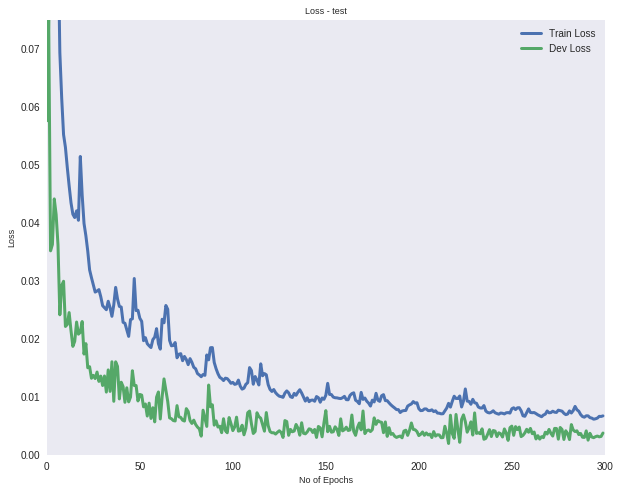

Training Set Score: 0.9362
Dev Set Score: 0.7596
Test Set Score: -5.8869
Training Set MSE: 1823.4472
Dev Set MSE: 1486.1638
Test Set MSE: 2295.9206


In [18]:
plot_loss(history_LSTM, title='test')
#plt.savefig('loss_LSTM_512_1024_lb25_well_' + str(i))
train_mse, train_acc = mean_squared_error(y_train_act, y_pred_train), r2_score(y_train_act, y_pred_train)
dev_mse, dev_acc = mean_squared_error(y_dev_act, y_pred_dev), r2_score(y_dev_act, y_pred_dev)
test_mse, test_acc = mean_squared_error(y_test_act, y_pred_test), r2_score(y_test_act, y_pred_test)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)

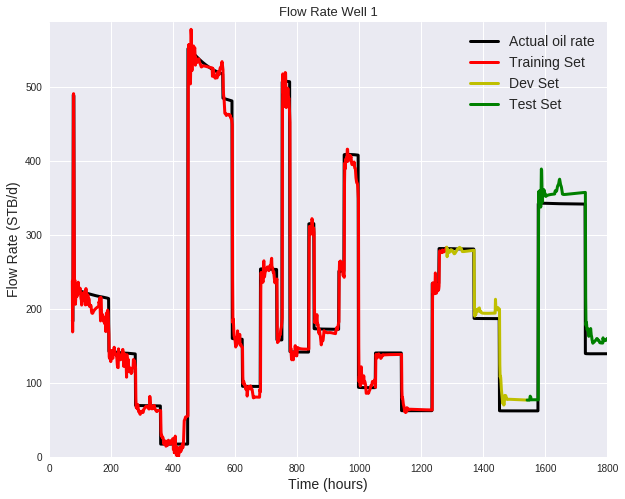

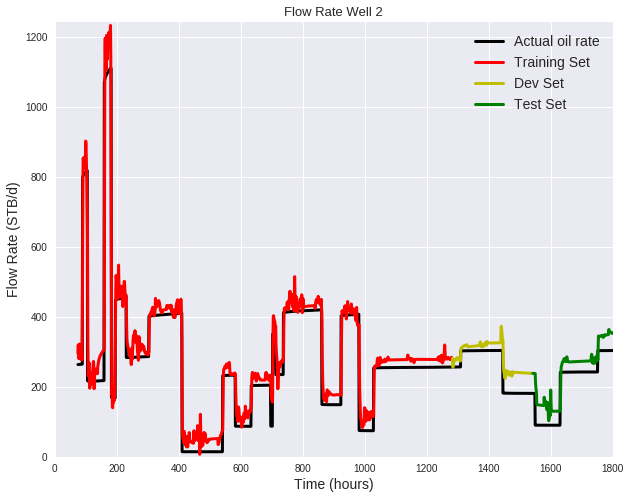

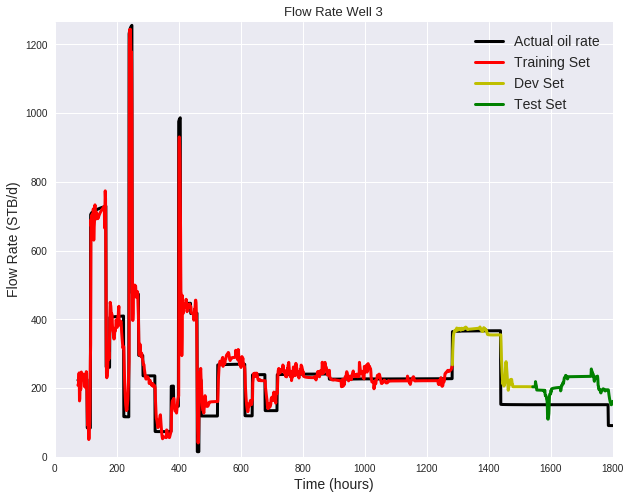

In [19]:
for i in range(y_act.shape[1]):
    plot_pred_rate(t[-len(y_act):].as_matrix(),
                   y_act[:, i], y_pred[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    plt.savefig('traindev_LSTM_512_1024_lb25_well_' + str(i))

GRU

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


Train on 1235 samples, validate on 245 samples
Epoch 1/300
1235/1235 [==============================] - 3s 2ms/step - loss: 0.2403 - dense_6_loss: 0.1006 - dense_7_loss: 0.0844 - dense_8_loss: 0.0553 - dense_6_mean_absolute_error: 0.2688 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.2288 - dense_7_acc: 0.0000e+00 - dense_8_mean_absolute_error: 0.1803 - dense_8_acc: 0.0000e+00 - val_loss: 0.0506 - val_dense_6_loss: 0.0238 - val_dense_7_loss: 0.0071 - val_dense_8_loss: 0.0197 - val_dense_6_mean_absolute_error: 0.1454 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0813 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.1074 - val_dense_8_acc: 0.0000e+00
Epoch 2/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.1467 - dense_6_loss: 0.0449 - dense_7_loss: 0.0535 - dense_8_loss: 0.0483 - dense_6_mean_absolute_error: 0.1712 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.1659 - dense_7_acc: 0.0000e+00 - dense_8_m

Epoch 8/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0556 - dense_6_loss: 0.0188 - dense_7_loss: 0.0209 - dense_8_loss: 0.0160 - dense_6_mean_absolute_error: 0.0955 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.1017 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0843 - dense_8_acc: 8.0972e-04 - val_loss: 0.0322 - val_dense_6_loss: 0.0081 - val_dense_7_loss: 0.0137 - val_dense_8_loss: 0.0104 - val_dense_6_mean_absolute_error: 0.0844 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.1074 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0924 - val_dense_8_acc: 0.0000e+00
Epoch 9/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0488 - dense_6_loss: 0.0178 - dense_7_loss: 0.0177 - dense_8_loss: 0.0133 - dense_6_mean_absolute_error: 0.0957 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0937 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0720 - dense_8_acc: 0.000

Epoch 15/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0341 - dense_6_loss: 0.0114 - dense_7_loss: 0.0122 - dense_8_loss: 0.0106 - dense_6_mean_absolute_error: 0.0698 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0807 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0683 - dense_8_acc: 8.0972e-04 - val_loss: 0.0182 - val_dense_6_loss: 0.0036 - val_dense_7_loss: 0.0067 - val_dense_8_loss: 0.0079 - val_dense_6_mean_absolute_error: 0.0495 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0781 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0801 - val_dense_8_acc: 0.0000e+00
Epoch 16/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0378 - dense_6_loss: 0.0139 - dense_7_loss: 0.0122 - dense_8_loss: 0.0118 - dense_6_mean_absolute_error: 0.0890 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0743 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0723 - dense_8_acc: 8.0

Epoch 22/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0355 - dense_6_loss: 0.0144 - dense_7_loss: 0.0107 - dense_8_loss: 0.0104 - dense_6_mean_absolute_error: 0.0950 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0748 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0765 - dense_8_acc: 8.0972e-04 - val_loss: 0.0160 - val_dense_6_loss: 0.0034 - val_dense_7_loss: 0.0063 - val_dense_8_loss: 0.0064 - val_dense_6_mean_absolute_error: 0.0524 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0751 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0768 - val_dense_8_acc: 0.0000e+00
Epoch 23/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0285 - dense_6_loss: 0.0103 - dense_7_loss: 0.0097 - dense_8_loss: 0.0084 - dense_6_mean_absolute_error: 0.0645 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0685 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0606 - dense_8_acc: 8.0

Epoch 29/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0256 - dense_6_loss: 0.0091 - dense_7_loss: 0.0073 - dense_8_loss: 0.0091 - dense_6_mean_absolute_error: 0.0609 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0581 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0618 - dense_8_acc: 8.0972e-04 - val_loss: 0.0136 - val_dense_6_loss: 0.0025 - val_dense_7_loss: 0.0054 - val_dense_8_loss: 0.0057 - val_dense_6_mean_absolute_error: 0.0437 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0719 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0740 - val_dense_8_acc: 0.0000e+00
Epoch 30/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0226 - dense_6_loss: 0.0083 - dense_7_loss: 0.0071 - dense_8_loss: 0.0073 - dense_6_mean_absolute_error: 0.0560 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0569 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0569 - dense_8_acc: 8.0

Epoch 36/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0294 - dense_6_loss: 0.0081 - dense_7_loss: 0.0123 - dense_8_loss: 0.0091 - dense_6_mean_absolute_error: 0.0568 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0782 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0639 - dense_8_acc: 8.0972e-04 - val_loss: 0.0153 - val_dense_6_loss: 0.0026 - val_dense_7_loss: 0.0054 - val_dense_8_loss: 0.0074 - val_dense_6_mean_absolute_error: 0.0449 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0690 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0762 - val_dense_8_acc: 0.0000e+00
Epoch 37/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0248 - dense_6_loss: 0.0094 - dense_7_loss: 0.0076 - dense_8_loss: 0.0078 - dense_6_mean_absolute_error: 0.0739 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0618 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0597 - dense_8_acc: 8.0

Epoch 43/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0186 - dense_6_loss: 0.0069 - dense_7_loss: 0.0056 - dense_8_loss: 0.0061 - dense_6_mean_absolute_error: 0.0505 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0507 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0501 - dense_8_acc: 8.0972e-04 - val_loss: 0.0099 - val_dense_6_loss: 0.0010 - val_dense_7_loss: 0.0038 - val_dense_8_loss: 0.0051 - val_dense_6_mean_absolute_error: 0.0199 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0598 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0701 - val_dense_8_acc: 0.0000e+00
Epoch 44/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0177 - dense_6_loss: 0.0066 - dense_7_loss: 0.0050 - dense_8_loss: 0.0060 - dense_6_mean_absolute_error: 0.0480 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0494 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0509 - dense_8_acc: 8.0

Epoch 50/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0205 - dense_6_loss: 0.0090 - dense_7_loss: 0.0065 - dense_8_loss: 0.0051 - dense_6_mean_absolute_error: 0.0640 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0592 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0460 - dense_8_acc: 8.0972e-04 - val_loss: 0.0110 - val_dense_6_loss: 0.0055 - val_dense_7_loss: 0.0020 - val_dense_8_loss: 0.0035 - val_dense_6_mean_absolute_error: 0.0673 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0351 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0551 - val_dense_8_acc: 0.0000e+00
Epoch 51/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0180 - dense_6_loss: 0.0070 - dense_7_loss: 0.0058 - dense_8_loss: 0.0052 - dense_6_mean_absolute_error: 0.0529 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0511 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0463 - dense_8_acc: 8.0

Epoch 57/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0173 - dense_6_loss: 0.0063 - dense_7_loss: 0.0052 - dense_8_loss: 0.0057 - dense_6_mean_absolute_error: 0.0505 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0496 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0515 - dense_8_acc: 8.0972e-04 - val_loss: 0.0083 - val_dense_6_loss: 0.0024 - val_dense_7_loss: 0.0023 - val_dense_8_loss: 0.0035 - val_dense_6_mean_absolute_error: 0.0382 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0443 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0585 - val_dense_8_acc: 0.0000e+00
Epoch 58/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0168 - dense_6_loss: 0.0064 - dense_7_loss: 0.0048 - dense_8_loss: 0.0056 - dense_6_mean_absolute_error: 0.0478 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0465 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0489 - dense_8_acc: 8.0

Epoch 64/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0142 - dense_6_loss: 0.0056 - dense_7_loss: 0.0039 - dense_8_loss: 0.0048 - dense_6_mean_absolute_error: 0.0461 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0387 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0452 - dense_8_acc: 8.0972e-04 - val_loss: 0.0038 - val_dense_6_loss: 7.4429e-04 - val_dense_7_loss: 0.0014 - val_dense_8_loss: 0.0017 - val_dense_6_mean_absolute_error: 0.0162 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0302 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0373 - val_dense_8_acc: 0.0000e+00
Epoch 65/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0132 - dense_6_loss: 0.0054 - dense_7_loss: 0.0043 - dense_8_loss: 0.0036 - dense_6_mean_absolute_error: 0.0430 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0451 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0367 - dense_8_acc:

Epoch 71/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0208 - dense_6_loss: 0.0075 - dense_7_loss: 0.0064 - dense_8_loss: 0.0070 - dense_6_mean_absolute_error: 0.0642 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0546 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0598 - dense_8_acc: 8.0972e-04 - val_loss: 0.0119 - val_dense_6_loss: 0.0018 - val_dense_7_loss: 0.0029 - val_dense_8_loss: 0.0073 - val_dense_6_mean_absolute_error: 0.0369 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0524 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0707 - val_dense_8_acc: 0.0000e+00
Epoch 72/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0162 - dense_6_loss: 0.0062 - dense_7_loss: 0.0042 - dense_8_loss: 0.0058 - dense_6_mean_absolute_error: 0.0501 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0424 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0517 - dense_8_acc: 8.0

Epoch 78/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0119 - dense_6_loss: 0.0043 - dense_7_loss: 0.0041 - dense_8_loss: 0.0035 - dense_6_mean_absolute_error: 0.0356 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0404 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0383 - dense_8_acc: 8.0972e-04 - val_loss: 0.0043 - val_dense_6_loss: 0.0011 - val_dense_7_loss: 0.0016 - val_dense_8_loss: 0.0016 - val_dense_6_mean_absolute_error: 0.0216 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0311 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0319 - val_dense_8_acc: 0.0000e+00
Epoch 79/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0110 - dense_6_loss: 0.0040 - dense_7_loss: 0.0038 - dense_8_loss: 0.0033 - dense_6_mean_absolute_error: 0.0360 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0406 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0356 - dense_8_acc: 8.0

Epoch 85/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0122 - dense_6_loss: 0.0047 - dense_7_loss: 0.0042 - dense_8_loss: 0.0033 - dense_6_mean_absolute_error: 0.0426 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0412 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0372 - dense_8_acc: 8.0972e-04 - val_loss: 0.0058 - val_dense_6_loss: 0.0014 - val_dense_7_loss: 0.0021 - val_dense_8_loss: 0.0024 - val_dense_6_mean_absolute_error: 0.0291 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0441 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0472 - val_dense_8_acc: 0.0000e+00
Epoch 86/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0151 - dense_6_loss: 0.0061 - dense_7_loss: 0.0044 - dense_8_loss: 0.0046 - dense_6_mean_absolute_error: 0.0586 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0451 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0492 - dense_8_acc: 8.0

Epoch 92/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0109 - dense_6_loss: 0.0043 - dense_7_loss: 0.0036 - dense_8_loss: 0.0030 - dense_6_mean_absolute_error: 0.0394 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0394 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0326 - dense_8_acc: 8.0972e-04 - val_loss: 0.0025 - val_dense_6_loss: 9.1439e-04 - val_dense_7_loss: 5.1580e-04 - val_dense_8_loss: 0.0011 - val_dense_6_mean_absolute_error: 0.0192 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0180 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0261 - val_dense_8_acc: 0.0000e+00
Epoch 93/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0104 - dense_6_loss: 0.0043 - dense_7_loss: 0.0030 - dense_8_loss: 0.0030 - dense_6_mean_absolute_error: 0.0375 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0346 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0328 - dense_8_

Epoch 99/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0125 - dense_6_loss: 0.0043 - dense_7_loss: 0.0043 - dense_8_loss: 0.0038 - dense_6_mean_absolute_error: 0.0420 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0470 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0423 - dense_8_acc: 8.0972e-04 - val_loss: 0.0027 - val_dense_6_loss: 8.0385e-04 - val_dense_7_loss: 8.9680e-04 - val_dense_8_loss: 9.8968e-04 - val_dense_6_mean_absolute_error: 0.0186 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0280 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0255 - val_dense_8_acc: 0.0000e+00
Epoch 100/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0113 - dense_6_loss: 0.0040 - dense_7_loss: 0.0038 - dense_8_loss: 0.0035 - dense_6_mean_absolute_error: 0.0351 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0425 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0374 - den

Epoch 106/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0097 - dense_6_loss: 0.0038 - dense_7_loss: 0.0028 - dense_8_loss: 0.0031 - dense_6_mean_absolute_error: 0.0347 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0346 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0362 - dense_8_acc: 8.0972e-04 - val_loss: 0.0030 - val_dense_6_loss: 0.0010 - val_dense_7_loss: 8.5770e-04 - val_dense_8_loss: 0.0011 - val_dense_6_mean_absolute_error: 0.0223 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0224 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0280 - val_dense_8_acc: 0.0000e+00
Epoch 107/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0106 - dense_6_loss: 0.0040 - dense_7_loss: 0.0032 - dense_8_loss: 0.0035 - dense_6_mean_absolute_error: 0.0376 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0347 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0384 - dense_8_ac

Epoch 113/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0115 - dense_6_loss: 0.0041 - dense_7_loss: 0.0035 - dense_8_loss: 0.0039 - dense_6_mean_absolute_error: 0.0410 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0389 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0416 - dense_8_acc: 8.0972e-04 - val_loss: 0.0043 - val_dense_6_loss: 0.0013 - val_dense_7_loss: 0.0012 - val_dense_8_loss: 0.0018 - val_dense_6_mean_absolute_error: 0.0260 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0321 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0341 - val_dense_8_acc: 0.0000e+00
Epoch 114/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0102 - dense_6_loss: 0.0038 - dense_7_loss: 0.0033 - dense_8_loss: 0.0031 - dense_6_mean_absolute_error: 0.0374 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0372 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0368 - dense_8_acc: 8

Epoch 120/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0096 - dense_6_loss: 0.0040 - dense_7_loss: 0.0029 - dense_8_loss: 0.0027 - dense_6_mean_absolute_error: 0.0387 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0336 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0322 - dense_8_acc: 8.0972e-04 - val_loss: 0.0031 - val_dense_6_loss: 6.6115e-04 - val_dense_7_loss: 0.0012 - val_dense_8_loss: 0.0012 - val_dense_6_mean_absolute_error: 0.0190 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0254 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0275 - val_dense_8_acc: 0.0000e+00
Epoch 121/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0096 - dense_6_loss: 0.0039 - dense_7_loss: 0.0029 - dense_8_loss: 0.0028 - dense_6_mean_absolute_error: 0.0395 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0339 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0319 - dense_8_ac

Epoch 127/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0093 - dense_6_loss: 0.0037 - dense_7_loss: 0.0028 - dense_8_loss: 0.0029 - dense_6_mean_absolute_error: 0.0341 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0350 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0324 - dense_8_acc: 8.0972e-04 - val_loss: 0.0040 - val_dense_6_loss: 0.0010 - val_dense_7_loss: 0.0012 - val_dense_8_loss: 0.0017 - val_dense_6_mean_absolute_error: 0.0236 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0332 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0338 - val_dense_8_acc: 0.0000e+00
Epoch 128/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0088 - dense_6_loss: 0.0035 - dense_7_loss: 0.0028 - dense_8_loss: 0.0025 - dense_6_mean_absolute_error: 0.0352 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0334 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0288 - dense_8_acc: 8

Epoch 134/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0082 - dense_6_loss: 0.0033 - dense_7_loss: 0.0025 - dense_8_loss: 0.0023 - dense_6_mean_absolute_error: 0.0318 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0310 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0266 - dense_8_acc: 8.0972e-04 - val_loss: 0.0022 - val_dense_6_loss: 8.9505e-04 - val_dense_7_loss: 5.1427e-04 - val_dense_8_loss: 7.5042e-04 - val_dense_6_mean_absolute_error: 0.0226 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0194 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0223 - val_dense_8_acc: 0.0000e+00
Epoch 135/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0078 - dense_6_loss: 0.0030 - dense_7_loss: 0.0023 - dense_8_loss: 0.0025 - dense_6_mean_absolute_error: 0.0310 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0276 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0280 - de

Epoch 141/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0095 - dense_6_loss: 0.0039 - dense_7_loss: 0.0030 - dense_8_loss: 0.0027 - dense_6_mean_absolute_error: 0.0414 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0361 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0318 - dense_8_acc: 8.0972e-04 - val_loss: 0.0030 - val_dense_6_loss: 0.0011 - val_dense_7_loss: 6.7041e-04 - val_dense_8_loss: 0.0013 - val_dense_6_mean_absolute_error: 0.0260 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0228 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0273 - val_dense_8_acc: 0.0000e+00
Epoch 142/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0097 - dense_6_loss: 0.0045 - dense_7_loss: 0.0025 - dense_8_loss: 0.0027 - dense_6_mean_absolute_error: 0.0416 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0322 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0322 - dense_8_ac

Epoch 148/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0086 - dense_6_loss: 0.0031 - dense_7_loss: 0.0024 - dense_8_loss: 0.0031 - dense_6_mean_absolute_error: 0.0313 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0315 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0363 - dense_8_acc: 8.0972e-04 - val_loss: 0.0053 - val_dense_6_loss: 0.0012 - val_dense_7_loss: 0.0022 - val_dense_8_loss: 0.0019 - val_dense_6_mean_absolute_error: 0.0250 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0350 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0368 - val_dense_8_acc: 0.0000e+00
Epoch 149/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0096 - dense_6_loss: 0.0034 - dense_7_loss: 0.0030 - dense_8_loss: 0.0033 - dense_6_mean_absolute_error: 0.0326 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0369 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0373 - dense_8_acc: 8

Epoch 155/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0090 - dense_6_loss: 0.0032 - dense_7_loss: 0.0024 - dense_8_loss: 0.0033 - dense_6_mean_absolute_error: 0.0353 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0328 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0405 - dense_8_acc: 8.0972e-04 - val_loss: 0.0040 - val_dense_6_loss: 0.0010 - val_dense_7_loss: 8.7879e-04 - val_dense_8_loss: 0.0020 - val_dense_6_mean_absolute_error: 0.0238 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0263 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0381 - val_dense_8_acc: 0.0000e+00
Epoch 156/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0084 - dense_6_loss: 0.0031 - dense_7_loss: 0.0024 - dense_8_loss: 0.0028 - dense_6_mean_absolute_error: 0.0316 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0314 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0350 - dense_8_ac

Epoch 162/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0076 - dense_6_loss: 0.0029 - dense_7_loss: 0.0024 - dense_8_loss: 0.0023 - dense_6_mean_absolute_error: 0.0295 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0297 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0276 - dense_8_acc: 8.0972e-04 - val_loss: 0.0036 - val_dense_6_loss: 9.0977e-04 - val_dense_7_loss: 0.0017 - val_dense_8_loss: 9.7253e-04 - val_dense_6_mean_absolute_error: 0.0219 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0351 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0234 - val_dense_8_acc: 0.0000e+00
Epoch 163/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0079 - dense_6_loss: 0.0032 - dense_7_loss: 0.0024 - dense_8_loss: 0.0022 - dense_6_mean_absolute_error: 0.0307 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0326 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0252 - dense_

Epoch 169/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0089 - dense_6_loss: 0.0037 - dense_7_loss: 0.0026 - dense_8_loss: 0.0025 - dense_6_mean_absolute_error: 0.0370 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0333 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0275 - dense_8_acc: 8.0972e-04 - val_loss: 0.0028 - val_dense_6_loss: 7.4418e-04 - val_dense_7_loss: 6.1207e-04 - val_dense_8_loss: 0.0014 - val_dense_6_mean_absolute_error: 0.0189 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0214 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0287 - val_dense_8_acc: 0.0000e+00
Epoch 170/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0086 - dense_6_loss: 0.0037 - dense_7_loss: 0.0026 - dense_8_loss: 0.0023 - dense_6_mean_absolute_error: 0.0394 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0319 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0280 - dense_

Epoch 176/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0074 - dense_6_loss: 0.0032 - dense_7_loss: 0.0021 - dense_8_loss: 0.0022 - dense_6_mean_absolute_error: 0.0303 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0270 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0254 - dense_8_acc: 8.0972e-04 - val_loss: 0.0027 - val_dense_6_loss: 0.0012 - val_dense_7_loss: 7.5244e-04 - val_dense_8_loss: 7.2876e-04 - val_dense_6_mean_absolute_error: 0.0290 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0198 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0213 - val_dense_8_acc: 0.0000e+00
Epoch 177/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0070 - dense_6_loss: 0.0029 - dense_7_loss: 0.0019 - dense_8_loss: 0.0021 - dense_6_mean_absolute_error: 0.0295 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0253 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0250 - dense_

Epoch 183/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0080 - dense_6_loss: 0.0030 - dense_7_loss: 0.0022 - dense_8_loss: 0.0027 - dense_6_mean_absolute_error: 0.0281 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0293 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0315 - dense_8_acc: 8.0972e-04 - val_loss: 0.0028 - val_dense_6_loss: 4.7834e-04 - val_dense_7_loss: 7.6461e-04 - val_dense_8_loss: 0.0015 - val_dense_6_mean_absolute_error: 0.0132 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0239 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0288 - val_dense_8_acc: 0.0000e+00
Epoch 184/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0081 - dense_6_loss: 0.0027 - dense_7_loss: 0.0030 - dense_8_loss: 0.0024 - dense_6_mean_absolute_error: 0.0288 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0371 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0263 - dense_

Epoch 190/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0098 - dense_6_loss: 0.0046 - dense_7_loss: 0.0028 - dense_8_loss: 0.0024 - dense_6_mean_absolute_error: 0.0496 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0360 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0297 - dense_8_acc: 8.0972e-04 - val_loss: 0.0016 - val_dense_6_loss: 7.8216e-04 - val_dense_7_loss: 2.8346e-04 - val_dense_8_loss: 4.9740e-04 - val_dense_6_mean_absolute_error: 0.0185 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0124 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0160 - val_dense_8_acc: 0.0000e+00
Epoch 191/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0090 - dense_6_loss: 0.0037 - dense_7_loss: 0.0027 - dense_8_loss: 0.0026 - dense_6_mean_absolute_error: 0.0387 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0357 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0308 - de

Epoch 197/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0148 - dense_6_loss: 0.0080 - dense_7_loss: 0.0032 - dense_8_loss: 0.0036 - dense_6_mean_absolute_error: 0.0704 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0397 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0408 - dense_8_acc: 8.0972e-04 - val_loss: 0.0026 - val_dense_6_loss: 5.0741e-04 - val_dense_7_loss: 3.0986e-04 - val_dense_8_loss: 0.0017 - val_dense_6_mean_absolute_error: 0.0153 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0131 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0316 - val_dense_8_acc: 0.0000e+00
Epoch 198/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0108 - dense_6_loss: 0.0046 - dense_7_loss: 0.0030 - dense_8_loss: 0.0031 - dense_6_mean_absolute_error: 0.0467 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0365 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0345 - dense_

Epoch 204/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0093 - dense_6_loss: 0.0039 - dense_7_loss: 0.0027 - dense_8_loss: 0.0027 - dense_6_mean_absolute_error: 0.0398 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0316 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0299 - dense_8_acc: 8.0972e-04 - val_loss: 0.0027 - val_dense_6_loss: 8.0609e-04 - val_dense_7_loss: 3.9994e-04 - val_dense_8_loss: 0.0015 - val_dense_6_mean_absolute_error: 0.0214 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0139 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0301 - val_dense_8_acc: 0.0000e+00
Epoch 205/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0087 - dense_6_loss: 0.0034 - dense_7_loss: 0.0026 - dense_8_loss: 0.0027 - dense_6_mean_absolute_error: 0.0378 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0327 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0303 - dense_

Epoch 211/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0073 - dense_6_loss: 0.0028 - dense_7_loss: 0.0024 - dense_8_loss: 0.0021 - dense_6_mean_absolute_error: 0.0291 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0308 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0238 - dense_8_acc: 8.0972e-04 - val_loss: 0.0027 - val_dense_6_loss: 6.3520e-04 - val_dense_7_loss: 0.0011 - val_dense_8_loss: 9.6752e-04 - val_dense_6_mean_absolute_error: 0.0165 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0237 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0231 - val_dense_8_acc: 0.0000e+00
Epoch 212/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0072 - dense_6_loss: 0.0028 - dense_7_loss: 0.0022 - dense_8_loss: 0.0021 - dense_6_mean_absolute_error: 0.0291 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0290 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0259 - dense_

Epoch 218/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0069 - dense_6_loss: 0.0028 - dense_7_loss: 0.0021 - dense_8_loss: 0.0020 - dense_6_mean_absolute_error: 0.0288 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0271 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0244 - dense_8_acc: 8.0972e-04 - val_loss: 0.0023 - val_dense_6_loss: 6.8979e-04 - val_dense_7_loss: 3.8400e-04 - val_dense_8_loss: 0.0012 - val_dense_6_mean_absolute_error: 0.0191 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0155 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0269 - val_dense_8_acc: 0.0000e+00
Epoch 219/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0069 - dense_6_loss: 0.0027 - dense_7_loss: 0.0022 - dense_8_loss: 0.0020 - dense_6_mean_absolute_error: 0.0289 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0289 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0247 - dense_

Epoch 225/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0071 - dense_6_loss: 0.0028 - dense_7_loss: 0.0022 - dense_8_loss: 0.0021 - dense_6_mean_absolute_error: 0.0276 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0297 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0254 - dense_8_acc: 8.0972e-04 - val_loss: 0.0034 - val_dense_6_loss: 0.0010 - val_dense_7_loss: 0.0015 - val_dense_8_loss: 9.5678e-04 - val_dense_6_mean_absolute_error: 0.0249 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0321 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0221 - val_dense_8_acc: 0.0000e+00
Epoch 226/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0070 - dense_6_loss: 0.0027 - dense_7_loss: 0.0023 - dense_8_loss: 0.0019 - dense_6_mean_absolute_error: 0.0269 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0290 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0234 - dense_8_ac

Epoch 232/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0066 - dense_6_loss: 0.0027 - dense_7_loss: 0.0019 - dense_8_loss: 0.0021 - dense_6_mean_absolute_error: 0.0268 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0250 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0242 - dense_8_acc: 8.0972e-04 - val_loss: 0.0025 - val_dense_6_loss: 7.5684e-04 - val_dense_7_loss: 4.5385e-04 - val_dense_8_loss: 0.0013 - val_dense_6_mean_absolute_error: 0.0191 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0186 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0259 - val_dense_8_acc: 0.0000e+00
Epoch 233/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0067 - dense_6_loss: 0.0027 - dense_7_loss: 0.0021 - dense_8_loss: 0.0019 - dense_6_mean_absolute_error: 0.0275 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0264 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0231 - dense_

Epoch 239/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0067 - dense_6_loss: 0.0029 - dense_7_loss: 0.0018 - dense_8_loss: 0.0020 - dense_6_mean_absolute_error: 0.0288 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0255 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0226 - dense_8_acc: 8.0972e-04 - val_loss: 0.0020 - val_dense_6_loss: 6.1953e-04 - val_dense_7_loss: 4.8551e-04 - val_dense_8_loss: 8.7220e-04 - val_dense_6_mean_absolute_error: 0.0162 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0182 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0222 - val_dense_8_acc: 0.0000e+00
Epoch 240/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0069 - dense_6_loss: 0.0029 - dense_7_loss: 0.0020 - dense_8_loss: 0.0019 - dense_6_mean_absolute_error: 0.0323 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0269 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0253 - de

Epoch 246/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0078 - dense_6_loss: 0.0031 - dense_7_loss: 0.0026 - dense_8_loss: 0.0021 - dense_6_mean_absolute_error: 0.0308 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0343 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0249 - dense_8_acc: 8.0972e-04 - val_loss: 0.0021 - val_dense_6_loss: 0.0011 - val_dense_7_loss: 3.3033e-04 - val_dense_8_loss: 6.2860e-04 - val_dense_6_mean_absolute_error: 0.0276 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0143 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0162 - val_dense_8_acc: 0.0000e+00
Epoch 247/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0074 - dense_6_loss: 0.0029 - dense_7_loss: 0.0024 - dense_8_loss: 0.0021 - dense_6_mean_absolute_error: 0.0290 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0327 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0264 - dense_

Epoch 253/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0068 - dense_6_loss: 0.0030 - dense_7_loss: 0.0019 - dense_8_loss: 0.0019 - dense_6_mean_absolute_error: 0.0291 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0262 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0231 - dense_8_acc: 8.0972e-04 - val_loss: 0.0028 - val_dense_6_loss: 8.9085e-04 - val_dense_7_loss: 3.0169e-04 - val_dense_8_loss: 0.0016 - val_dense_6_mean_absolute_error: 0.0223 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0133 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0318 - val_dense_8_acc: 0.0000e+00
Epoch 254/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0071 - dense_6_loss: 0.0031 - dense_7_loss: 0.0019 - dense_8_loss: 0.0021 - dense_6_mean_absolute_error: 0.0291 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0277 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0236 - dense_

Epoch 260/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0068 - dense_6_loss: 0.0028 - dense_7_loss: 0.0021 - dense_8_loss: 0.0019 - dense_6_mean_absolute_error: 0.0303 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0271 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0230 - dense_8_acc: 8.0972e-04 - val_loss: 0.0033 - val_dense_6_loss: 0.0013 - val_dense_7_loss: 0.0013 - val_dense_8_loss: 7.2174e-04 - val_dense_6_mean_absolute_error: 0.0313 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0285 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0198 - val_dense_8_acc: 0.0000e+00
Epoch 261/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0067 - dense_6_loss: 0.0029 - dense_7_loss: 0.0018 - dense_8_loss: 0.0020 - dense_6_mean_absolute_error: 0.0287 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0244 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0232 - dense_8_ac

Epoch 267/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0067 - dense_6_loss: 0.0026 - dense_7_loss: 0.0019 - dense_8_loss: 0.0022 - dense_6_mean_absolute_error: 0.0278 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0270 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0260 - dense_8_acc: 8.0972e-04 - val_loss: 0.0043 - val_dense_6_loss: 9.6802e-04 - val_dense_7_loss: 9.7785e-04 - val_dense_8_loss: 0.0023 - val_dense_6_mean_absolute_error: 0.0256 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0272 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0421 - val_dense_8_acc: 0.0000e+00
Epoch 268/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0067 - dense_6_loss: 0.0027 - dense_7_loss: 0.0018 - dense_8_loss: 0.0022 - dense_6_mean_absolute_error: 0.0277 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0255 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0283 - dense_

Epoch 274/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0073 - dense_6_loss: 0.0028 - dense_7_loss: 0.0023 - dense_8_loss: 0.0022 - dense_6_mean_absolute_error: 0.0281 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0322 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0251 - dense_8_acc: 8.0972e-04 - val_loss: 0.0034 - val_dense_6_loss: 0.0011 - val_dense_7_loss: 0.0015 - val_dense_8_loss: 7.2115e-04 - val_dense_6_mean_absolute_error: 0.0264 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0338 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0220 - val_dense_8_acc: 0.0000e+00
Epoch 275/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0069 - dense_6_loss: 0.0028 - dense_7_loss: 0.0020 - dense_8_loss: 0.0021 - dense_6_mean_absolute_error: 0.0295 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0286 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0238 - dense_8_ac

Epoch 281/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0071 - dense_6_loss: 0.0029 - dense_7_loss: 0.0022 - dense_8_loss: 0.0020 - dense_6_mean_absolute_error: 0.0289 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0289 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0240 - dense_8_acc: 8.0972e-04 - val_loss: 0.0021 - val_dense_6_loss: 4.3456e-04 - val_dense_7_loss: 3.0482e-04 - val_dense_8_loss: 0.0014 - val_dense_6_mean_absolute_error: 0.0126 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0130 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0288 - val_dense_8_acc: 0.0000e+00
Epoch 282/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0078 - dense_6_loss: 0.0035 - dense_7_loss: 0.0023 - dense_8_loss: 0.0020 - dense_6_mean_absolute_error: 0.0372 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0291 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0242 - dense_

Epoch 288/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0066 - dense_6_loss: 0.0027 - dense_7_loss: 0.0021 - dense_8_loss: 0.0018 - dense_6_mean_absolute_error: 0.0265 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0304 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0227 - dense_8_acc: 8.0972e-04 - val_loss: 0.0028 - val_dense_6_loss: 9.3869e-04 - val_dense_7_loss: 9.5537e-04 - val_dense_8_loss: 8.8070e-04 - val_dense_6_mean_absolute_error: 0.0241 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0223 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0200 - val_dense_8_acc: 0.0000e+00
Epoch 289/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0062 - dense_6_loss: 0.0025 - dense_7_loss: 0.0017 - dense_8_loss: 0.0020 - dense_6_mean_absolute_error: 0.0251 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0234 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0246 - de

Epoch 295/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0060 - dense_6_loss: 0.0025 - dense_7_loss: 0.0016 - dense_8_loss: 0.0019 - dense_6_mean_absolute_error: 0.0248 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0220 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0222 - dense_8_acc: 8.0972e-04 - val_loss: 0.0026 - val_dense_6_loss: 8.3436e-04 - val_dense_7_loss: 4.2401e-04 - val_dense_8_loss: 0.0014 - val_dense_6_mean_absolute_error: 0.0229 - val_dense_6_acc: 0.0000e+00 - val_dense_7_mean_absolute_error: 0.0144 - val_dense_7_acc: 0.0000e+00 - val_dense_8_mean_absolute_error: 0.0288 - val_dense_8_acc: 0.0000e+00
Epoch 296/300
1235/1235 [==============================] - 1s 1ms/step - loss: 0.0061 - dense_6_loss: 0.0026 - dense_7_loss: 0.0016 - dense_8_loss: 0.0019 - dense_6_mean_absolute_error: 0.0264 - dense_6_acc: 0.0000e+00 - dense_7_mean_absolute_error: 0.0233 - dense_7_acc: 8.0972e-04 - dense_8_mean_absolute_error: 0.0218 - dense_

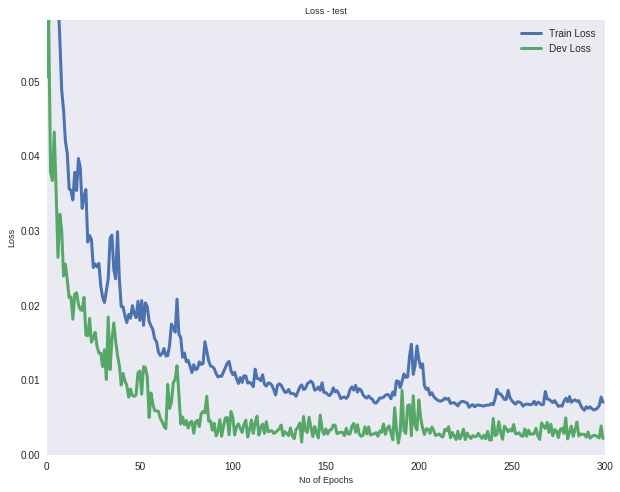

Training Set Score: 0.9465
Dev Set Score: 0.9084
Test Set Score: -2.4083
Training Set MSE: 1489.8051
Dev Set MSE: 725.5548
Test Set MSE: 1072.5453


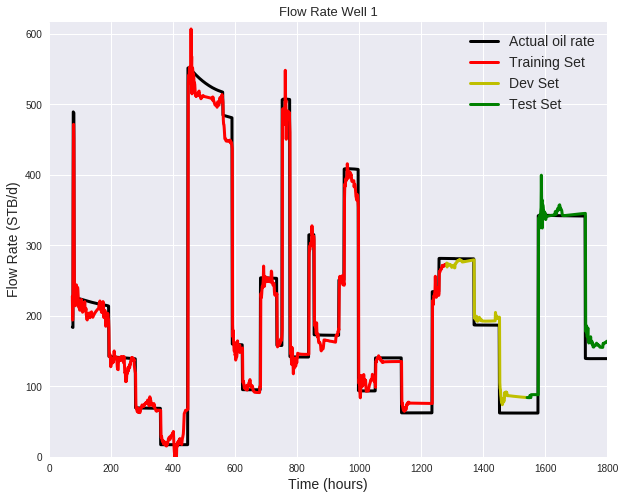

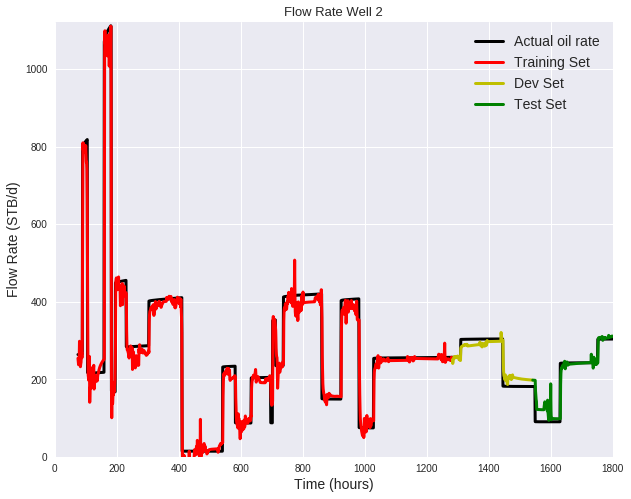

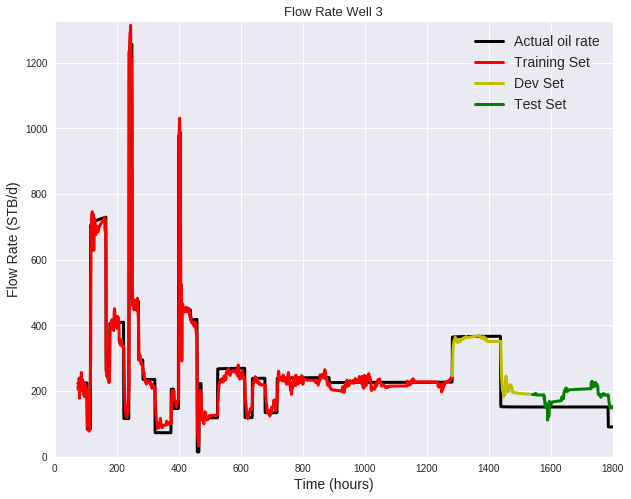

In [20]:
model_GRU, history_GRU = run_model(x_train, y_train, x_dev, y_dev, epochs=300, batch_size=300, method='GRU')

# Training
y_pred_train_pre = model_GRU.predict(x_train)
y_pred_train_scaled = np.concatenate((y_pred_train_pre[0], y_pred_train_pre[1], y_pred_train_pre[2]), axis=1)
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_train_act = scaler_y.inverse_transform(y_train)

# Dev
y_pred_dev_pre = model_GRU.predict(x_dev)
y_pred_dev_scaled = np.concatenate((y_pred_dev_pre[0], y_pred_dev_pre[1], y_pred_dev_pre[2]), axis=1)
y_pred_dev = scaler_y.inverse_transform(y_pred_dev_scaled)
y_dev_act = scaler_y.inverse_transform(y_dev)

# Test
y_pred_test_pre = model_GRU.predict(x_test)
y_pred_test_scaled = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1], y_pred_test_pre[2]), axis=1)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_test_act = scaler_y.inverse_transform(y_test)

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])
y_pred = np.concatenate([y_pred_train, y_pred_dev, y_pred_test])

plot_loss(history_GRU, title='test')
#plt.savefig('loss_LSTM_512_1024_lb25_well_' + str(i))
train_mse, train_acc = mean_squared_error(y_train_act, y_pred_train), r2_score(y_train_act, y_pred_train)
dev_mse, dev_acc = mean_squared_error(y_dev_act, y_pred_dev), r2_score(y_dev_act, y_pred_dev)
test_mse, test_acc = mean_squared_error(y_test_act, y_pred_test), r2_score(y_test_act, y_pred_test)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)

for i in range(y_act.shape[1]):
    plot_pred_rate(t[-len(y_act):].as_matrix(),
                   y_act[:, i], y_pred[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    plt.savefig('traindev_LSTM_512_1024_lb25_well_' + str(i))

Simple RNN

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


Train on 1235 samples, validate on 245 samples
Epoch 1/300
1235/1235 [==============================] - 2s 1ms/step - loss: 11.8842 - dense_14_loss: 1.5349 - dense_15_loss: 2.8967 - dense_16_loss: 7.4526 - dense_14_mean_absolute_error: 1.0561 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 1.3585 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 2.1191 - dense_16_acc: 8.0972e-04 - val_loss: 5.6431 - val_dense_14_loss: 5.4992 - val_dense_15_loss: 0.1406 - val_dense_16_loss: 0.0034 - val_dense_14_mean_absolute_error: 2.3417 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.3720 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0458 - val_dense_16_acc: 0.0000e+00
Epoch 2/300
1235/1235 [==============================] - 1s 412us/step - loss: 6.3189 - dense_14_loss: 3.9016 - dense_15_loss: 1.3049 - dense_16_loss: 1.1124 - dense_14_mean_absolute_error: 1.7113 - dense_14_acc: 0.0000e+00 - dense_15_mean_absolute_error: 0.9307 - dense_15

1235/1235 [==============================] - 0s 381us/step - loss: 0.1505 - dense_14_loss: 0.0794 - dense_15_loss: 0.0397 - dense_16_loss: 0.0314 - dense_14_mean_absolute_error: 0.2373 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1513 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.1382 - dense_16_acc: 0.0000e+00 - val_loss: 0.0313 - val_dense_14_loss: 0.0223 - val_dense_15_loss: 0.0030 - val_dense_16_loss: 0.0061 - val_dense_14_mean_absolute_error: 0.1317 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0461 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0775 - val_dense_16_acc: 0.0000e+00
Epoch 8/300
1235/1235 [==============================] - 0s 383us/step - loss: 0.1416 - dense_14_loss: 0.0677 - dense_15_loss: 0.0421 - dense_16_loss: 0.0318 - dense_14_mean_absolute_error: 0.2112 - dense_14_acc: 0.0000e+00 - dense_15_mean_absolute_error: 0.1578 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.1409 - 

1235/1235 [==============================] - 0s 372us/step - loss: 0.1292 - dense_14_loss: 0.0586 - dense_15_loss: 0.0426 - dense_16_loss: 0.0280 - dense_14_mean_absolute_error: 0.2018 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1527 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.1300 - dense_16_acc: 0.0000e+00 - val_loss: 0.0310 - val_dense_14_loss: 0.0208 - val_dense_15_loss: 0.0022 - val_dense_16_loss: 0.0081 - val_dense_14_mean_absolute_error: 0.1180 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0453 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0722 - val_dense_16_acc: 0.0000e+00
Epoch 14/300
1235/1235 [==============================] - 0s 376us/step - loss: 0.1143 - dense_14_loss: 0.0546 - dense_15_loss: 0.0341 - dense_16_loss: 0.0257 - dense_14_mean_absolute_error: 0.1972 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1401 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.1204 -

Epoch 20/300
1235/1235 [==============================] - 0s 373us/step - loss: 0.1207 - dense_14_loss: 0.0512 - dense_15_loss: 0.0378 - dense_16_loss: 0.0318 - dense_14_mean_absolute_error: 0.1916 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1478 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.1438 - dense_16_acc: 0.0000e+00 - val_loss: 0.0216 - val_dense_14_loss: 0.0136 - val_dense_15_loss: 0.0026 - val_dense_16_loss: 0.0053 - val_dense_14_mean_absolute_error: 0.0995 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0459 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0643 - val_dense_16_acc: 0.0000e+00
Epoch 21/300
1235/1235 [==============================] - 0s 392us/step - loss: 0.1144 - dense_14_loss: 0.0505 - dense_15_loss: 0.0356 - dense_16_loss: 0.0282 - dense_14_mean_absolute_error: 0.1908 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1432 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_er

1235/1235 [==============================] - 0s 372us/step - loss: 0.1022 - dense_14_loss: 0.0469 - dense_15_loss: 0.0330 - dense_16_loss: 0.0223 - dense_14_mean_absolute_error: 0.1793 - dense_14_acc: 0.0000e+00 - dense_15_mean_absolute_error: 0.1400 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.1143 - dense_16_acc: 0.0000e+00 - val_loss: 0.0359 - val_dense_14_loss: 0.0202 - val_dense_15_loss: 0.0070 - val_dense_16_loss: 0.0087 - val_dense_14_mean_absolute_error: 0.1175 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0721 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0741 - val_dense_16_acc: 0.0000e+00
Epoch 27/300
1235/1235 [==============================] - 0s 382us/step - loss: 0.1073 - dense_14_loss: 0.0472 - dense_15_loss: 0.0343 - dense_16_loss: 0.0258 - dense_14_mean_absolute_error: 0.1794 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1451 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.1293 -

1235/1235 [==============================] - 0s 386us/step - loss: 0.0882 - dense_14_loss: 0.0435 - dense_15_loss: 0.0266 - dense_16_loss: 0.0181 - dense_14_mean_absolute_error: 0.1655 - dense_14_acc: 0.0000e+00 - dense_15_mean_absolute_error: 0.1231 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0980 - dense_16_acc: 0.0000e+00 - val_loss: 0.0332 - val_dense_14_loss: 0.0184 - val_dense_15_loss: 0.0077 - val_dense_16_loss: 0.0072 - val_dense_14_mean_absolute_error: 0.1091 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0781 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0614 - val_dense_16_acc: 0.0000e+00
Epoch 33/300
1235/1235 [==============================] - 0s 381us/step - loss: 0.0974 - dense_14_loss: 0.0460 - dense_15_loss: 0.0315 - dense_16_loss: 0.0199 - dense_14_mean_absolute_error: 0.1722 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1390 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.1092 -

Epoch 39/300
1235/1235 [==============================] - 0s 387us/step - loss: 0.0915 - dense_14_loss: 0.0457 - dense_15_loss: 0.0274 - dense_16_loss: 0.0184 - dense_14_mean_absolute_error: 0.1683 - dense_14_acc: 0.0000e+00 - dense_15_mean_absolute_error: 0.1254 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.1033 - dense_16_acc: 0.0000e+00 - val_loss: 0.0384 - val_dense_14_loss: 0.0219 - val_dense_15_loss: 0.0101 - val_dense_16_loss: 0.0064 - val_dense_14_mean_absolute_error: 0.1199 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0925 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0580 - val_dense_16_acc: 0.0000e+00
Epoch 40/300
1235/1235 [==============================] - 0s 378us/step - loss: 0.0981 - dense_14_loss: 0.0467 - dense_15_loss: 0.0307 - dense_16_loss: 0.0207 - dense_14_mean_absolute_error: 0.1725 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1381 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_er

1235/1235 [==============================] - 0s 386us/step - loss: 0.0819 - dense_14_loss: 0.0393 - dense_15_loss: 0.0249 - dense_16_loss: 0.0177 - dense_14_mean_absolute_error: 0.1502 - dense_14_acc: 0.0000e+00 - dense_15_mean_absolute_error: 0.1166 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0983 - dense_16_acc: 0.0000e+00 - val_loss: 0.0215 - val_dense_14_loss: 0.0152 - val_dense_15_loss: 0.0029 - val_dense_16_loss: 0.0034 - val_dense_14_mean_absolute_error: 0.0957 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0382 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0506 - val_dense_16_acc: 0.0000e+00
Epoch 46/300
1235/1235 [==============================] - 0s 384us/step - loss: 0.0859 - dense_14_loss: 0.0415 - dense_15_loss: 0.0261 - dense_16_loss: 0.0184 - dense_14_mean_absolute_error: 0.1593 - dense_14_acc: 0.0000e+00 - dense_15_mean_absolute_error: 0.1219 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.1017 -

1235/1235 [==============================] - 0s 383us/step - loss: 0.0796 - dense_14_loss: 0.0372 - dense_15_loss: 0.0254 - dense_16_loss: 0.0171 - dense_14_mean_absolute_error: 0.1457 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1187 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0965 - dense_16_acc: 0.0000e+00 - val_loss: 0.0167 - val_dense_14_loss: 0.0124 - val_dense_15_loss: 0.0014 - val_dense_16_loss: 0.0029 - val_dense_14_mean_absolute_error: 0.0882 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0247 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0482 - val_dense_16_acc: 0.0000e+00
Epoch 52/300
1235/1235 [==============================] - 0s 389us/step - loss: 0.0806 - dense_14_loss: 0.0399 - dense_15_loss: 0.0237 - dense_16_loss: 0.0171 - dense_14_mean_absolute_error: 0.1551 - dense_14_acc: 0.0000e+00 - dense_15_mean_absolute_error: 0.1160 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0972 -

1235/1235 [==============================] - 0s 381us/step - loss: 0.0810 - dense_14_loss: 0.0387 - dense_15_loss: 0.0235 - dense_16_loss: 0.0188 - dense_14_mean_absolute_error: 0.1520 - dense_14_acc: 0.0000e+00 - dense_15_mean_absolute_error: 0.1140 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.1037 - dense_16_acc: 0.0000e+00 - val_loss: 0.0110 - val_dense_14_loss: 0.0072 - val_dense_15_loss: 9.8907e-04 - val_dense_16_loss: 0.0028 - val_dense_14_mean_absolute_error: 0.0722 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0265 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0460 - val_dense_16_acc: 0.0000e+00
Epoch 58/300
1235/1235 [==============================] - 0s 383us/step - loss: 0.0795 - dense_14_loss: 0.0362 - dense_15_loss: 0.0250 - dense_16_loss: 0.0183 - dense_14_mean_absolute_error: 0.1438 - dense_14_acc: 0.0000e+00 - dense_15_mean_absolute_error: 0.1162 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.09

Epoch 64/300
1235/1235 [==============================] - 0s 388us/step - loss: 0.0775 - dense_14_loss: 0.0363 - dense_15_loss: 0.0242 - dense_16_loss: 0.0171 - dense_14_mean_absolute_error: 0.1429 - dense_14_acc: 0.0000e+00 - dense_15_mean_absolute_error: 0.1157 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0966 - dense_16_acc: 0.0000e+00 - val_loss: 0.0119 - val_dense_14_loss: 0.0085 - val_dense_15_loss: 7.6917e-04 - val_dense_16_loss: 0.0026 - val_dense_14_mean_absolute_error: 0.0727 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0219 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0434 - val_dense_16_acc: 0.0000e+00
Epoch 65/300
1235/1235 [==============================] - 0s 378us/step - loss: 0.0752 - dense_14_loss: 0.0361 - dense_15_loss: 0.0223 - dense_16_loss: 0.0168 - dense_14_mean_absolute_error: 0.1454 - dense_14_acc: 0.0000e+00 - dense_15_mean_absolute_error: 0.1096 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolut

1235/1235 [==============================] - 0s 372us/step - loss: 0.0757 - dense_14_loss: 0.0349 - dense_15_loss: 0.0232 - dense_16_loss: 0.0175 - dense_14_mean_absolute_error: 0.1389 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1137 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0987 - dense_16_acc: 0.0000e+00 - val_loss: 0.0157 - val_dense_14_loss: 0.0129 - val_dense_15_loss: 7.1017e-04 - val_dense_16_loss: 0.0020 - val_dense_14_mean_absolute_error: 0.0881 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0145 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0367 - val_dense_16_acc: 0.0000e+00
Epoch 71/300
1235/1235 [==============================] - 0s 384us/step - loss: 0.0770 - dense_14_loss: 0.0386 - dense_15_loss: 0.0233 - dense_16_loss: 0.0150 - dense_14_mean_absolute_error: 0.1519 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1125 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.09

1235/1235 [==============================] - 0s 380us/step - loss: 0.0736 - dense_14_loss: 0.0333 - dense_15_loss: 0.0229 - dense_16_loss: 0.0174 - dense_14_mean_absolute_error: 0.1336 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1098 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0943 - dense_16_acc: 0.0000e+00 - val_loss: 0.0167 - val_dense_14_loss: 0.0134 - val_dense_15_loss: 8.6139e-04 - val_dense_16_loss: 0.0025 - val_dense_14_mean_absolute_error: 0.0910 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0169 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0383 - val_dense_16_acc: 0.0000e+00
Epoch 77/300
1235/1235 [==============================] - 0s 385us/step - loss: 0.0731 - dense_14_loss: 0.0353 - dense_15_loss: 0.0219 - dense_16_loss: 0.0160 - dense_14_mean_absolute_error: 0.1428 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1099 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.09

1235/1235 [==============================] - 0s 378us/step - loss: 0.0762 - dense_14_loss: 0.0350 - dense_15_loss: 0.0241 - dense_16_loss: 0.0170 - dense_14_mean_absolute_error: 0.1394 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1210 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0958 - dense_16_acc: 0.0000e+00 - val_loss: 0.0135 - val_dense_14_loss: 0.0106 - val_dense_15_loss: 7.8960e-04 - val_dense_16_loss: 0.0021 - val_dense_14_mean_absolute_error: 0.0793 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0150 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0356 - val_dense_16_acc: 0.0000e+00
Epoch 83/300
1235/1235 [==============================] - 0s 381us/step - loss: 0.0730 - dense_14_loss: 0.0351 - dense_15_loss: 0.0223 - dense_16_loss: 0.0156 - dense_14_mean_absolute_error: 0.1386 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1118 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.09

1235/1235 [==============================] - 0s 383us/step - loss: 0.0758 - dense_14_loss: 0.0346 - dense_15_loss: 0.0230 - dense_16_loss: 0.0182 - dense_14_mean_absolute_error: 0.1431 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1126 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0989 - dense_16_acc: 0.0000e+00 - val_loss: 0.0180 - val_dense_14_loss: 0.0115 - val_dense_15_loss: 0.0040 - val_dense_16_loss: 0.0024 - val_dense_14_mean_absolute_error: 0.0849 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0557 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0418 - val_dense_16_acc: 0.0000e+00
Epoch 89/300
1235/1235 [==============================] - 0s 388us/step - loss: 0.0734 - dense_14_loss: 0.0343 - dense_15_loss: 0.0225 - dense_16_loss: 0.0166 - dense_14_mean_absolute_error: 0.1433 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1127 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0923 -

1235/1235 [==============================] - 0s 393us/step - loss: 0.0719 - dense_14_loss: 0.0337 - dense_15_loss: 0.0221 - dense_16_loss: 0.0160 - dense_14_mean_absolute_error: 0.1371 - dense_14_acc: 0.0000e+00 - dense_15_mean_absolute_error: 0.1122 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0918 - dense_16_acc: 0.0000e+00 - val_loss: 0.0228 - val_dense_14_loss: 0.0197 - val_dense_15_loss: 9.9155e-04 - val_dense_16_loss: 0.0021 - val_dense_14_mean_absolute_error: 0.1215 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0202 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0373 - val_dense_16_acc: 0.0000e+00
Epoch 95/300
1235/1235 [==============================] - 0s 384us/step - loss: 0.0732 - dense_14_loss: 0.0353 - dense_15_loss: 0.0216 - dense_16_loss: 0.0164 - dense_14_mean_absolute_error: 0.1458 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1099 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.09

1235/1235 [==============================] - 0s 384us/step - loss: 0.0704 - dense_14_loss: 0.0341 - dense_15_loss: 0.0209 - dense_16_loss: 0.0154 - dense_14_mean_absolute_error: 0.1402 - dense_14_acc: 0.0000e+00 - dense_15_mean_absolute_error: 0.1100 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0930 - dense_16_acc: 0.0000e+00 - val_loss: 0.0127 - val_dense_14_loss: 0.0099 - val_dense_15_loss: 8.8837e-04 - val_dense_16_loss: 0.0019 - val_dense_14_mean_absolute_error: 0.0753 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0266 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0343 - val_dense_16_acc: 0.0000e+00
Epoch 101/300
1235/1235 [==============================] - 0s 386us/step - loss: 0.0718 - dense_14_loss: 0.0322 - dense_15_loss: 0.0229 - dense_16_loss: 0.0168 - dense_14_mean_absolute_error: 0.1349 - dense_14_acc: 0.0000e+00 - dense_15_mean_absolute_error: 0.1123 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0

1235/1235 [==============================] - 0s 389us/step - loss: 0.0677 - dense_14_loss: 0.0296 - dense_15_loss: 0.0216 - dense_16_loss: 0.0165 - dense_14_mean_absolute_error: 0.1328 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1071 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0945 - dense_16_acc: 0.0000e+00 - val_loss: 0.0275 - val_dense_14_loss: 0.0209 - val_dense_15_loss: 0.0023 - val_dense_16_loss: 0.0043 - val_dense_14_mean_absolute_error: 0.1292 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0391 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0491 - val_dense_16_acc: 0.0000e+00
Epoch 107/300
1235/1235 [==============================] - 0s 390us/step - loss: 0.0736 - dense_14_loss: 0.0362 - dense_15_loss: 0.0217 - dense_16_loss: 0.0157 - dense_14_mean_absolute_error: 0.1507 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1121 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0938 

Epoch 113/300
1235/1235 [==============================] - 0s 376us/step - loss: 0.0641 - dense_14_loss: 0.0272 - dense_15_loss: 0.0207 - dense_16_loss: 0.0163 - dense_14_mean_absolute_error: 0.1240 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1074 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0913 - dense_16_acc: 0.0000e+00 - val_loss: 0.0140 - val_dense_14_loss: 0.0101 - val_dense_15_loss: 0.0015 - val_dense_16_loss: 0.0024 - val_dense_14_mean_absolute_error: 0.0784 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0266 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0398 - val_dense_16_acc: 0.0000e+00
Epoch 114/300
1235/1235 [==============================] - 0s 387us/step - loss: 0.0643 - dense_14_loss: 0.0289 - dense_15_loss: 0.0209 - dense_16_loss: 0.0146 - dense_14_mean_absolute_error: 0.1289 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1074 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_

1235/1235 [==============================] - 0s 375us/step - loss: 0.0659 - dense_14_loss: 0.0292 - dense_15_loss: 0.0206 - dense_16_loss: 0.0160 - dense_14_mean_absolute_error: 0.1343 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1049 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0927 - dense_16_acc: 0.0000e+00 - val_loss: 0.0228 - val_dense_14_loss: 0.0141 - val_dense_15_loss: 0.0051 - val_dense_16_loss: 0.0037 - val_dense_14_mean_absolute_error: 0.1038 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0658 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0443 - val_dense_16_acc: 0.0000e+00
Epoch 120/300
1235/1235 [==============================] - 0s 376us/step - loss: 0.0717 - dense_14_loss: 0.0327 - dense_15_loss: 0.0216 - dense_16_loss: 0.0175 - dense_14_mean_absolute_error: 0.1416 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1143 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.1005 

Epoch 126/300
1235/1235 [==============================] - 0s 390us/step - loss: 0.0699 - dense_14_loss: 0.0287 - dense_15_loss: 0.0227 - dense_16_loss: 0.0185 - dense_14_mean_absolute_error: 0.1310 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1153 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.1041 - dense_16_acc: 0.0000e+00 - val_loss: 0.0126 - val_dense_14_loss: 0.0099 - val_dense_15_loss: 6.9150e-04 - val_dense_16_loss: 0.0020 - val_dense_14_mean_absolute_error: 0.0798 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0178 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0378 - val_dense_16_acc: 0.0000e+00
Epoch 127/300
1235/1235 [==============================] - 0s 381us/step - loss: 0.0735 - dense_14_loss: 0.0309 - dense_15_loss: 0.0229 - dense_16_loss: 0.0197 - dense_14_mean_absolute_error: 0.1394 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1114 - dense_15_acc: 0.0000e+00 - dense_16_mean_absol

1235/1235 [==============================] - 0s 377us/step - loss: 0.0889 - dense_14_loss: 0.0394 - dense_15_loss: 0.0269 - dense_16_loss: 0.0226 - dense_14_mean_absolute_error: 0.1579 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1219 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.1109 - dense_16_acc: 0.0000e+00 - val_loss: 0.0187 - val_dense_14_loss: 0.0086 - val_dense_15_loss: 0.0041 - val_dense_16_loss: 0.0061 - val_dense_14_mean_absolute_error: 0.0731 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0593 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0703 - val_dense_16_acc: 0.0000e+00
Epoch 133/300
1235/1235 [==============================] - 0s 373us/step - loss: 0.0797 - dense_14_loss: 0.0318 - dense_15_loss: 0.0262 - dense_16_loss: 0.0216 - dense_14_mean_absolute_error: 0.1388 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1222 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.1074 

1235/1235 [==============================] - 0s 380us/step - loss: 0.0622 - dense_14_loss: 0.0258 - dense_15_loss: 0.0204 - dense_16_loss: 0.0161 - dense_14_mean_absolute_error: 0.1220 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1074 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0936 - dense_16_acc: 0.0000e+00 - val_loss: 0.0138 - val_dense_14_loss: 0.0109 - val_dense_15_loss: 8.2654e-04 - val_dense_16_loss: 0.0021 - val_dense_14_mean_absolute_error: 0.0874 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0171 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0365 - val_dense_16_acc: 0.0000e+00
Epoch 139/300
1235/1235 [==============================] - 0s 383us/step - loss: 0.0640 - dense_14_loss: 0.0263 - dense_15_loss: 0.0214 - dense_16_loss: 0.0163 - dense_14_mean_absolute_error: 0.1262 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1075 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0

1235/1235 [==============================] - 0s 385us/step - loss: 0.0650 - dense_14_loss: 0.0274 - dense_15_loss: 0.0213 - dense_16_loss: 0.0163 - dense_14_mean_absolute_error: 0.1298 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1117 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0920 - dense_16_acc: 0.0000e+00 - val_loss: 0.0189 - val_dense_14_loss: 0.0157 - val_dense_15_loss: 0.0013 - val_dense_16_loss: 0.0019 - val_dense_14_mean_absolute_error: 0.1125 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0341 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0358 - val_dense_16_acc: 0.0000e+00
Epoch 145/300
1235/1235 [==============================] - 0s 385us/step - loss: 0.0657 - dense_14_loss: 0.0287 - dense_15_loss: 0.0205 - dense_16_loss: 0.0165 - dense_14_mean_absolute_error: 0.1344 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1076 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0893 

1235/1235 [==============================] - 0s 378us/step - loss: 0.0582 - dense_14_loss: 0.0223 - dense_15_loss: 0.0201 - dense_16_loss: 0.0158 - dense_14_mean_absolute_error: 0.1167 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1080 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0893 - dense_16_acc: 0.0000e+00 - val_loss: 0.0194 - val_dense_14_loss: 0.0104 - val_dense_15_loss: 0.0059 - val_dense_16_loss: 0.0030 - val_dense_14_mean_absolute_error: 0.0807 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0722 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0384 - val_dense_16_acc: 0.0000e+00
Epoch 151/300
1235/1235 [==============================] - 0s 385us/step - loss: 0.0636 - dense_14_loss: 0.0268 - dense_15_loss: 0.0210 - dense_16_loss: 0.0158 - dense_14_mean_absolute_error: 0.1287 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1117 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0919 

1235/1235 [==============================] - 0s 381us/step - loss: 0.0592 - dense_14_loss: 0.0253 - dense_15_loss: 0.0190 - dense_16_loss: 0.0148 - dense_14_mean_absolute_error: 0.1235 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1029 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0889 - dense_16_acc: 0.0000e+00 - val_loss: 0.0115 - val_dense_14_loss: 0.0078 - val_dense_15_loss: 0.0014 - val_dense_16_loss: 0.0023 - val_dense_14_mean_absolute_error: 0.0735 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0239 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0425 - val_dense_16_acc: 0.0000e+00
Epoch 157/300
1235/1235 [==============================] - 0s 378us/step - loss: 0.0595 - dense_14_loss: 0.0247 - dense_15_loss: 0.0189 - dense_16_loss: 0.0159 - dense_14_mean_absolute_error: 0.1186 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1019 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0925 

1235/1235 [==============================] - 0s 379us/step - loss: 0.0631 - dense_14_loss: 0.0274 - dense_15_loss: 0.0200 - dense_16_loss: 0.0158 - dense_14_mean_absolute_error: 0.1302 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1098 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0926 - dense_16_acc: 0.0000e+00 - val_loss: 0.0105 - val_dense_14_loss: 0.0045 - val_dense_15_loss: 0.0035 - val_dense_16_loss: 0.0026 - val_dense_14_mean_absolute_error: 0.0483 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0510 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0428 - val_dense_16_acc: 0.0000e+00
Epoch 163/300
1235/1235 [==============================] - 0s 373us/step - loss: 0.0568 - dense_14_loss: 0.0229 - dense_15_loss: 0.0190 - dense_16_loss: 0.0150 - dense_14_mean_absolute_error: 0.1136 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1024 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0894 

1235/1235 [==============================] - 0s 372us/step - loss: 0.0707 - dense_14_loss: 0.0347 - dense_15_loss: 0.0198 - dense_16_loss: 0.0163 - dense_14_mean_absolute_error: 0.1517 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1059 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0953 - dense_16_acc: 0.0000e+00 - val_loss: 0.0134 - val_dense_14_loss: 0.0084 - val_dense_15_loss: 0.0018 - val_dense_16_loss: 0.0032 - val_dense_14_mean_absolute_error: 0.0759 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0338 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0403 - val_dense_16_acc: 0.0000e+00
Epoch 169/300
1235/1235 [==============================] - 0s 377us/step - loss: 0.0576 - dense_14_loss: 0.0239 - dense_15_loss: 0.0182 - dense_16_loss: 0.0156 - dense_14_mean_absolute_error: 0.1196 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1018 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0921 

1235/1235 [==============================] - 0s 387us/step - loss: 0.0758 - dense_14_loss: 0.0294 - dense_15_loss: 0.0248 - dense_16_loss: 0.0216 - dense_14_mean_absolute_error: 0.1405 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1177 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.1156 - dense_16_acc: 0.0000e+00 - val_loss: 0.0109 - val_dense_14_loss: 0.0059 - val_dense_15_loss: 0.0013 - val_dense_16_loss: 0.0036 - val_dense_14_mean_absolute_error: 0.0644 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0315 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0560 - val_dense_16_acc: 0.0000e+00
Epoch 175/300
1235/1235 [==============================] - 0s 391us/step - loss: 0.0741 - dense_14_loss: 0.0256 - dense_15_loss: 0.0251 - dense_16_loss: 0.0234 - dense_14_mean_absolute_error: 0.1258 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1175 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.1213 

1235/1235 [==============================] - 0s 392us/step - loss: 0.0655 - dense_14_loss: 0.0254 - dense_15_loss: 0.0212 - dense_16_loss: 0.0188 - dense_14_mean_absolute_error: 0.1294 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1081 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.1052 - dense_16_acc: 0.0000e+00 - val_loss: 0.0138 - val_dense_14_loss: 0.0036 - val_dense_15_loss: 0.0035 - val_dense_16_loss: 0.0068 - val_dense_14_mean_absolute_error: 0.0491 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0557 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0749 - val_dense_16_acc: 0.0000e+00
Epoch 181/300
1235/1235 [==============================] - 0s 380us/step - loss: 0.0743 - dense_14_loss: 0.0301 - dense_15_loss: 0.0237 - dense_16_loss: 0.0205 - dense_14_mean_absolute_error: 0.1380 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1143 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.1080 

1235/1235 [==============================] - 0s 391us/step - loss: 0.0590 - dense_14_loss: 0.0202 - dense_15_loss: 0.0216 - dense_16_loss: 0.0171 - dense_14_mean_absolute_error: 0.1074 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1155 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0976 - dense_16_acc: 0.0000e+00 - val_loss: 0.0081 - val_dense_14_loss: 0.0031 - val_dense_15_loss: 0.0032 - val_dense_16_loss: 0.0019 - val_dense_14_mean_absolute_error: 0.0406 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0490 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0300 - val_dense_16_acc: 0.0000e+00
Epoch 187/300
1235/1235 [==============================] - 0s 379us/step - loss: 0.0621 - dense_14_loss: 0.0206 - dense_15_loss: 0.0235 - dense_16_loss: 0.0181 - dense_14_mean_absolute_error: 0.1086 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1154 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.1011 

Epoch 193/300
1235/1235 [==============================] - 0s 380us/step - loss: 0.0574 - dense_14_loss: 0.0229 - dense_15_loss: 0.0188 - dense_16_loss: 0.0157 - dense_14_mean_absolute_error: 0.1177 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1044 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0943 - dense_16_acc: 0.0000e+00 - val_loss: 0.0082 - val_dense_14_loss: 0.0044 - val_dense_15_loss: 0.0016 - val_dense_16_loss: 0.0021 - val_dense_14_mean_absolute_error: 0.0562 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0291 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0400 - val_dense_16_acc: 0.0000e+00
Epoch 194/300
1235/1235 [==============================] - 0s 388us/step - loss: 0.0555 - dense_14_loss: 0.0187 - dense_15_loss: 0.0197 - dense_16_loss: 0.0171 - dense_14_mean_absolute_error: 0.1053 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1046 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_

1235/1235 [==============================] - 0s 378us/step - loss: 0.0708 - dense_14_loss: 0.0243 - dense_15_loss: 0.0253 - dense_16_loss: 0.0213 - dense_14_mean_absolute_error: 0.1215 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1202 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.1104 - dense_16_acc: 0.0000e+00 - val_loss: 0.0133 - val_dense_14_loss: 0.0023 - val_dense_15_loss: 0.0065 - val_dense_16_loss: 0.0045 - val_dense_14_mean_absolute_error: 0.0410 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0709 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0544 - val_dense_16_acc: 0.0000e+00
Epoch 200/300
1235/1235 [==============================] - 0s 375us/step - loss: 0.0598 - dense_14_loss: 0.0224 - dense_15_loss: 0.0207 - dense_16_loss: 0.0166 - dense_14_mean_absolute_error: 0.1135 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1106 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0955 

1235/1235 [==============================] - 0s 381us/step - loss: 0.0584 - dense_14_loss: 0.0201 - dense_15_loss: 0.0213 - dense_16_loss: 0.0170 - dense_14_mean_absolute_error: 0.1075 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1102 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0977 - dense_16_acc: 0.0000e+00 - val_loss: 0.0043 - val_dense_14_loss: 0.0017 - val_dense_15_loss: 9.1437e-04 - val_dense_16_loss: 0.0017 - val_dense_14_mean_absolute_error: 0.0264 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0172 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0316 - val_dense_16_acc: 0.0000e+00
Epoch 206/300
1235/1235 [==============================] - 0s 379us/step - loss: 0.0557 - dense_14_loss: 0.0183 - dense_15_loss: 0.0202 - dense_16_loss: 0.0173 - dense_14_mean_absolute_error: 0.1012 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1062 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0

1235/1235 [==============================] - 0s 388us/step - loss: 0.0591 - dense_14_loss: 0.0229 - dense_15_loss: 0.0204 - dense_16_loss: 0.0158 - dense_14_mean_absolute_error: 0.1158 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1084 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0870 - dense_16_acc: 0.0000e+00 - val_loss: 0.0175 - val_dense_14_loss: 0.0104 - val_dense_15_loss: 0.0030 - val_dense_16_loss: 0.0041 - val_dense_14_mean_absolute_error: 0.0938 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0408 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0486 - val_dense_16_acc: 0.0000e+00
Epoch 212/300
1235/1235 [==============================] - 0s 373us/step - loss: 0.0608 - dense_14_loss: 0.0238 - dense_15_loss: 0.0186 - dense_16_loss: 0.0183 - dense_14_mean_absolute_error: 0.1226 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1022 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.1042 

1235/1235 [==============================] - 0s 381us/step - loss: 0.0553 - dense_14_loss: 0.0195 - dense_15_loss: 0.0194 - dense_16_loss: 0.0163 - dense_14_mean_absolute_error: 0.1096 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1057 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0921 - dense_16_acc: 0.0000e+00 - val_loss: 0.0066 - val_dense_14_loss: 0.0033 - val_dense_15_loss: 0.0016 - val_dense_16_loss: 0.0017 - val_dense_14_mean_absolute_error: 0.0495 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0293 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0286 - val_dense_16_acc: 0.0000e+00
Epoch 218/300
1235/1235 [==============================] - 0s 369us/step - loss: 0.0533 - dense_14_loss: 0.0174 - dense_15_loss: 0.0198 - dense_16_loss: 0.0162 - dense_14_mean_absolute_error: 0.0988 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1072 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0927 

1235/1235 [==============================] - 0s 384us/step - loss: 0.0571 - dense_14_loss: 0.0235 - dense_15_loss: 0.0177 - dense_16_loss: 0.0159 - dense_14_mean_absolute_error: 0.1204 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1001 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0897 - dense_16_acc: 0.0000e+00 - val_loss: 0.0147 - val_dense_14_loss: 0.0094 - val_dense_15_loss: 0.0027 - val_dense_16_loss: 0.0025 - val_dense_14_mean_absolute_error: 0.0876 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0422 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0400 - val_dense_16_acc: 0.0000e+00
Epoch 224/300
1235/1235 [==============================] - 0s 386us/step - loss: 0.0553 - dense_14_loss: 0.0185 - dense_15_loss: 0.0212 - dense_16_loss: 0.0155 - dense_14_mean_absolute_error: 0.1073 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1115 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0899 

1235/1235 [==============================] - 0s 382us/step - loss: 0.0572 - dense_14_loss: 0.0172 - dense_15_loss: 0.0223 - dense_16_loss: 0.0177 - dense_14_mean_absolute_error: 0.1000 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1125 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.1036 - dense_16_acc: 0.0000e+00 - val_loss: 0.0069 - val_dense_14_loss: 0.0015 - val_dense_15_loss: 0.0012 - val_dense_16_loss: 0.0042 - val_dense_14_mean_absolute_error: 0.0207 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0316 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0530 - val_dense_16_acc: 0.0000e+00
Epoch 230/300
1235/1235 [==============================] - 0s 371us/step - loss: 0.0617 - dense_14_loss: 0.0222 - dense_15_loss: 0.0209 - dense_16_loss: 0.0187 - dense_14_mean_absolute_error: 0.1174 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1063 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.1039 

1235/1235 [==============================] - 0s 378us/step - loss: 0.0632 - dense_14_loss: 0.0255 - dense_15_loss: 0.0219 - dense_16_loss: 0.0157 - dense_14_mean_absolute_error: 0.1258 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1127 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0914 - dense_16_acc: 0.0000e+00 - val_loss: 0.0084 - val_dense_14_loss: 0.0057 - val_dense_15_loss: 0.0011 - val_dense_16_loss: 0.0016 - val_dense_14_mean_absolute_error: 0.0601 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0243 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0283 - val_dense_16_acc: 0.0000e+00
Epoch 236/300
1235/1235 [==============================] - 0s 377us/step - loss: 0.0545 - dense_14_loss: 0.0191 - dense_15_loss: 0.0198 - dense_16_loss: 0.0155 - dense_14_mean_absolute_error: 0.1058 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1056 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0916 

1235/1235 [==============================] - 0s 375us/step - loss: 0.0565 - dense_14_loss: 0.0166 - dense_15_loss: 0.0219 - dense_16_loss: 0.0179 - dense_14_mean_absolute_error: 0.0947 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1105 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0991 - dense_16_acc: 0.0000e+00 - val_loss: 0.0077 - val_dense_14_loss: 0.0039 - val_dense_15_loss: 9.0164e-04 - val_dense_16_loss: 0.0028 - val_dense_14_mean_absolute_error: 0.0519 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0209 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0445 - val_dense_16_acc: 0.0000e+00
Epoch 242/300
1235/1235 [==============================] - 0s 385us/step - loss: 0.0507 - dense_14_loss: 0.0160 - dense_15_loss: 0.0191 - dense_16_loss: 0.0156 - dense_14_mean_absolute_error: 0.0930 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1041 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0

1235/1235 [==============================] - 0s 381us/step - loss: 0.0545 - dense_14_loss: 0.0187 - dense_15_loss: 0.0196 - dense_16_loss: 0.0162 - dense_14_mean_absolute_error: 0.1078 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1057 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0944 - dense_16_acc: 0.0000e+00 - val_loss: 0.0116 - val_dense_14_loss: 0.0077 - val_dense_15_loss: 7.2326e-04 - val_dense_16_loss: 0.0033 - val_dense_14_mean_absolute_error: 0.0788 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0207 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0478 - val_dense_16_acc: 0.0000e+00
Epoch 248/300
1235/1235 [==============================] - 0s 378us/step - loss: 0.0539 - dense_14_loss: 0.0189 - dense_15_loss: 0.0189 - dense_16_loss: 0.0160 - dense_14_mean_absolute_error: 0.1013 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1023 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0

1235/1235 [==============================] - 0s 380us/step - loss: 0.0604 - dense_14_loss: 0.0232 - dense_15_loss: 0.0210 - dense_16_loss: 0.0161 - dense_14_mean_absolute_error: 0.1199 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1065 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0914 - dense_16_acc: 0.0000e+00 - val_loss: 0.0101 - val_dense_14_loss: 0.0047 - val_dense_15_loss: 0.0031 - val_dense_16_loss: 0.0023 - val_dense_14_mean_absolute_error: 0.0636 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0491 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0425 - val_dense_16_acc: 0.0000e+00
Epoch 254/300
1235/1235 [==============================] - 0s 379us/step - loss: 0.0554 - dense_14_loss: 0.0202 - dense_15_loss: 0.0192 - dense_16_loss: 0.0160 - dense_14_mean_absolute_error: 0.1105 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1048 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0939 

1235/1235 [==============================] - 0s 387us/step - loss: 0.0556 - dense_14_loss: 0.0218 - dense_15_loss: 0.0182 - dense_16_loss: 0.0155 - dense_14_mean_absolute_error: 0.1155 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1025 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0895 - dense_16_acc: 0.0000e+00 - val_loss: 0.0160 - val_dense_14_loss: 0.0094 - val_dense_15_loss: 0.0043 - val_dense_16_loss: 0.0022 - val_dense_14_mean_absolute_error: 0.0813 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0578 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0334 - val_dense_16_acc: 0.0000e+00
Epoch 260/300
1235/1235 [==============================] - 0s 386us/step - loss: 0.0546 - dense_14_loss: 0.0194 - dense_15_loss: 0.0191 - dense_16_loss: 0.0160 - dense_14_mean_absolute_error: 0.1112 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1057 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0946 

1235/1235 [==============================] - 0s 381us/step - loss: 0.0500 - dense_14_loss: 0.0146 - dense_15_loss: 0.0197 - dense_16_loss: 0.0158 - dense_14_mean_absolute_error: 0.0895 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1037 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0923 - dense_16_acc: 0.0000e+00 - val_loss: 0.0056 - val_dense_14_loss: 0.0016 - val_dense_15_loss: 0.0011 - val_dense_16_loss: 0.0029 - val_dense_14_mean_absolute_error: 0.0332 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0210 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0504 - val_dense_16_acc: 0.0000e+00
Epoch 266/300
1235/1235 [==============================] - 0s 372us/step - loss: 0.0491 - dense_14_loss: 0.0168 - dense_15_loss: 0.0175 - dense_16_loss: 0.0148 - dense_14_mean_absolute_error: 0.0967 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1001 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0874 

Epoch 272/300
1235/1235 [==============================] - 0s 384us/step - loss: 0.0577 - dense_14_loss: 0.0206 - dense_15_loss: 0.0203 - dense_16_loss: 0.0168 - dense_14_mean_absolute_error: 0.1138 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1054 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0894 - dense_16_acc: 0.0000e+00 - val_loss: 0.0121 - val_dense_14_loss: 0.0087 - val_dense_15_loss: 0.0016 - val_dense_16_loss: 0.0017 - val_dense_14_mean_absolute_error: 0.0816 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0361 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0311 - val_dense_16_acc: 0.0000e+00
Epoch 273/300
1235/1235 [==============================] - 0s 388us/step - loss: 0.0678 - dense_14_loss: 0.0236 - dense_15_loss: 0.0249 - dense_16_loss: 0.0194 - dense_14_mean_absolute_error: 0.1188 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1171 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_

1235/1235 [==============================] - 0s 385us/step - loss: 0.0535 - dense_14_loss: 0.0181 - dense_15_loss: 0.0189 - dense_16_loss: 0.0166 - dense_14_mean_absolute_error: 0.1037 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1051 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0965 - dense_16_acc: 0.0000e+00 - val_loss: 0.0073 - val_dense_14_loss: 0.0036 - val_dense_15_loss: 0.0017 - val_dense_16_loss: 0.0020 - val_dense_14_mean_absolute_error: 0.0494 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0301 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0371 - val_dense_16_acc: 0.0000e+00
Epoch 279/300
1235/1235 [==============================] - 0s 374us/step - loss: 0.0485 - dense_14_loss: 0.0145 - dense_15_loss: 0.0190 - dense_16_loss: 0.0151 - dense_14_mean_absolute_error: 0.0893 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1038 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0865 

1235/1235 [==============================] - 0s 381us/step - loss: 0.0517 - dense_14_loss: 0.0184 - dense_15_loss: 0.0187 - dense_16_loss: 0.0146 - dense_14_mean_absolute_error: 0.1047 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1058 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0865 - dense_16_acc: 0.0000e+00 - val_loss: 0.0146 - val_dense_14_loss: 0.0054 - val_dense_15_loss: 0.0057 - val_dense_16_loss: 0.0034 - val_dense_14_mean_absolute_error: 0.0590 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0696 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0410 - val_dense_16_acc: 0.0000e+00
Epoch 285/300
1235/1235 [==============================] - 0s 378us/step - loss: 0.0509 - dense_14_loss: 0.0172 - dense_15_loss: 0.0178 - dense_16_loss: 0.0158 - dense_14_mean_absolute_error: 0.0999 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1020 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0938 

Epoch 291/300
1235/1235 [==============================] - 0s 378us/step - loss: 0.0490 - dense_14_loss: 0.0162 - dense_15_loss: 0.0177 - dense_16_loss: 0.0151 - dense_14_mean_absolute_error: 0.0954 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0973 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0886 - dense_16_acc: 0.0000e+00 - val_loss: 0.0071 - val_dense_14_loss: 0.0042 - val_dense_15_loss: 8.2198e-04 - val_dense_16_loss: 0.0020 - val_dense_14_mean_absolute_error: 0.0561 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0196 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0373 - val_dense_16_acc: 0.0000e+00
Epoch 292/300
1235/1235 [==============================] - 0s 378us/step - loss: 0.0484 - dense_14_loss: 0.0146 - dense_15_loss: 0.0181 - dense_16_loss: 0.0157 - dense_14_mean_absolute_error: 0.0870 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1010 - dense_15_acc: 8.0972e-04 - dense_16_mean_absol

1235/1235 [==============================] - 0s 392us/step - loss: 0.0499 - dense_14_loss: 0.0175 - dense_15_loss: 0.0171 - dense_16_loss: 0.0152 - dense_14_mean_absolute_error: 0.1020 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0981 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0895 - dense_16_acc: 0.0000e+00 - val_loss: 0.0060 - val_dense_14_loss: 0.0020 - val_dense_15_loss: 7.5568e-04 - val_dense_16_loss: 0.0032 - val_dense_14_mean_absolute_error: 0.0364 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0214 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0473 - val_dense_16_acc: 0.0000e+00
Epoch 298/300
1235/1235 [==============================] - 0s 381us/step - loss: 0.0542 - dense_14_loss: 0.0167 - dense_15_loss: 0.0201 - dense_16_loss: 0.0175 - dense_14_mean_absolute_error: 0.0997 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1051 - dense_15_acc: 0.0000e+00 - dense_16_mean_absolute_error: 0.0

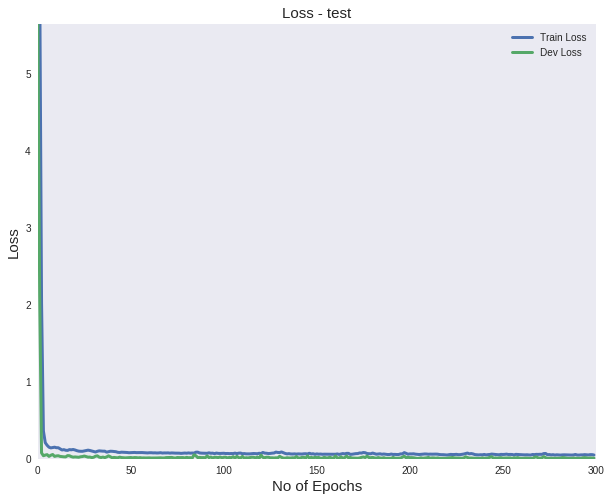

Training Set Score: 0.4156
Dev Set Score: 0.4738
Test Set Score: -11.3533
Training Set MSE: 228710.4070
Dev Set MSE: 56484.3841
Test Set MSE: 68027.2307


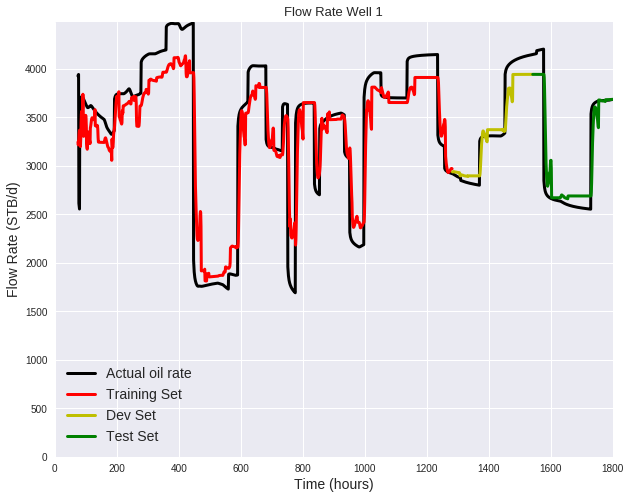

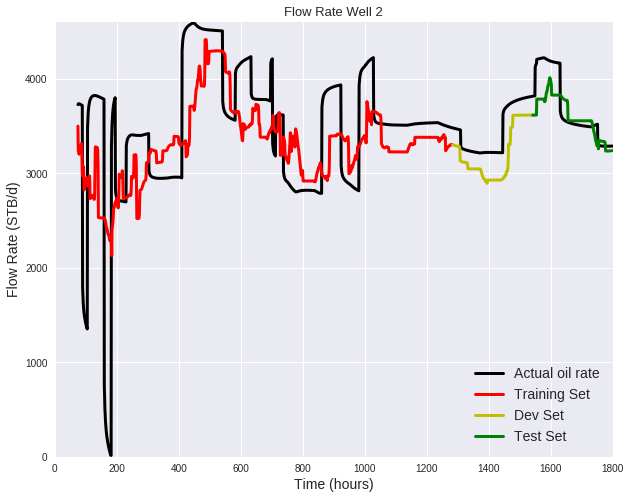

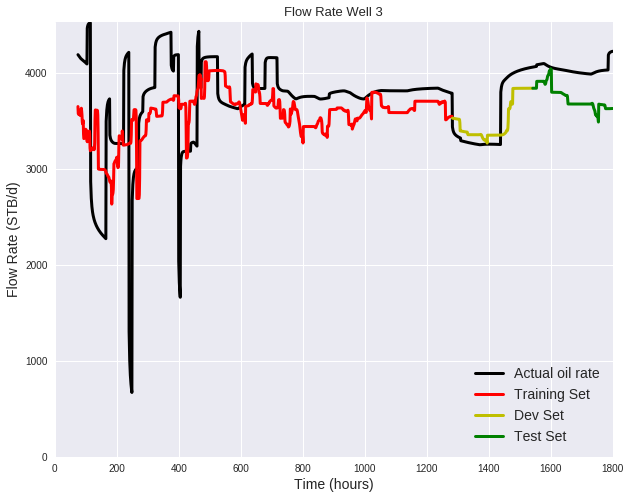

In [40]:
import time
start_time = time.time()
model_RNN, history_RNN = run_model(x_train, y_train, x_dev, y_dev, epochs=300, batch_size=300, method='Simple RNN')
# Measure running time
print("Completed in %s seconds" % (time.time() - start_time))

# Training
y_pred_train_pre = model_RNN.predict(x_train)
y_pred_train_scaled = np.concatenate((y_pred_train_pre[0], y_pred_train_pre[1], y_pred_train_pre[2]), axis=1)
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_train_act = scaler_y.inverse_transform(y_train)

# Dev
y_pred_dev_pre = model_RNN.predict(x_dev)
y_pred_dev_scaled = np.concatenate((y_pred_dev_pre[0], y_pred_dev_pre[1], y_pred_dev_pre[2]), axis=1)
y_pred_dev = scaler_y.inverse_transform(y_pred_dev_scaled)
y_dev_act = scaler_y.inverse_transform(y_dev)

# Test
y_pred_test_pre = model_RNN.predict(x_test)
y_pred_test_scaled = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1], y_pred_test_pre[2]), axis=1)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_test_act = scaler_y.inverse_transform(y_test)

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])
y_pred = np.concatenate([y_pred_train, y_pred_dev, y_pred_test])

plot_loss(history_RNN, title='test')
#plt.savefig('loss_LSTM_512_1024_lb25_well_' + str(i))
train_mse, train_acc = mean_squared_error(y_train_act, y_pred_train), r2_score(y_train_act, y_pred_train)
dev_mse, dev_acc = mean_squared_error(y_dev_act, y_pred_dev), r2_score(y_dev_act, y_pred_dev)
test_mse, test_acc = mean_squared_error(y_test_act, y_pred_test), r2_score(y_test_act, y_pred_test)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)

for i in range(y_act.shape[1]):
    plot_pred_rate(t[-len(y_act):].as_matrix(),
                   y_act[:, i], y_pred[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    plt.savefig('traindev_LSTM_512_1024_lb25_well_' + str(i))

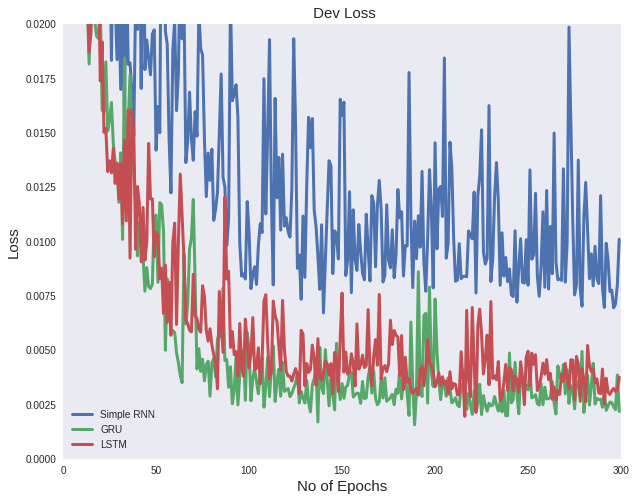

In [39]:
histories = {'Simple RNN': history_RNN,
            'GRU': history_GRU,
            'LSTM': history_LSTM}
plot_loss_comparison(histories)

## BHP Prediction

In [33]:
# Group the input
Y_raw = pd.concat([p['WBHP:P1'], p['WBHP:P2'], p['WBHP:P3']], axis=1, join='inner')
X_raw = pd.concat([qo['WOPR:P1'], qo['WOPR:P2'], qo['WOPR:P3'],
                   qw['WWPR:P1'], qw['WWPR:P2'], qw['WWPR:P3'],
                   wc['WWCT:P1'], wc['WWCT:P2'], wc['WWCT:P3']], axis=1, join='inner')

# Split train-dev and test sets
test_fraction = 0.15
x_traindev_raw, x_test_raw, y_traindev_raw, y_test_raw = train_test_split(X_raw,
                                                  Y_raw,
                                                  test_size=test_fraction,
                                                  shuffle=False)

# Split train and dev sets
dev_fraction = 0.15 # of total dataset
x_train_raw, x_dev_raw, y_train_raw, y_dev_raw = train_test_split(x_traindev_raw,
                                                  y_traindev_raw,
                                                  test_size= dev_fraction/(1-test_fraction),
                                                  shuffle=False)

# Data Scaling
scaler_x = MinMaxScaler()
x_train_norm = scaler_x.fit_transform(x_train_raw.as_matrix())
x_dev_norm = scaler_x.transform(x_dev_raw.as_matrix())
x_test_norm = scaler_x.transform(x_test_raw.as_matrix())

scaler_y = MinMaxScaler()
y_train_norm = scaler_y.fit_transform(y_train_raw.as_matrix())
y_dev_norm = scaler_y.transform(y_dev_raw.as_matrix())
y_test_norm = scaler_y.transform(y_test_raw.as_matrix())

# Create time blocks
x_train, y_train = create_timeblock(x_train_norm, y_train_norm, look_back=25)
x_dev, y_dev = create_timeblock(x_dev_norm, y_dev_norm, look_back=25)
x_test, y_test = create_timeblock(x_test_norm, y_test_norm, look_back=25)

# of data:  1235
# of data:  245
# of data:  246


In [0]:
def run_model(x_train, y_train, x_dev, y_dev, epochs=500, batch_size=400, method='LSTM'):
    classifier = {'GRU' : GRU,
                  'LSTM' : LSTM,
                  'Simple RNN' : SimpleRNN}

    inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))

    X = classifier[method](512, return_sequences=True)(inputs)
    X = classifier[method](1024, return_sequences=True)(X)
    
    X = TimeDistributed(Dense(256, activation='relu'))(X)
    #X = Dropout(0.6)(X)
    
    out1 = Dense(1, activation='linear')(Flatten()(X))
    out2 = Dense(1, activation='linear')(Flatten()(X))
    out3 = Dense(1, activation='linear')(Flatten()(X))
    
    model = Model(input=inputs, output=[out1, out2, out3])
    
    #parallel_model = multi_gpu_model(model, gpus=8)

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae','accuracy'])
    history = model.fit(x_train, [y_train[:, 0], y_train[:, 1], y_train[:, 2]], 
                        epochs=epochs, batch_size=batch_size,
                        validation_data=(x_dev, [y_dev[:, 0], y_dev[:, 1], y_dev[:, 2]]), 
                        verbose=1, shuffle=False)
    return model, history

In [0]:
model, history = run_model(x_train, y_train, x_dev, y_dev, epochs=1000, batch_size=200, method='LSTM')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=[<tf.Tenso...)`


Train on 1235 samples, validate on 245 samples
Epoch 1/1000
1235/1235 [==============================] - 4s 3ms/step - loss: 2.9897 - dense_14_loss: 1.3118 - dense_15_loss: 0.6659 - dense_16_loss: 1.0120 - dense_14_mean_absolute_error: 0.7683 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.6346 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.7367 - dense_16_acc: 8.0972e-04 - val_loss: 0.6676 - val_dense_14_loss: 0.2246 - val_dense_15_loss: 0.2233 - val_dense_16_loss: 0.2197 - val_dense_14_mean_absolute_error: 0.4454 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.4682 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.4584 - val_dense_16_acc: 0.0000e+00
Epoch 2/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.3079 - dense_14_loss: 0.1313 - dense_15_loss: 0.0967 - dense_16_loss: 0.0799 - dense_14_mean_absolute_error: 0.3019 - dense_14_acc: 0.0000e+00 - dense_15_mean_absolute_error: 0.2598 - dense_15_

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0560 - dense_14_loss: 0.0243 - dense_15_loss: 0.0186 - dense_16_loss: 0.0131 - dense_14_mean_absolute_error: 0.1179 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.1067 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0850 - dense_16_acc: 0.0000e+00 - val_loss: 0.0107 - val_dense_14_loss: 0.0034 - val_dense_15_loss: 0.0021 - val_dense_16_loss: 0.0052 - val_dense_14_mean_absolute_error: 0.0470 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0416 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0599 - val_dense_16_acc: 0.0000e+00
Epoch 7/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0519 - dense_14_loss: 0.0183 - dense_15_loss: 0.0161 - dense_16_loss: 0.0174 - dense_14_mean_absolute_error: 0.0904 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0894 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.1063 - den

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0326 - dense_14_loss: 0.0133 - dense_15_loss: 0.0103 - dense_16_loss: 0.0090 - dense_14_mean_absolute_error: 0.0677 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0674 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0557 - dense_16_acc: 0.0000e+00 - val_loss: 0.0051 - val_dense_14_loss: 0.0025 - val_dense_15_loss: 8.9831e-04 - val_dense_16_loss: 0.0017 - val_dense_14_mean_absolute_error: 0.0357 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0209 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0384 - val_dense_16_acc: 0.0000e+00
Epoch 12/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0314 - dense_14_loss: 0.0134 - dense_15_loss: 0.0102 - dense_16_loss: 0.0078 - dense_14_mean_absolute_error: 0.0706 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0658 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0459 

Epoch 17/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0247 - dense_14_loss: 0.0101 - dense_15_loss: 0.0075 - dense_16_loss: 0.0071 - dense_14_mean_absolute_error: 0.0567 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0525 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0437 - dense_16_acc: 0.0000e+00 - val_loss: 0.0038 - val_dense_14_loss: 0.0022 - val_dense_15_loss: 5.5576e-04 - val_dense_16_loss: 0.0010 - val_dense_14_mean_absolute_error: 0.0328 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0135 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0258 - val_dense_16_acc: 0.0000e+00
Epoch 18/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0236 - dense_14_loss: 0.0096 - dense_15_loss: 0.0070 - dense_16_loss: 0.0070 - dense_14_mean_absolute_error: 0.0553 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0509 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_

Epoch 23/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0208 - dense_14_loss: 0.0080 - dense_15_loss: 0.0062 - dense_16_loss: 0.0066 - dense_14_mean_absolute_error: 0.0511 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0503 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0442 - dense_16_acc: 0.0000e+00 - val_loss: 0.0030 - val_dense_14_loss: 0.0013 - val_dense_15_loss: 7.4962e-04 - val_dense_16_loss: 0.0010 - val_dense_14_mean_absolute_error: 0.0219 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0225 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0281 - val_dense_16_acc: 0.0000e+00
Epoch 24/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0203 - dense_14_loss: 0.0079 - dense_15_loss: 0.0060 - dense_16_loss: 0.0063 - dense_14_mean_absolute_error: 0.0488 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0495 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_

Epoch 29/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0326 - dense_14_loss: 0.0130 - dense_15_loss: 0.0097 - dense_16_loss: 0.0099 - dense_14_mean_absolute_error: 0.0914 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0704 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0734 - dense_16_acc: 8.0972e-04 - val_loss: 0.0258 - val_dense_14_loss: 0.0089 - val_dense_15_loss: 0.0085 - val_dense_16_loss: 0.0083 - val_dense_14_mean_absolute_error: 0.0922 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0837 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0878 - val_dense_16_acc: 0.0000e+00
Epoch 30/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0460 - dense_14_loss: 0.0182 - dense_15_loss: 0.0136 - dense_16_loss: 0.0141 - dense_14_mean_absolute_error: 0.1083 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0901 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_erro

Epoch 35/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0307 - dense_14_loss: 0.0104 - dense_15_loss: 0.0118 - dense_16_loss: 0.0085 - dense_14_mean_absolute_error: 0.0693 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0822 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0597 - dense_16_acc: 8.0972e-04 - val_loss: 0.0053 - val_dense_14_loss: 0.0031 - val_dense_15_loss: 6.6096e-04 - val_dense_16_loss: 0.0016 - val_dense_14_mean_absolute_error: 0.0411 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0163 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0331 - val_dense_16_acc: 0.0000e+00
Epoch 36/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0231 - dense_14_loss: 0.0085 - dense_15_loss: 0.0083 - dense_16_loss: 0.0063 - dense_14_mean_absolute_error: 0.0591 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0701 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_

Epoch 41/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0172 - dense_14_loss: 0.0061 - dense_15_loss: 0.0052 - dense_16_loss: 0.0058 - dense_14_mean_absolute_error: 0.0392 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0463 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0441 - dense_16_acc: 8.0972e-04 - val_loss: 0.0030 - val_dense_14_loss: 9.5804e-04 - val_dense_15_loss: 0.0011 - val_dense_16_loss: 0.0010 - val_dense_14_mean_absolute_error: 0.0186 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0313 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0267 - val_dense_16_acc: 0.0000e+00
Epoch 42/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0159 - dense_14_loss: 0.0058 - dense_15_loss: 0.0047 - dense_16_loss: 0.0054 - dense_14_mean_absolute_error: 0.0401 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0398 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_

Epoch 47/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0140 - dense_14_loss: 0.0051 - dense_15_loss: 0.0039 - dense_16_loss: 0.0049 - dense_14_mean_absolute_error: 0.0354 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0335 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0369 - dense_16_acc: 8.0972e-04 - val_loss: 0.0020 - val_dense_14_loss: 9.4044e-04 - val_dense_15_loss: 3.7449e-04 - val_dense_16_loss: 6.4617e-04 - val_dense_14_mean_absolute_error: 0.0228 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0085 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0202 - val_dense_16_acc: 0.0000e+00
Epoch 48/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0138 - dense_14_loss: 0.0051 - dense_15_loss: 0.0038 - dense_16_loss: 0.0049 - dense_14_mean_absolute_error: 0.0360 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0332 - dense_15_acc: 8.0972e-04 - dense_16_mean_a

Epoch 53/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0134 - dense_14_loss: 0.0052 - dense_15_loss: 0.0036 - dense_16_loss: 0.0046 - dense_14_mean_absolute_error: 0.0420 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0333 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0370 - dense_16_acc: 8.0972e-04 - val_loss: 0.0031 - val_dense_14_loss: 0.0019 - val_dense_15_loss: 4.2501e-04 - val_dense_16_loss: 8.1179e-04 - val_dense_14_mean_absolute_error: 0.0404 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0147 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0259 - val_dense_16_acc: 0.0000e+00
Epoch 54/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0137 - dense_14_loss: 0.0056 - dense_15_loss: 0.0035 - dense_16_loss: 0.0046 - dense_14_mean_absolute_error: 0.0462 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0321 - dense_15_acc: 8.0972e-04 - dense_16_mean_absol

Epoch 59/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0187 - dense_14_loss: 0.0068 - dense_15_loss: 0.0060 - dense_16_loss: 0.0059 - dense_14_mean_absolute_error: 0.0597 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0568 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0522 - dense_16_acc: 8.0972e-04 - val_loss: 0.0082 - val_dense_14_loss: 8.4296e-04 - val_dense_15_loss: 0.0043 - val_dense_16_loss: 0.0030 - val_dense_14_mean_absolute_error: 0.0191 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0632 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0532 - val_dense_16_acc: 0.0000e+00
Epoch 60/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0213 - dense_14_loss: 0.0063 - dense_15_loss: 0.0087 - dense_16_loss: 0.0064 - dense_14_mean_absolute_error: 0.0491 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0757 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_

Epoch 65/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0208 - dense_14_loss: 0.0122 - dense_15_loss: 0.0040 - dense_16_loss: 0.0047 - dense_14_mean_absolute_error: 0.0869 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0400 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0362 - dense_16_acc: 8.0972e-04 - val_loss: 0.0047 - val_dense_14_loss: 0.0038 - val_dense_15_loss: 3.7180e-04 - val_dense_16_loss: 5.3123e-04 - val_dense_14_mean_absolute_error: 0.0558 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0134 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0170 - val_dense_16_acc: 0.0000e+00
Epoch 66/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0218 - dense_14_loss: 0.0113 - dense_15_loss: 0.0052 - dense_16_loss: 0.0053 - dense_14_mean_absolute_error: 0.0831 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0540 - dense_15_acc: 8.0972e-04 - dense_16_mean_absol

Epoch 71/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0167 - dense_14_loss: 0.0070 - dense_15_loss: 0.0054 - dense_16_loss: 0.0043 - dense_14_mean_absolute_error: 0.0583 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0550 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0367 - dense_16_acc: 8.0972e-04 - val_loss: 0.0043 - val_dense_14_loss: 0.0022 - val_dense_15_loss: 8.5635e-04 - val_dense_16_loss: 0.0013 - val_dense_14_mean_absolute_error: 0.0382 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0195 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0249 - val_dense_16_acc: 0.0000e+00
Epoch 72/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0167 - dense_14_loss: 0.0076 - dense_15_loss: 0.0042 - dense_16_loss: 0.0049 - dense_14_mean_absolute_error: 0.0635 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0457 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_

Epoch 77/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0108 - dense_14_loss: 0.0042 - dense_15_loss: 0.0029 - dense_16_loss: 0.0037 - dense_14_mean_absolute_error: 0.0320 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0313 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0336 - dense_16_acc: 8.0972e-04 - val_loss: 0.0024 - val_dense_14_loss: 8.7409e-04 - val_dense_15_loss: 6.8794e-04 - val_dense_16_loss: 8.8145e-04 - val_dense_14_mean_absolute_error: 0.0243 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0234 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0276 - val_dense_16_acc: 0.0000e+00
Epoch 78/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0104 - dense_14_loss: 0.0040 - dense_15_loss: 0.0028 - dense_16_loss: 0.0035 - dense_14_mean_absolute_error: 0.0299 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0289 - dense_15_acc: 8.0972e-04 - dense_16_mean_a

Epoch 83/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0096 - dense_14_loss: 0.0039 - dense_15_loss: 0.0025 - dense_16_loss: 0.0033 - dense_14_mean_absolute_error: 0.0328 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0260 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0301 - dense_16_acc: 8.0972e-04 - val_loss: 0.0016 - val_dense_14_loss: 7.1844e-04 - val_dense_15_loss: 2.6318e-04 - val_dense_16_loss: 6.3911e-04 - val_dense_14_mean_absolute_error: 0.0191 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0087 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0229 - val_dense_16_acc: 0.0000e+00
Epoch 84/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0098 - dense_14_loss: 0.0040 - dense_15_loss: 0.0025 - dense_16_loss: 0.0032 - dense_14_mean_absolute_error: 0.0336 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0283 - dense_15_acc: 8.0972e-04 - dense_16_mean_a

Epoch 89/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0105 - dense_14_loss: 0.0048 - dense_15_loss: 0.0025 - dense_16_loss: 0.0033 - dense_14_mean_absolute_error: 0.0436 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0308 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0319 - dense_16_acc: 8.0972e-04 - val_loss: 0.0014 - val_dense_14_loss: 7.9167e-04 - val_dense_15_loss: 2.4633e-04 - val_dense_16_loss: 3.3022e-04 - val_dense_14_mean_absolute_error: 0.0182 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0086 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0096 - val_dense_16_acc: 0.0000e+00
Epoch 90/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0103 - dense_14_loss: 0.0048 - dense_15_loss: 0.0024 - dense_16_loss: 0.0031 - dense_14_mean_absolute_error: 0.0421 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0286 - dense_15_acc: 8.0972e-04 - dense_16_mean_a

Epoch 95/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0152 - dense_14_loss: 0.0053 - dense_15_loss: 0.0059 - dense_16_loss: 0.0039 - dense_14_mean_absolute_error: 0.0472 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0634 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0405 - dense_16_acc: 8.0972e-04 - val_loss: 0.0094 - val_dense_14_loss: 0.0021 - val_dense_15_loss: 0.0038 - val_dense_16_loss: 0.0036 - val_dense_14_mean_absolute_error: 0.0332 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0508 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0533 - val_dense_16_acc: 0.0000e+00
Epoch 96/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0169 - dense_14_loss: 0.0054 - dense_15_loss: 0.0056 - dense_16_loss: 0.0059 - dense_14_mean_absolute_error: 0.0509 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0578 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_erro

Epoch 101/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0186 - dense_14_loss: 0.0083 - dense_15_loss: 0.0032 - dense_16_loss: 0.0071 - dense_14_mean_absolute_error: 0.0697 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0398 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0649 - dense_16_acc: 8.0972e-04 - val_loss: 0.0092 - val_dense_14_loss: 0.0035 - val_dense_15_loss: 8.9289e-04 - val_dense_16_loss: 0.0048 - val_dense_14_mean_absolute_error: 0.0492 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0247 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0627 - val_dense_16_acc: 0.0000e+00
Epoch 102/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0169 - dense_14_loss: 0.0070 - dense_15_loss: 0.0039 - dense_16_loss: 0.0060 - dense_14_mean_absolute_error: 0.0668 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0431 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolut

Epoch 107/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0097 - dense_14_loss: 0.0035 - dense_15_loss: 0.0029 - dense_16_loss: 0.0033 - dense_14_mean_absolute_error: 0.0293 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0338 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0359 - dense_16_acc: 8.0972e-04 - val_loss: 0.0012 - val_dense_14_loss: 4.1673e-04 - val_dense_15_loss: 5.0718e-04 - val_dense_16_loss: 3.1341e-04 - val_dense_14_mean_absolute_error: 0.0078 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0179 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0129 - val_dense_16_acc: 0.0000e+00
Epoch 108/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0089 - dense_14_loss: 0.0032 - dense_15_loss: 0.0027 - dense_16_loss: 0.0030 - dense_14_mean_absolute_error: 0.0252 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0350 - dense_15_acc: 8.0972e-04 - dense_16_mean

Epoch 113/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0085 - dense_14_loss: 0.0035 - dense_15_loss: 0.0022 - dense_16_loss: 0.0029 - dense_14_mean_absolute_error: 0.0305 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0269 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0340 - dense_16_acc: 8.0972e-04 - val_loss: 0.0016 - val_dense_14_loss: 8.9622e-04 - val_dense_15_loss: 2.9921e-04 - val_dense_16_loss: 4.1827e-04 - val_dense_14_mean_absolute_error: 0.0224 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0112 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0158 - val_dense_16_acc: 0.0000e+00
Epoch 114/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0085 - dense_14_loss: 0.0040 - dense_15_loss: 0.0021 - dense_16_loss: 0.0024 - dense_14_mean_absolute_error: 0.0403 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0257 - dense_15_acc: 8.0972e-04 - dense_16_mean

Epoch 119/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0083 - dense_14_loss: 0.0040 - dense_15_loss: 0.0018 - dense_16_loss: 0.0025 - dense_14_mean_absolute_error: 0.0385 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0213 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0303 - dense_16_acc: 8.0972e-04 - val_loss: 0.0021 - val_dense_14_loss: 0.0015 - val_dense_15_loss: 2.0624e-04 - val_dense_16_loss: 4.0827e-04 - val_dense_14_mean_absolute_error: 0.0355 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0089 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0163 - val_dense_16_acc: 0.0000e+00
Epoch 120/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0082 - dense_14_loss: 0.0038 - dense_15_loss: 0.0019 - dense_16_loss: 0.0025 - dense_14_mean_absolute_error: 0.0378 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0244 - dense_15_acc: 8.0972e-04 - dense_16_mean_abs

Epoch 125/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0084 - dense_14_loss: 0.0029 - dense_15_loss: 0.0028 - dense_16_loss: 0.0027 - dense_14_mean_absolute_error: 0.0236 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0360 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0347 - dense_16_acc: 8.0972e-04 - val_loss: 0.0034 - val_dense_14_loss: 7.0872e-04 - val_dense_15_loss: 0.0018 - val_dense_16_loss: 8.7578e-04 - val_dense_14_mean_absolute_error: 0.0220 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0401 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0268 - val_dense_16_acc: 0.0000e+00
Epoch 126/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0085 - dense_14_loss: 0.0030 - dense_15_loss: 0.0032 - dense_16_loss: 0.0023 - dense_14_mean_absolute_error: 0.0290 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0397 - dense_15_acc: 8.0972e-04 - dense_16_mean_abs

Epoch 131/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0123 - dense_14_loss: 0.0056 - dense_15_loss: 0.0025 - dense_16_loss: 0.0043 - dense_14_mean_absolute_error: 0.0516 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0310 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0478 - dense_16_acc: 8.0972e-04 - val_loss: 0.0022 - val_dense_14_loss: 0.0015 - val_dense_15_loss: 2.9062e-04 - val_dense_16_loss: 3.8075e-04 - val_dense_14_mean_absolute_error: 0.0308 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0137 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0141 - val_dense_16_acc: 0.0000e+00
Epoch 132/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0107 - dense_14_loss: 0.0049 - dense_15_loss: 0.0025 - dense_16_loss: 0.0033 - dense_14_mean_absolute_error: 0.0476 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0334 - dense_15_acc: 8.0972e-04 - dense_16_mean_abs

Epoch 137/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0108 - dense_14_loss: 0.0034 - dense_15_loss: 0.0044 - dense_16_loss: 0.0030 - dense_14_mean_absolute_error: 0.0328 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0526 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0378 - dense_16_acc: 8.0972e-04 - val_loss: 0.0033 - val_dense_14_loss: 6.8230e-04 - val_dense_15_loss: 0.0015 - val_dense_16_loss: 0.0010 - val_dense_14_mean_absolute_error: 0.0166 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0306 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0237 - val_dense_16_acc: 0.0000e+00
Epoch 138/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0111 - dense_14_loss: 0.0035 - dense_15_loss: 0.0042 - dense_16_loss: 0.0034 - dense_14_mean_absolute_error: 0.0368 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0500 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolut

Epoch 143/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0118 - dense_14_loss: 0.0063 - dense_15_loss: 0.0020 - dense_16_loss: 0.0035 - dense_14_mean_absolute_error: 0.0601 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0267 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0420 - dense_16_acc: 8.0972e-04 - val_loss: 0.0066 - val_dense_14_loss: 0.0040 - val_dense_15_loss: 3.6713e-04 - val_dense_16_loss: 0.0023 - val_dense_14_mean_absolute_error: 0.0618 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0156 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0441 - val_dense_16_acc: 0.0000e+00
Epoch 144/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0112 - dense_14_loss: 0.0055 - dense_15_loss: 0.0025 - dense_16_loss: 0.0033 - dense_14_mean_absolute_error: 0.0531 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0334 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolut

Epoch 149/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0093 - dense_14_loss: 0.0027 - dense_15_loss: 0.0027 - dense_16_loss: 0.0039 - dense_14_mean_absolute_error: 0.0253 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0341 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0452 - dense_16_acc: 8.0972e-04 - val_loss: 0.0016 - val_dense_14_loss: 3.4919e-04 - val_dense_15_loss: 7.3019e-04 - val_dense_16_loss: 5.3497e-04 - val_dense_14_mean_absolute_error: 0.0096 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0235 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0171 - val_dense_16_acc: 0.0000e+00
Epoch 150/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0095 - dense_14_loss: 0.0029 - dense_15_loss: 0.0033 - dense_16_loss: 0.0032 - dense_14_mean_absolute_error: 0.0289 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0437 - dense_15_acc: 8.0972e-04 - dense_16_mean

Epoch 155/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0065 - dense_14_loss: 0.0027 - dense_15_loss: 0.0017 - dense_16_loss: 0.0021 - dense_14_mean_absolute_error: 0.0254 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0244 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0269 - dense_16_acc: 8.0972e-04 - val_loss: 0.0014 - val_dense_14_loss: 4.0641e-04 - val_dense_15_loss: 5.0017e-04 - val_dense_16_loss: 5.4265e-04 - val_dense_14_mean_absolute_error: 0.0128 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0176 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0194 - val_dense_16_acc: 0.0000e+00
Epoch 156/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0064 - dense_14_loss: 0.0026 - dense_15_loss: 0.0020 - dense_16_loss: 0.0018 - dense_14_mean_absolute_error: 0.0241 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0294 - dense_15_acc: 8.0972e-04 - dense_16_mean

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0072 - dense_14_loss: 0.0033 - dense_15_loss: 0.0021 - dense_16_loss: 0.0018 - dense_14_mean_absolute_error: 0.0370 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0303 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0217 - dense_16_acc: 8.0972e-04 - val_loss: 0.0015 - val_dense_14_loss: 5.9748e-04 - val_dense_15_loss: 6.8019e-04 - val_dense_16_loss: 2.2787e-04 - val_dense_14_mean_absolute_error: 0.0193 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0212 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0081 - val_dense_16_acc: 0.0000e+00
Epoch 161/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0070 - dense_14_loss: 0.0030 - dense_15_loss: 0.0018 - dense_16_loss: 0.0021 - dense_14_mean_absolute_error: 0.0335 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0256 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0076 - dense_14_loss: 0.0031 - dense_15_loss: 0.0017 - dense_16_loss: 0.0027 - dense_14_mean_absolute_error: 0.0338 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0262 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0382 - dense_16_acc: 8.0972e-04 - val_loss: 0.0026 - val_dense_14_loss: 0.0013 - val_dense_15_loss: 3.1389e-04 - val_dense_16_loss: 9.4942e-04 - val_dense_14_mean_absolute_error: 0.0343 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0150 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0254 - val_dense_16_acc: 0.0000e+00
Epoch 166/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0074 - dense_14_loss: 0.0029 - dense_15_loss: 0.0019 - dense_16_loss: 0.0026 - dense_14_mean_absolute_error: 0.0295 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0275 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.

Epoch 171/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0083 - dense_14_loss: 0.0034 - dense_15_loss: 0.0022 - dense_16_loss: 0.0027 - dense_14_mean_absolute_error: 0.0419 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0326 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0375 - dense_16_acc: 8.0972e-04 - val_loss: 0.0030 - val_dense_14_loss: 0.0017 - val_dense_15_loss: 6.0144e-04 - val_dense_16_loss: 6.9078e-04 - val_dense_14_mean_absolute_error: 0.0362 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0198 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0222 - val_dense_16_acc: 0.0000e+00
Epoch 172/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0082 - dense_14_loss: 0.0039 - dense_15_loss: 0.0022 - dense_16_loss: 0.0021 - dense_14_mean_absolute_error: 0.0423 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0313 - dense_15_acc: 8.0972e-04 - dense_16_mean_abs

Epoch 177/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0115 - dense_14_loss: 0.0047 - dense_15_loss: 0.0038 - dense_16_loss: 0.0030 - dense_14_mean_absolute_error: 0.0490 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0466 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0395 - dense_16_acc: 8.0972e-04 - val_loss: 0.0046 - val_dense_14_loss: 0.0016 - val_dense_15_loss: 0.0020 - val_dense_16_loss: 9.8792e-04 - val_dense_14_mean_absolute_error: 0.0336 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0429 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0276 - val_dense_16_acc: 0.0000e+00
Epoch 178/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0133 - dense_14_loss: 0.0044 - dense_15_loss: 0.0051 - dense_16_loss: 0.0039 - dense_14_mean_absolute_error: 0.0470 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0574 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolut

Epoch 183/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0106 - dense_14_loss: 0.0040 - dense_15_loss: 0.0025 - dense_16_loss: 0.0041 - dense_14_mean_absolute_error: 0.0465 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0333 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0475 - dense_16_acc: 8.0972e-04 - val_loss: 0.0049 - val_dense_14_loss: 7.9053e-04 - val_dense_15_loss: 0.0012 - val_dense_16_loss: 0.0030 - val_dense_14_mean_absolute_error: 0.0231 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0292 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0497 - val_dense_16_acc: 0.0000e+00
Epoch 184/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0106 - dense_14_loss: 0.0041 - dense_15_loss: 0.0023 - dense_16_loss: 0.0042 - dense_14_mean_absolute_error: 0.0470 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0318 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolut

Epoch 189/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0080 - dense_14_loss: 0.0037 - dense_15_loss: 0.0018 - dense_16_loss: 0.0025 - dense_14_mean_absolute_error: 0.0399 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0261 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0342 - dense_16_acc: 8.0972e-04 - val_loss: 0.0017 - val_dense_14_loss: 0.0011 - val_dense_15_loss: 2.0296e-04 - val_dense_16_loss: 3.9419e-04 - val_dense_14_mean_absolute_error: 0.0267 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0104 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0127 - val_dense_16_acc: 0.0000e+00
Epoch 190/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0078 - dense_14_loss: 0.0034 - dense_15_loss: 0.0021 - dense_16_loss: 0.0023 - dense_14_mean_absolute_error: 0.0380 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0331 - dense_15_acc: 8.0972e-04 - dense_16_mean_abs

Epoch 195/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0068 - dense_14_loss: 0.0026 - dense_15_loss: 0.0020 - dense_16_loss: 0.0022 - dense_14_mean_absolute_error: 0.0289 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0297 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0295 - dense_16_acc: 8.0972e-04 - val_loss: 0.0028 - val_dense_14_loss: 5.9818e-04 - val_dense_15_loss: 9.4445e-04 - val_dense_16_loss: 0.0012 - val_dense_14_mean_absolute_error: 0.0200 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0262 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0328 - val_dense_16_acc: 0.0000e+00
Epoch 196/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0061 - dense_14_loss: 0.0024 - dense_15_loss: 0.0018 - dense_16_loss: 0.0019 - dense_14_mean_absolute_error: 0.0271 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0266 - dense_15_acc: 8.0972e-04 - dense_16_mean_abs

Epoch 201/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0056 - dense_14_loss: 0.0024 - dense_15_loss: 0.0016 - dense_16_loss: 0.0016 - dense_14_mean_absolute_error: 0.0252 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0243 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0221 - dense_16_acc: 8.0972e-04 - val_loss: 0.0012 - val_dense_14_loss: 5.6178e-04 - val_dense_15_loss: 4.1229e-04 - val_dense_16_loss: 2.0068e-04 - val_dense_14_mean_absolute_error: 0.0157 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0166 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0086 - val_dense_16_acc: 0.0000e+00
Epoch 202/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0059 - dense_14_loss: 0.0025 - dense_15_loss: 0.0019 - dense_16_loss: 0.0016 - dense_14_mean_absolute_error: 0.0270 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0297 - dense_15_acc: 8.0972e-04 - dense_16_mean

Epoch 207/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0056 - dense_14_loss: 0.0025 - dense_15_loss: 0.0013 - dense_16_loss: 0.0017 - dense_14_mean_absolute_error: 0.0298 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0190 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0271 - dense_16_acc: 8.0972e-04 - val_loss: 0.0011 - val_dense_14_loss: 4.0720e-04 - val_dense_15_loss: 1.1910e-04 - val_dense_16_loss: 5.4505e-04 - val_dense_14_mean_absolute_error: 0.0141 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0062 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0195 - val_dense_16_acc: 0.0000e+00
Epoch 208/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0055 - dense_14_loss: 0.0025 - dense_15_loss: 0.0015 - dense_16_loss: 0.0016 - dense_14_mean_absolute_error: 0.0288 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0212 - dense_15_acc: 8.0972e-04 - dense_16_mean

Epoch 213/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0052 - dense_14_loss: 0.0020 - dense_15_loss: 0.0018 - dense_16_loss: 0.0014 - dense_14_mean_absolute_error: 0.0197 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0286 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0185 - dense_16_acc: 8.0972e-04 - val_loss: 0.0018 - val_dense_14_loss: 3.7525e-04 - val_dense_15_loss: 9.8914e-04 - val_dense_16_loss: 4.5694e-04 - val_dense_14_mean_absolute_error: 0.0108 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0308 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0184 - val_dense_16_acc: 0.0000e+00
Epoch 214/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0052 - dense_14_loss: 0.0019 - dense_15_loss: 0.0019 - dense_16_loss: 0.0014 - dense_14_mean_absolute_error: 0.0170 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0301 - dense_15_acc: 8.0972e-04 - dense_16_mean

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0056 - dense_14_loss: 0.0024 - dense_15_loss: 0.0015 - dense_16_loss: 0.0016 - dense_14_mean_absolute_error: 0.0307 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0232 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0248 - dense_16_acc: 8.0972e-04 - val_loss: 0.0015 - val_dense_14_loss: 7.1182e-04 - val_dense_15_loss: 2.0517e-04 - val_dense_16_loss: 5.4338e-04 - val_dense_14_mean_absolute_error: 0.0206 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0101 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0216 - val_dense_16_acc: 0.0000e+00
Epoch 219/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0062 - dense_14_loss: 0.0025 - dense_15_loss: 0.0015 - dense_16_loss: 0.0022 - dense_14_mean_absolute_error: 0.0296 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0215 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0071 - dense_14_loss: 0.0025 - dense_15_loss: 0.0021 - dense_16_loss: 0.0025 - dense_14_mean_absolute_error: 0.0282 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0345 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0322 - dense_16_acc: 8.0972e-04 - val_loss: 0.0016 - val_dense_14_loss: 4.3474e-04 - val_dense_15_loss: 6.6086e-04 - val_dense_16_loss: 5.4366e-04 - val_dense_14_mean_absolute_error: 0.0119 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0208 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0199 - val_dense_16_acc: 0.0000e+00
Epoch 224/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0070 - dense_14_loss: 0.0022 - dense_15_loss: 0.0025 - dense_16_loss: 0.0023 - dense_14_mean_absolute_error: 0.0234 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0348 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error

Epoch 229/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0068 - dense_14_loss: 0.0028 - dense_15_loss: 0.0021 - dense_16_loss: 0.0019 - dense_14_mean_absolute_error: 0.0349 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0298 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0283 - dense_16_acc: 8.0972e-04 - val_loss: 0.0025 - val_dense_14_loss: 0.0013 - val_dense_15_loss: 4.7908e-04 - val_dense_16_loss: 7.7347e-04 - val_dense_14_mean_absolute_error: 0.0301 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0167 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0225 - val_dense_16_acc: 0.0000e+00
Epoch 230/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0084 - dense_14_loss: 0.0040 - dense_15_loss: 0.0019 - dense_16_loss: 0.0024 - dense_14_mean_absolute_error: 0.0478 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0297 - dense_15_acc: 8.0972e-04 - dense_16_mean_abs

Epoch 235/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0103 - dense_14_loss: 0.0052 - dense_15_loss: 0.0022 - dense_16_loss: 0.0029 - dense_14_mean_absolute_error: 0.0553 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0333 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0409 - dense_16_acc: 8.0972e-04 - val_loss: 0.0071 - val_dense_14_loss: 0.0041 - val_dense_15_loss: 0.0011 - val_dense_16_loss: 0.0019 - val_dense_14_mean_absolute_error: 0.0617 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0278 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0398 - val_dense_16_acc: 0.0000e+00
Epoch 236/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0101 - dense_14_loss: 0.0047 - dense_15_loss: 0.0026 - dense_16_loss: 0.0029 - dense_14_mean_absolute_error: 0.0519 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0390 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_er

Epoch 241/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0101 - dense_14_loss: 0.0032 - dense_15_loss: 0.0033 - dense_16_loss: 0.0036 - dense_14_mean_absolute_error: 0.0403 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0422 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0443 - dense_16_acc: 8.0972e-04 - val_loss: 0.0027 - val_dense_14_loss: 4.3953e-04 - val_dense_15_loss: 0.0011 - val_dense_16_loss: 0.0011 - val_dense_14_mean_absolute_error: 0.0123 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0305 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0282 - val_dense_16_acc: 0.0000e+00
Epoch 242/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0106 - dense_14_loss: 0.0037 - dense_15_loss: 0.0036 - dense_16_loss: 0.0033 - dense_14_mean_absolute_error: 0.0443 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0491 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolut

Epoch 247/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0066 - dense_14_loss: 0.0028 - dense_15_loss: 0.0016 - dense_16_loss: 0.0023 - dense_14_mean_absolute_error: 0.0328 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0253 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0326 - dense_16_acc: 8.0972e-04 - val_loss: 0.0036 - val_dense_14_loss: 0.0015 - val_dense_15_loss: 3.4543e-04 - val_dense_16_loss: 0.0017 - val_dense_14_mean_absolute_error: 0.0356 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0150 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0391 - val_dense_16_acc: 0.0000e+00
Epoch 248/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0058 - dense_14_loss: 0.0024 - dense_15_loss: 0.0014 - dense_16_loss: 0.0021 - dense_14_mean_absolute_error: 0.0299 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0203 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolut

Epoch 253/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0051 - dense_14_loss: 0.0018 - dense_15_loss: 0.0013 - dense_16_loss: 0.0020 - dense_14_mean_absolute_error: 0.0180 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0197 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0313 - dense_16_acc: 8.0972e-04 - val_loss: 8.8885e-04 - val_dense_14_loss: 3.3049e-04 - val_dense_15_loss: 2.9989e-04 - val_dense_16_loss: 2.5847e-04 - val_dense_14_mean_absolute_error: 0.0095 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0117 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0125 - val_dense_16_acc: 0.0000e+00
Epoch 254/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0051 - dense_14_loss: 0.0019 - dense_15_loss: 0.0014 - dense_16_loss: 0.0017 - dense_14_mean_absolute_error: 0.0216 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0236 - dense_15_acc: 8.0972e-04 - dense_16_

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0044 - dense_14_loss: 0.0019 - dense_15_loss: 0.0014 - dense_16_loss: 0.0012 - dense_14_mean_absolute_error: 0.0200 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0233 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0161 - dense_16_acc: 8.0972e-04 - val_loss: 9.6548e-04 - val_dense_14_loss: 4.4818e-04 - val_dense_15_loss: 3.4271e-04 - val_dense_16_loss: 1.7459e-04 - val_dense_14_mean_absolute_error: 0.0162 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0150 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0083 - val_dense_16_acc: 0.0000e+00
Epoch 259/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0042 - dense_14_loss: 0.0018 - dense_15_loss: 0.0013 - dense_16_loss: 0.0012 - dense_14_mean_absolute_error: 0.0192 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0204 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_e

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0041 - dense_14_loss: 0.0017 - dense_15_loss: 0.0012 - dense_16_loss: 0.0013 - dense_14_mean_absolute_error: 0.0164 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0182 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0195 - dense_16_acc: 8.0972e-04 - val_loss: 0.0013 - val_dense_14_loss: 3.9312e-04 - val_dense_15_loss: 2.8900e-04 - val_dense_16_loss: 5.8635e-04 - val_dense_14_mean_absolute_error: 0.0144 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0154 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0219 - val_dense_16_acc: 0.0000e+00
Epoch 264/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0040 - dense_14_loss: 0.0017 - dense_15_loss: 0.0011 - dense_16_loss: 0.0013 - dense_14_mean_absolute_error: 0.0162 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0152 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error

Epoch 269/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0041 - dense_14_loss: 0.0020 - dense_15_loss: 0.0010 - dense_16_loss: 0.0011 - dense_14_mean_absolute_error: 0.0251 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0155 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0141 - dense_16_acc: 8.0972e-04 - val_loss: 8.6986e-04 - val_dense_14_loss: 4.2770e-04 - val_dense_15_loss: 2.3667e-04 - val_dense_16_loss: 2.0549e-04 - val_dense_14_mean_absolute_error: 0.0137 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0134 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0099 - val_dense_16_acc: 0.0000e+00
Epoch 270/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0043 - dense_14_loss: 0.0021 - dense_15_loss: 0.0011 - dense_16_loss: 0.0011 - dense_14_mean_absolute_error: 0.0256 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0170 - dense_15_acc: 8.0972e-04 - dense_16_

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0048 - dense_14_loss: 0.0018 - dense_15_loss: 0.0017 - dense_16_loss: 0.0014 - dense_14_mean_absolute_error: 0.0180 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0280 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0217 - dense_16_acc: 8.0972e-04 - val_loss: 6.9137e-04 - val_dense_14_loss: 2.5706e-04 - val_dense_15_loss: 2.5153e-04 - val_dense_16_loss: 1.8278e-04 - val_dense_14_mean_absolute_error: 0.0073 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0113 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0083 - val_dense_16_acc: 0.0000e+00
Epoch 275/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0049 - dense_14_loss: 0.0017 - dense_15_loss: 0.0018 - dense_16_loss: 0.0013 - dense_14_mean_absolute_error: 0.0172 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0296 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_e

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0064 - dense_14_loss: 0.0029 - dense_15_loss: 0.0016 - dense_16_loss: 0.0018 - dense_14_mean_absolute_error: 0.0353 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0252 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0296 - dense_16_acc: 8.0972e-04 - val_loss: 0.0019 - val_dense_14_loss: 8.9706e-04 - val_dense_15_loss: 3.0428e-04 - val_dense_16_loss: 7.2224e-04 - val_dense_14_mean_absolute_error: 0.0238 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0129 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0235 - val_dense_16_acc: 0.0000e+00
Epoch 280/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0076 - dense_14_loss: 0.0035 - dense_15_loss: 0.0016 - dense_16_loss: 0.0024 - dense_14_mean_absolute_error: 0.0422 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0268 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error

Epoch 285/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0085 - dense_14_loss: 0.0038 - dense_15_loss: 0.0027 - dense_16_loss: 0.0020 - dense_14_mean_absolute_error: 0.0429 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0376 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0290 - dense_16_acc: 8.0972e-04 - val_loss: 0.0043 - val_dense_14_loss: 0.0026 - val_dense_15_loss: 0.0010 - val_dense_16_loss: 6.7586e-04 - val_dense_14_mean_absolute_error: 0.0476 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0294 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0239 - val_dense_16_acc: 0.0000e+00
Epoch 286/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0079 - dense_14_loss: 0.0032 - dense_15_loss: 0.0029 - dense_16_loss: 0.0019 - dense_14_mean_absolute_error: 0.0382 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0399 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolut

Epoch 291/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0091 - dense_14_loss: 0.0020 - dense_15_loss: 0.0022 - dense_16_loss: 0.0049 - dense_14_mean_absolute_error: 0.0244 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0294 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0578 - dense_16_acc: 8.0972e-04 - val_loss: 0.0014 - val_dense_14_loss: 5.9488e-04 - val_dense_15_loss: 3.2021e-04 - val_dense_16_loss: 4.5763e-04 - val_dense_14_mean_absolute_error: 0.0205 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0138 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0153 - val_dense_16_acc: 0.0000e+00
Epoch 292/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0085 - dense_14_loss: 0.0031 - dense_15_loss: 0.0021 - dense_16_loss: 0.0033 - dense_14_mean_absolute_error: 0.0356 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0322 - dense_15_acc: 8.0972e-04 - dense_16_mean

Epoch 297/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0090 - dense_14_loss: 0.0062 - dense_15_loss: 0.0014 - dense_16_loss: 0.0014 - dense_14_mean_absolute_error: 0.0657 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0246 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0233 - dense_16_acc: 8.0972e-04 - val_loss: 0.0024 - val_dense_14_loss: 0.0017 - val_dense_15_loss: 1.9433e-04 - val_dense_16_loss: 4.8701e-04 - val_dense_14_mean_absolute_error: 0.0376 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0093 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0163 - val_dense_16_acc: 0.0000e+00
Epoch 298/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0078 - dense_14_loss: 0.0044 - dense_15_loss: 0.0015 - dense_16_loss: 0.0020 - dense_14_mean_absolute_error: 0.0540 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0246 - dense_15_acc: 8.0972e-04 - dense_16_mean_abs

Epoch 303/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0062 - dense_14_loss: 0.0022 - dense_15_loss: 0.0023 - dense_16_loss: 0.0018 - dense_14_mean_absolute_error: 0.0259 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0361 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0263 - dense_16_acc: 8.0972e-04 - val_loss: 0.0010 - val_dense_14_loss: 4.6315e-04 - val_dense_15_loss: 2.6986e-04 - val_dense_16_loss: 2.7484e-04 - val_dense_14_mean_absolute_error: 0.0168 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0137 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0118 - val_dense_16_acc: 0.0000e+00
Epoch 304/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0060 - dense_14_loss: 0.0025 - dense_15_loss: 0.0021 - dense_16_loss: 0.0014 - dense_14_mean_absolute_error: 0.0302 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0347 - dense_15_acc: 8.0972e-04 - dense_16_mean

Epoch 309/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0107 - dense_14_loss: 0.0036 - dense_15_loss: 0.0029 - dense_16_loss: 0.0042 - dense_14_mean_absolute_error: 0.0424 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0421 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0546 - dense_16_acc: 8.0972e-04 - val_loss: 0.0065 - val_dense_14_loss: 0.0018 - val_dense_15_loss: 0.0021 - val_dense_16_loss: 0.0026 - val_dense_14_mean_absolute_error: 0.0323 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0337 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0359 - val_dense_16_acc: 0.0000e+00
Epoch 310/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0106 - dense_14_loss: 0.0036 - dense_15_loss: 0.0029 - dense_16_loss: 0.0041 - dense_14_mean_absolute_error: 0.0392 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0380 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_er

Epoch 315/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0100 - dense_14_loss: 0.0036 - dense_15_loss: 0.0044 - dense_16_loss: 0.0020 - dense_14_mean_absolute_error: 0.0442 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0522 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0320 - dense_16_acc: 8.0972e-04 - val_loss: 0.0015 - val_dense_14_loss: 6.1265e-04 - val_dense_15_loss: 2.9307e-04 - val_dense_16_loss: 6.1734e-04 - val_dense_14_mean_absolute_error: 0.0188 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0125 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0218 - val_dense_16_acc: 0.0000e+00
Epoch 316/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0078 - dense_14_loss: 0.0029 - dense_15_loss: 0.0032 - dense_16_loss: 0.0017 - dense_14_mean_absolute_error: 0.0344 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0448 - dense_15_acc: 8.0972e-04 - dense_16_mean

Epoch 321/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0057 - dense_14_loss: 0.0025 - dense_15_loss: 0.0015 - dense_16_loss: 0.0017 - dense_14_mean_absolute_error: 0.0329 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0254 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0273 - dense_16_acc: 8.0972e-04 - val_loss: 0.0020 - val_dense_14_loss: 6.1275e-04 - val_dense_15_loss: 4.5420e-04 - val_dense_16_loss: 9.1631e-04 - val_dense_14_mean_absolute_error: 0.0198 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0180 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0275 - val_dense_16_acc: 0.0000e+00
Epoch 322/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0048 - dense_14_loss: 0.0021 - dense_15_loss: 0.0012 - dense_16_loss: 0.0014 - dense_14_mean_absolute_error: 0.0273 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0193 - dense_15_acc: 8.0972e-04 - dense_16_mean

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0043 - dense_14_loss: 0.0021 - dense_15_loss: 0.0011 - dense_16_loss: 0.0011 - dense_14_mean_absolute_error: 0.0264 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0169 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0170 - dense_16_acc: 8.0972e-04 - val_loss: 6.4339e-04 - val_dense_14_loss: 3.2116e-04 - val_dense_15_loss: 1.5705e-04 - val_dense_16_loss: 1.6518e-04 - val_dense_14_mean_absolute_error: 0.0102 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0096 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0069 - val_dense_16_acc: 0.0000e+00
Epoch 327/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0042 - dense_14_loss: 0.0020 - dense_15_loss: 9.6410e-04 - dense_16_loss: 0.0012 - dense_14_mean_absolute_error: 0.0235 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0145 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolu

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0041 - dense_14_loss: 0.0019 - dense_15_loss: 9.9366e-04 - dense_16_loss: 0.0012 - dense_14_mean_absolute_error: 0.0232 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0161 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0192 - dense_16_acc: 8.0972e-04 - val_loss: 8.6175e-04 - val_dense_14_loss: 4.2033e-04 - val_dense_15_loss: 1.4198e-04 - val_dense_16_loss: 2.9944e-04 - val_dense_14_mean_absolute_error: 0.0152 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0081 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0133 - val_dense_16_acc: 0.0000e+00
Epoch 332/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0040 - dense_14_loss: 0.0018 - dense_15_loss: 0.0010 - dense_16_loss: 0.0011 - dense_14_mean_absolute_error: 0.0207 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0167 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolu

Epoch 337/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0037 - dense_14_loss: 0.0016 - dense_15_loss: 9.7146e-04 - dense_16_loss: 0.0010 - dense_14_mean_absolute_error: 0.0160 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0149 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0151 - dense_16_acc: 8.0972e-04 - val_loss: 5.5559e-04 - val_dense_14_loss: 2.8896e-04 - val_dense_15_loss: 1.1732e-04 - val_dense_16_loss: 1.4930e-04 - val_dense_14_mean_absolute_error: 0.0089 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0069 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0067 - val_dense_16_acc: 0.0000e+00
Epoch 338/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0038 - dense_14_loss: 0.0017 - dense_15_loss: 0.0011 - dense_16_loss: 0.0010 - dense_14_mean_absolute_error: 0.0175 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0186 - dense_15_acc: 8.0972e-04 - dense

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0038 - dense_14_loss: 0.0017 - dense_15_loss: 0.0010 - dense_16_loss: 0.0010 - dense_14_mean_absolute_error: 0.0184 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0174 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0170 - dense_16_acc: 8.0972e-04 - val_loss: 7.9765e-04 - val_dense_14_loss: 2.8747e-04 - val_dense_15_loss: 2.8310e-04 - val_dense_16_loss: 2.2708e-04 - val_dense_14_mean_absolute_error: 0.0098 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0137 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0112 - val_dense_16_acc: 0.0000e+00
Epoch 343/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0037 - dense_14_loss: 0.0017 - dense_15_loss: 9.5501e-04 - dense_16_loss: 0.0010 - dense_14_mean_absolute_error: 0.0182 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0152 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolu

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0037 - dense_14_loss: 0.0018 - dense_15_loss: 8.7581e-04 - dense_16_loss: 9.9459e-04 - dense_14_mean_absolute_error: 0.0200 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0125 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0147 - dense_16_acc: 8.0972e-04 - val_loss: 0.0014 - val_dense_14_loss: 7.7379e-04 - val_dense_15_loss: 1.7611e-04 - val_dense_16_loss: 4.0755e-04 - val_dense_14_mean_absolute_error: 0.0251 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0103 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0180 - val_dense_16_acc: 0.0000e+00
Epoch 348/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0036 - dense_14_loss: 0.0018 - dense_15_loss: 8.6355e-04 - dense_16_loss: 9.6731e-04 - dense_14_mean_absolute_error: 0.0218 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0118 - dense_15_acc: 8.0972e-04 - dense_16_mea

Epoch 353/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0036 - dense_14_loss: 0.0018 - dense_15_loss: 8.7679e-04 - dense_16_loss: 9.4219e-04 - dense_14_mean_absolute_error: 0.0203 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0139 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0132 - dense_16_acc: 8.0972e-04 - val_loss: 5.7459e-04 - val_dense_14_loss: 3.3190e-04 - val_dense_15_loss: 9.8670e-05 - val_dense_16_loss: 1.4402e-04 - val_dense_14_mean_absolute_error: 0.0100 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0063 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0066 - val_dense_16_acc: 0.0000e+00
Epoch 354/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0038 - dense_14_loss: 0.0019 - dense_15_loss: 9.3794e-04 - dense_16_loss: 9.7770e-04 - dense_14_mean_absolute_error: 0.0227 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0155 - dense_15_acc: 8.0972

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0038 - dense_14_loss: 0.0016 - dense_15_loss: 0.0011 - dense_16_loss: 0.0011 - dense_14_mean_absolute_error: 0.0168 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0197 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0177 - dense_16_acc: 8.0972e-04 - val_loss: 8.2068e-04 - val_dense_14_loss: 2.9859e-04 - val_dense_15_loss: 2.5269e-04 - val_dense_16_loss: 2.6940e-04 - val_dense_14_mean_absolute_error: 0.0106 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0116 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0119 - val_dense_16_acc: 0.0000e+00
Epoch 359/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0041 - dense_14_loss: 0.0016 - dense_15_loss: 0.0012 - dense_16_loss: 0.0013 - dense_14_mean_absolute_error: 0.0166 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0221 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_e

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0044 - dense_14_loss: 0.0019 - dense_15_loss: 0.0012 - dense_16_loss: 0.0014 - dense_14_mean_absolute_error: 0.0222 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0208 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0252 - dense_16_acc: 8.0972e-04 - val_loss: 0.0015 - val_dense_14_loss: 3.5087e-04 - val_dense_15_loss: 5.8185e-04 - val_dense_16_loss: 5.8723e-04 - val_dense_14_mean_absolute_error: 0.0130 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0206 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0197 - val_dense_16_acc: 0.0000e+00
Epoch 364/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0042 - dense_14_loss: 0.0019 - dense_15_loss: 0.0011 - dense_16_loss: 0.0013 - dense_14_mean_absolute_error: 0.0223 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0181 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error

Epoch 369/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0046 - dense_14_loss: 0.0028 - dense_15_loss: 8.4290e-04 - dense_16_loss: 0.0010 - dense_14_mean_absolute_error: 0.0378 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0123 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0158 - dense_16_acc: 8.0972e-04 - val_loss: 7.8708e-04 - val_dense_14_loss: 4.6624e-04 - val_dense_15_loss: 1.5501e-04 - val_dense_16_loss: 1.6583e-04 - val_dense_14_mean_absolute_error: 0.0151 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0097 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0078 - val_dense_16_acc: 0.0000e+00
Epoch 370/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0048 - dense_14_loss: 0.0029 - dense_15_loss: 8.8839e-04 - dense_16_loss: 0.0010 - dense_14_mean_absolute_error: 0.0373 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0151 - dense_15_acc: 8.0972e-04 - d

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0051 - dense_14_loss: 0.0025 - dense_15_loss: 0.0014 - dense_16_loss: 0.0012 - dense_14_mean_absolute_error: 0.0312 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0247 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0199 - dense_16_acc: 8.0972e-04 - val_loss: 0.0010 - val_dense_14_loss: 4.1899e-04 - val_dense_15_loss: 3.6324e-04 - val_dense_16_loss: 2.2043e-04 - val_dense_14_mean_absolute_error: 0.0126 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0155 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0097 - val_dense_16_acc: 0.0000e+00
Epoch 375/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0053 - dense_14_loss: 0.0021 - dense_15_loss: 0.0018 - dense_16_loss: 0.0014 - dense_14_mean_absolute_error: 0.0259 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0316 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0059 - dense_14_loss: 0.0018 - dense_15_loss: 0.0022 - dense_16_loss: 0.0018 - dense_14_mean_absolute_error: 0.0211 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0378 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0314 - dense_16_acc: 8.0972e-04 - val_loss: 0.0017 - val_dense_14_loss: 4.4596e-04 - val_dense_15_loss: 6.4933e-04 - val_dense_16_loss: 6.5187e-04 - val_dense_14_mean_absolute_error: 0.0138 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0234 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0206 - val_dense_16_acc: 0.0000e+00
Epoch 380/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0062 - dense_14_loss: 0.0024 - dense_15_loss: 0.0019 - dense_16_loss: 0.0019 - dense_14_mean_absolute_error: 0.0314 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0307 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error

Epoch 385/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0065 - dense_14_loss: 0.0036 - dense_15_loss: 0.0011 - dense_16_loss: 0.0019 - dense_14_mean_absolute_error: 0.0476 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0163 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0299 - dense_16_acc: 8.0972e-04 - val_loss: 0.0013 - val_dense_14_loss: 6.7805e-04 - val_dense_15_loss: 3.6969e-04 - val_dense_16_loss: 2.5111e-04 - val_dense_14_mean_absolute_error: 0.0211 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0183 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0129 - val_dense_16_acc: 0.0000e+00
Epoch 386/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0056 - dense_14_loss: 0.0028 - dense_15_loss: 0.0011 - dense_16_loss: 0.0017 - dense_14_mean_absolute_error: 0.0341 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0216 - dense_15_acc: 8.0972e-04 - dense_16_mean

Epoch 391/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0085 - dense_14_loss: 0.0026 - dense_15_loss: 0.0039 - dense_16_loss: 0.0020 - dense_14_mean_absolute_error: 0.0338 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0520 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0319 - dense_16_acc: 8.0972e-04 - val_loss: 0.0023 - val_dense_14_loss: 7.2151e-04 - val_dense_15_loss: 0.0010 - val_dense_16_loss: 6.1359e-04 - val_dense_14_mean_absolute_error: 0.0233 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0280 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0226 - val_dense_16_acc: 0.0000e+00
Epoch 392/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0067 - dense_14_loss: 0.0021 - dense_15_loss: 0.0029 - dense_16_loss: 0.0017 - dense_14_mean_absolute_error: 0.0262 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0420 - dense_15_acc: 8.0972e-04 - dense_16_mean_abs

Epoch 397/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0049 - dense_14_loss: 0.0020 - dense_15_loss: 0.0012 - dense_16_loss: 0.0017 - dense_14_mean_absolute_error: 0.0250 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0233 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0281 - dense_16_acc: 8.0972e-04 - val_loss: 0.0013 - val_dense_14_loss: 6.3181e-04 - val_dense_15_loss: 1.8653e-04 - val_dense_16_loss: 4.5817e-04 - val_dense_14_mean_absolute_error: 0.0205 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0089 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0196 - val_dense_16_acc: 0.0000e+00
Epoch 398/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0047 - dense_14_loss: 0.0019 - dense_15_loss: 0.0013 - dense_16_loss: 0.0015 - dense_14_mean_absolute_error: 0.0218 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0227 - dense_15_acc: 8.0972e-04 - dense_16_mean

Epoch 403/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0051 - dense_14_loss: 0.0026 - dense_15_loss: 0.0012 - dense_16_loss: 0.0013 - dense_14_mean_absolute_error: 0.0351 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0236 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0203 - dense_16_acc: 8.0972e-04 - val_loss: 0.0012 - val_dense_14_loss: 4.5424e-04 - val_dense_15_loss: 1.3352e-04 - val_dense_16_loss: 5.8039e-04 - val_dense_14_mean_absolute_error: 0.0165 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0073 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0193 - val_dense_16_acc: 0.0000e+00
Epoch 404/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0045 - dense_14_loss: 0.0022 - dense_15_loss: 0.0012 - dense_16_loss: 0.0011 - dense_14_mean_absolute_error: 0.0287 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0224 - dense_15_acc: 8.0972e-04 - dense_16_mean

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0041 - dense_14_loss: 0.0020 - dense_15_loss: 9.3496e-04 - dense_16_loss: 0.0011 - dense_14_mean_absolute_error: 0.0273 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0168 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0202 - dense_16_acc: 8.0972e-04 - val_loss: 0.0013 - val_dense_14_loss: 5.6871e-04 - val_dense_15_loss: 1.9768e-04 - val_dense_16_loss: 5.0909e-04 - val_dense_14_mean_absolute_error: 0.0195 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0112 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0195 - val_dense_16_acc: 0.0000e+00
Epoch 409/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0037 - dense_14_loss: 0.0017 - dense_15_loss: 8.0941e-04 - dense_16_loss: 0.0011 - dense_14_mean_absolute_error: 0.0189 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0130 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolu

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0036 - dense_14_loss: 0.0015 - dense_15_loss: 9.4727e-04 - dense_16_loss: 0.0012 - dense_14_mean_absolute_error: 0.0140 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0170 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0202 - dense_16_acc: 8.0972e-04 - val_loss: 0.0012 - val_dense_14_loss: 3.8543e-04 - val_dense_15_loss: 5.4012e-04 - val_dense_16_loss: 2.5809e-04 - val_dense_14_mean_absolute_error: 0.0138 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0224 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0121 - val_dense_16_acc: 0.0000e+00
Epoch 414/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0035 - dense_14_loss: 0.0015 - dense_15_loss: 0.0010 - dense_16_loss: 9.7506e-04 - dense_14_mean_absolute_error: 0.0160 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0196 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolu

Epoch 419/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0039 - dense_14_loss: 0.0018 - dense_15_loss: 9.6362e-04 - dense_16_loss: 0.0012 - dense_14_mean_absolute_error: 0.0216 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0181 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0195 - dense_16_acc: 8.0972e-04 - val_loss: 9.6758e-04 - val_dense_14_loss: 4.3292e-04 - val_dense_15_loss: 1.8797e-04 - val_dense_16_loss: 3.4669e-04 - val_dense_14_mean_absolute_error: 0.0133 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0104 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0154 - val_dense_16_acc: 0.0000e+00
Epoch 420/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0045 - dense_14_loss: 0.0021 - dense_15_loss: 8.8040e-04 - dense_16_loss: 0.0015 - dense_14_mean_absolute_error: 0.0284 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0150 - dense_15_acc: 8.0972e-04 - d

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0065 - dense_14_loss: 0.0031 - dense_15_loss: 0.0015 - dense_16_loss: 0.0019 - dense_14_mean_absolute_error: 0.0411 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0286 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0294 - dense_16_acc: 8.0972e-04 - val_loss: 0.0021 - val_dense_14_loss: 9.3911e-04 - val_dense_15_loss: 4.2243e-04 - val_dense_16_loss: 6.8878e-04 - val_dense_14_mean_absolute_error: 0.0264 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0177 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0239 - val_dense_16_acc: 0.0000e+00
Epoch 425/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0059 - dense_14_loss: 0.0027 - dense_15_loss: 0.0016 - dense_16_loss: 0.0016 - dense_14_mean_absolute_error: 0.0362 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0282 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0080 - dense_14_loss: 0.0031 - dense_15_loss: 0.0026 - dense_16_loss: 0.0023 - dense_14_mean_absolute_error: 0.0403 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0412 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0317 - dense_16_acc: 8.0972e-04 - val_loss: 0.0042 - val_dense_14_loss: 0.0015 - val_dense_15_loss: 0.0010 - val_dense_16_loss: 0.0017 - val_dense_14_mean_absolute_error: 0.0359 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0306 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0400 - val_dense_16_acc: 0.0000e+00
Epoch 430/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0066 - dense_14_loss: 0.0027 - dense_15_loss: 0.0014 - dense_16_loss: 0.0025 - dense_14_mean_absolute_error: 0.0341 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0231 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0384 - d

Epoch 435/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0074 - dense_14_loss: 0.0026 - dense_15_loss: 0.0022 - dense_16_loss: 0.0025 - dense_14_mean_absolute_error: 0.0330 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0356 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0351 - dense_16_acc: 8.0972e-04 - val_loss: 0.0032 - val_dense_14_loss: 0.0011 - val_dense_15_loss: 0.0011 - val_dense_16_loss: 9.4121e-04 - val_dense_14_mean_absolute_error: 0.0285 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0308 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0270 - val_dense_16_acc: 0.0000e+00
Epoch 436/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0098 - dense_14_loss: 0.0032 - dense_15_loss: 0.0035 - dense_16_loss: 0.0031 - dense_14_mean_absolute_error: 0.0408 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0504 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolut

Epoch 441/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0078 - dense_14_loss: 0.0040 - dense_15_loss: 0.0020 - dense_16_loss: 0.0019 - dense_14_mean_absolute_error: 0.0456 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0334 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0299 - dense_16_acc: 8.0972e-04 - val_loss: 0.0060 - val_dense_14_loss: 0.0033 - val_dense_15_loss: 8.8631e-04 - val_dense_16_loss: 0.0018 - val_dense_14_mean_absolute_error: 0.0554 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0275 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0412 - val_dense_16_acc: 0.0000e+00
Epoch 442/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0077 - dense_14_loss: 0.0044 - dense_15_loss: 0.0016 - dense_16_loss: 0.0017 - dense_14_mean_absolute_error: 0.0525 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0264 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolut

Epoch 447/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0069 - dense_14_loss: 0.0041 - dense_15_loss: 0.0011 - dense_16_loss: 0.0017 - dense_14_mean_absolute_error: 0.0470 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0211 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0291 - dense_16_acc: 8.0972e-04 - val_loss: 0.0014 - val_dense_14_loss: 9.6267e-04 - val_dense_15_loss: 1.9045e-04 - val_dense_16_loss: 2.8931e-04 - val_dense_14_mean_absolute_error: 0.0214 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0107 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0139 - val_dense_16_acc: 0.0000e+00
Epoch 448/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0067 - dense_14_loss: 0.0037 - dense_15_loss: 0.0013 - dense_16_loss: 0.0017 - dense_14_mean_absolute_error: 0.0425 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0218 - dense_15_acc: 8.0972e-04 - dense_16_mean

Epoch 453/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0047 - dense_14_loss: 0.0019 - dense_15_loss: 0.0014 - dense_16_loss: 0.0015 - dense_14_mean_absolute_error: 0.0214 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0227 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0255 - dense_16_acc: 8.0972e-04 - val_loss: 8.4391e-04 - val_dense_14_loss: 2.8803e-04 - val_dense_15_loss: 2.9376e-04 - val_dense_16_loss: 2.6212e-04 - val_dense_14_mean_absolute_error: 0.0092 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0118 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0112 - val_dense_16_acc: 0.0000e+00
Epoch 454/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0043 - dense_14_loss: 0.0019 - dense_15_loss: 0.0011 - dense_16_loss: 0.0013 - dense_14_mean_absolute_error: 0.0220 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0216 - dense_15_acc: 8.0972e-04 - dense_16_

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0038 - dense_14_loss: 0.0016 - dense_15_loss: 9.9970e-04 - dense_16_loss: 0.0012 - dense_14_mean_absolute_error: 0.0169 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0194 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0195 - dense_16_acc: 8.0972e-04 - val_loss: 0.0018 - val_dense_14_loss: 4.2361e-04 - val_dense_15_loss: 6.7201e-04 - val_dense_16_loss: 7.0758e-04 - val_dense_14_mean_absolute_error: 0.0150 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0237 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0242 - val_dense_16_acc: 0.0000e+00
Epoch 459/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0035 - dense_14_loss: 0.0015 - dense_15_loss: 9.5684e-04 - dense_16_loss: 0.0011 - dense_14_mean_absolute_error: 0.0141 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0181 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolu

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0032 - dense_14_loss: 0.0015 - dense_15_loss: 8.1322e-04 - dense_16_loss: 9.2761e-04 - dense_14_mean_absolute_error: 0.0139 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0143 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0150 - dense_16_acc: 8.0972e-04 - val_loss: 5.6947e-04 - val_dense_14_loss: 3.0145e-04 - val_dense_15_loss: 1.1541e-04 - val_dense_16_loss: 1.5261e-04 - val_dense_14_mean_absolute_error: 0.0102 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0072 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0076 - val_dense_16_acc: 0.0000e+00
Epoch 464/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0034 - dense_14_loss: 0.0015 - dense_15_loss: 9.1703e-04 - dense_16_loss: 9.7348e-04 - dense_14_mean_absolute_error: 0.0130 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0183 - dense_15_acc: 8.0972e-04 - dense_16

Epoch 469/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0032 - dense_14_loss: 0.0015 - dense_15_loss: 7.8719e-04 - dense_16_loss: 9.1844e-04 - dense_14_mean_absolute_error: 0.0153 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0139 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0147 - dense_16_acc: 8.0972e-04 - val_loss: 0.0012 - val_dense_14_loss: 5.3333e-04 - val_dense_15_loss: 2.7811e-04 - val_dense_16_loss: 3.4299e-04 - val_dense_14_mean_absolute_error: 0.0189 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0147 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0163 - val_dense_16_acc: 0.0000e+00
Epoch 470/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0031 - dense_14_loss: 0.0015 - dense_15_loss: 7.3057e-04 - dense_16_loss: 8.7067e-04 - dense_14_mean_absolute_error: 0.0161 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0120 - dense_15_acc: 8.0972e-04

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0031 - dense_14_loss: 0.0015 - dense_15_loss: 7.0670e-04 - dense_16_loss: 8.4570e-04 - dense_14_mean_absolute_error: 0.0174 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0115 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0128 - dense_16_acc: 8.0972e-04 - val_loss: 5.4758e-04 - val_dense_14_loss: 3.0458e-04 - val_dense_15_loss: 1.0281e-04 - val_dense_16_loss: 1.4018e-04 - val_dense_14_mean_absolute_error: 0.0098 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0066 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0068 - val_dense_16_acc: 0.0000e+00
Epoch 475/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0032 - dense_14_loss: 0.0016 - dense_15_loss: 7.5672e-04 - dense_16_loss: 8.6524e-04 - dense_14_mean_absolute_error: 0.0172 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0144 - dense_15_acc: 8.0972e-04 - dense_16

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0033 - dense_14_loss: 0.0017 - dense_15_loss: 7.5356e-04 - dense_16_loss: 8.5157e-04 - dense_14_mean_absolute_error: 0.0200 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0145 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0142 - dense_16_acc: 8.0972e-04 - val_loss: 7.0237e-04 - val_dense_14_loss: 3.0212e-04 - val_dense_15_loss: 2.0390e-04 - val_dense_16_loss: 1.9634e-04 - val_dense_14_mean_absolute_error: 0.0102 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0116 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0101 - val_dense_16_acc: 0.0000e+00
Epoch 480/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0033 - dense_14_loss: 0.0017 - dense_15_loss: 7.3361e-04 - dense_16_loss: 8.3706e-04 - dense_14_mean_absolute_error: 0.0206 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0127 - dense_15_acc: 8.0972e-04 - dense_16

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0033 - dense_14_loss: 0.0017 - dense_15_loss: 7.7289e-04 - dense_16_loss: 8.6323e-04 - dense_14_mean_absolute_error: 0.0206 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0140 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0139 - dense_16_acc: 8.0972e-04 - val_loss: 0.0016 - val_dense_14_loss: 8.6938e-04 - val_dense_15_loss: 3.6654e-04 - val_dense_16_loss: 3.7152e-04 - val_dense_14_mean_absolute_error: 0.0261 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0172 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0171 - val_dense_16_acc: 0.0000e+00
Epoch 485/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0033 - dense_14_loss: 0.0017 - dense_15_loss: 7.4029e-04 - dense_16_loss: 8.6756e-04 - dense_14_mean_absolute_error: 0.0216 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0130 - dense_15_acc: 8.0972e-04 - dense_16_mea

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0038 - dense_14_loss: 0.0016 - dense_15_loss: 9.3719e-04 - dense_16_loss: 0.0012 - dense_14_mean_absolute_error: 0.0188 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0175 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0227 - dense_16_acc: 8.0972e-04 - val_loss: 9.7954e-04 - val_dense_14_loss: 3.7840e-04 - val_dense_15_loss: 1.7330e-04 - val_dense_16_loss: 4.2784e-04 - val_dense_14_mean_absolute_error: 0.0127 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0105 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0189 - val_dense_16_acc: 0.0000e+00
Epoch 490/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0045 - dense_14_loss: 0.0018 - dense_15_loss: 0.0011 - dense_16_loss: 0.0016 - dense_14_mean_absolute_error: 0.0214 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0192 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolu

Epoch 495/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0060 - dense_14_loss: 0.0016 - dense_15_loss: 0.0020 - dense_16_loss: 0.0025 - dense_14_mean_absolute_error: 0.0185 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0325 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0378 - dense_16_acc: 8.0972e-04 - val_loss: 0.0016 - val_dense_14_loss: 3.5713e-04 - val_dense_15_loss: 6.5248e-04 - val_dense_16_loss: 6.3201e-04 - val_dense_14_mean_absolute_error: 0.0127 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0240 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0235 - val_dense_16_acc: 0.0000e+00
Epoch 496/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0051 - dense_14_loss: 0.0016 - dense_15_loss: 0.0015 - dense_16_loss: 0.0019 - dense_14_mean_absolute_error: 0.0175 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0276 - dense_15_acc: 8.0972e-04 - dense_16_mean

Epoch 501/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0046 - dense_14_loss: 0.0023 - dense_15_loss: 0.0012 - dense_16_loss: 0.0010 - dense_14_mean_absolute_error: 0.0328 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0240 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0176 - dense_16_acc: 8.0972e-04 - val_loss: 0.0012 - val_dense_14_loss: 5.9621e-04 - val_dense_15_loss: 4.6874e-04 - val_dense_16_loss: 1.6030e-04 - val_dense_14_mean_absolute_error: 0.0175 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0187 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0071 - val_dense_16_acc: 0.0000e+00
Epoch 502/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0050 - dense_14_loss: 0.0024 - dense_15_loss: 0.0017 - dense_16_loss: 9.4116e-04 - dense_14_mean_absolute_error: 0.0318 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0308 - dense_15_acc: 8.0972e-04 - dense_16_

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0059 - dense_14_loss: 0.0034 - dense_15_loss: 0.0015 - dense_16_loss: 0.0011 - dense_14_mean_absolute_error: 0.0416 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0270 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0185 - dense_16_acc: 8.0972e-04 - val_loss: 0.0026 - val_dense_14_loss: 0.0014 - val_dense_15_loss: 0.0010 - val_dense_16_loss: 1.7253e-04 - val_dense_14_mean_absolute_error: 0.0287 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0299 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0083 - val_dense_16_acc: 0.0000e+00
Epoch 507/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0066 - dense_14_loss: 0.0037 - dense_15_loss: 0.0018 - dense_16_loss: 0.0011 - dense_14_mean_absolute_error: 0.0457 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0325 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0205

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0050 - dense_14_loss: 0.0022 - dense_15_loss: 0.0012 - dense_16_loss: 0.0016 - dense_14_mean_absolute_error: 0.0295 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0236 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0283 - dense_16_acc: 8.0972e-04 - val_loss: 0.0019 - val_dense_14_loss: 8.9886e-04 - val_dense_15_loss: 1.7023e-04 - val_dense_16_loss: 7.9472e-04 - val_dense_14_mean_absolute_error: 0.0264 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0089 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0227 - val_dense_16_acc: 0.0000e+00
Epoch 512/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0046 - dense_14_loss: 0.0019 - dense_15_loss: 0.0012 - dense_16_loss: 0.0015 - dense_14_mean_absolute_error: 0.0242 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0237 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error

Epoch 517/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0054 - dense_14_loss: 0.0025 - dense_15_loss: 0.0016 - dense_16_loss: 0.0012 - dense_14_mean_absolute_error: 0.0351 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0272 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0207 - dense_16_acc: 8.0972e-04 - val_loss: 7.1865e-04 - val_dense_14_loss: 3.7648e-04 - val_dense_15_loss: 1.6458e-04 - val_dense_16_loss: 1.7759e-04 - val_dense_14_mean_absolute_error: 0.0118 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0095 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0088 - val_dense_16_acc: 0.0000e+00
Epoch 518/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0064 - dense_14_loss: 0.0032 - dense_15_loss: 0.0017 - dense_16_loss: 0.0014 - dense_14_mean_absolute_error: 0.0395 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0278 - dense_15_acc: 8.0972e-04 - dense_16_

Epoch 523/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0078 - dense_14_loss: 0.0030 - dense_15_loss: 0.0017 - dense_16_loss: 0.0031 - dense_14_mean_absolute_error: 0.0384 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0275 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0413 - dense_16_acc: 8.0972e-04 - val_loss: 0.0039 - val_dense_14_loss: 0.0020 - val_dense_15_loss: 8.3733e-04 - val_dense_16_loss: 0.0011 - val_dense_14_mean_absolute_error: 0.0390 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0255 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0265 - val_dense_16_acc: 0.0000e+00
Epoch 524/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0063 - dense_14_loss: 0.0026 - dense_15_loss: 0.0016 - dense_16_loss: 0.0021 - dense_14_mean_absolute_error: 0.0357 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0289 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolut

Epoch 529/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0047 - dense_14_loss: 0.0019 - dense_15_loss: 0.0012 - dense_16_loss: 0.0016 - dense_14_mean_absolute_error: 0.0241 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0221 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0267 - dense_16_acc: 8.0972e-04 - val_loss: 0.0016 - val_dense_14_loss: 6.1430e-04 - val_dense_15_loss: 4.0545e-04 - val_dense_16_loss: 5.6070e-04 - val_dense_14_mean_absolute_error: 0.0183 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0181 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0189 - val_dense_16_acc: 0.0000e+00
Epoch 530/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0056 - dense_14_loss: 0.0022 - dense_15_loss: 0.0015 - dense_16_loss: 0.0018 - dense_14_mean_absolute_error: 0.0305 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0292 - dense_15_acc: 8.0972e-04 - dense_16_mean

Epoch 535/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0045 - dense_14_loss: 0.0022 - dense_15_loss: 0.0012 - dense_16_loss: 0.0012 - dense_14_mean_absolute_error: 0.0306 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0231 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0210 - dense_16_acc: 8.0972e-04 - val_loss: 0.0011 - val_dense_14_loss: 6.9373e-04 - val_dense_15_loss: 2.7009e-04 - val_dense_16_loss: 1.4171e-04 - val_dense_14_mean_absolute_error: 0.0231 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0152 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0074 - val_dense_16_acc: 0.0000e+00
Epoch 536/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0040 - dense_14_loss: 0.0019 - dense_15_loss: 9.0865e-04 - dense_16_loss: 0.0012 - dense_14_mean_absolute_error: 0.0238 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0184 - dense_15_acc: 8.0972e-04 - dense_16_

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0038 - dense_14_loss: 0.0018 - dense_15_loss: 0.0010 - dense_16_loss: 9.7011e-04 - dense_14_mean_absolute_error: 0.0238 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0225 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0182 - dense_16_acc: 8.0972e-04 - val_loss: 8.9847e-04 - val_dense_14_loss: 3.6213e-04 - val_dense_15_loss: 2.2472e-04 - val_dense_16_loss: 3.1161e-04 - val_dense_14_mean_absolute_error: 0.0118 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0120 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0148 - val_dense_16_acc: 0.0000e+00
Epoch 541/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0039 - dense_14_loss: 0.0019 - dense_15_loss: 8.7876e-04 - dense_16_loss: 0.0011 - dense_14_mean_absolute_error: 0.0256 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0175 - dense_15_acc: 8.0972e-04 - dense_16_mean_ab

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0037 - dense_14_loss: 0.0017 - dense_15_loss: 9.2351e-04 - dense_16_loss: 0.0011 - dense_14_mean_absolute_error: 0.0204 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0186 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0200 - dense_16_acc: 8.0972e-04 - val_loss: 0.0015 - val_dense_14_loss: 9.6554e-04 - val_dense_15_loss: 9.6247e-05 - val_dense_16_loss: 4.7791e-04 - val_dense_14_mean_absolute_error: 0.0280 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0071 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0203 - val_dense_16_acc: 0.0000e+00
Epoch 546/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0036 - dense_14_loss: 0.0017 - dense_15_loss: 8.8112e-04 - dense_16_loss: 9.9556e-04 - dense_14_mean_absolute_error: 0.0225 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0174 - dense_15_acc: 8.0972e-04 - dense_16_mean_ab

Epoch 551/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0039 - dense_14_loss: 0.0018 - dense_15_loss: 7.4711e-04 - dense_16_loss: 0.0013 - dense_14_mean_absolute_error: 0.0230 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0140 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0254 - dense_16_acc: 8.0972e-04 - val_loss: 0.0014 - val_dense_14_loss: 3.6095e-04 - val_dense_15_loss: 1.9924e-04 - val_dense_16_loss: 8.0585e-04 - val_dense_14_mean_absolute_error: 0.0133 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0120 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0250 - val_dense_16_acc: 0.0000e+00
Epoch 552/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0038 - dense_14_loss: 0.0017 - dense_15_loss: 6.8774e-04 - dense_16_loss: 0.0015 - dense_14_mean_absolute_error: 0.0204 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0119 - dense_15_acc: 8.0972e-04 - dense

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0036 - dense_14_loss: 0.0018 - dense_15_loss: 6.7011e-04 - dense_16_loss: 0.0011 - dense_14_mean_absolute_error: 0.0247 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0114 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0199 - dense_16_acc: 8.0972e-04 - val_loss: 0.0010 - val_dense_14_loss: 6.9790e-04 - val_dense_15_loss: 1.9979e-04 - val_dense_16_loss: 1.2759e-04 - val_dense_14_mean_absolute_error: 0.0232 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0122 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0063 - val_dense_16_acc: 0.0000e+00
Epoch 557/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0035 - dense_14_loss: 0.0017 - dense_15_loss: 6.4328e-04 - dense_16_loss: 0.0012 - dense_14_mean_absolute_error: 0.0194 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0118 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolu

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0036 - dense_14_loss: 0.0018 - dense_15_loss: 8.7286e-04 - dense_16_loss: 8.6008e-04 - dense_14_mean_absolute_error: 0.0248 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0182 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0154 - dense_16_acc: 8.0972e-04 - val_loss: 8.7742e-04 - val_dense_14_loss: 3.8541e-04 - val_dense_15_loss: 1.5622e-04 - val_dense_16_loss: 3.3578e-04 - val_dense_14_mean_absolute_error: 0.0118 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0086 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0146 - val_dense_16_acc: 0.0000e+00
Epoch 562/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0038 - dense_14_loss: 0.0020 - dense_15_loss: 9.3588e-04 - dense_16_loss: 8.8817e-04 - dense_14_mean_absolute_error: 0.0274 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0202 - dense_15_acc: 8.0972e-04 - dense_16

Epoch 567/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0035 - dense_14_loss: 0.0018 - dense_15_loss: 8.3957e-04 - dense_16_loss: 9.2087e-04 - dense_14_mean_absolute_error: 0.0247 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0160 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0171 - dense_16_acc: 8.0972e-04 - val_loss: 0.0011 - val_dense_14_loss: 4.0403e-04 - val_dense_15_loss: 1.4006e-04 - val_dense_16_loss: 5.1173e-04 - val_dense_14_mean_absolute_error: 0.0137 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0099 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0208 - val_dense_16_acc: 0.0000e+00
Epoch 568/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0035 - dense_14_loss: 0.0017 - dense_15_loss: 8.5504e-04 - dense_16_loss: 9.2685e-04 - dense_14_mean_absolute_error: 0.0208 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0178 - dense_15_acc: 8.0972e-04

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0043 - dense_14_loss: 0.0020 - dense_15_loss: 8.3999e-04 - dense_16_loss: 0.0014 - dense_14_mean_absolute_error: 0.0269 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0167 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0263 - dense_16_acc: 8.0972e-04 - val_loss: 0.0015 - val_dense_14_loss: 4.4390e-04 - val_dense_15_loss: 2.9843e-04 - val_dense_16_loss: 7.1711e-04 - val_dense_14_mean_absolute_error: 0.0143 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0124 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0221 - val_dense_16_acc: 0.0000e+00
Epoch 573/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0053 - dense_14_loss: 0.0025 - dense_15_loss: 8.9429e-04 - dense_16_loss: 0.0019 - dense_14_mean_absolute_error: 0.0328 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0187 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolu

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0073 - dense_14_loss: 0.0034 - dense_15_loss: 0.0019 - dense_16_loss: 0.0020 - dense_14_mean_absolute_error: 0.0418 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0350 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0343 - dense_16_acc: 8.0972e-04 - val_loss: 0.0026 - val_dense_14_loss: 0.0010 - val_dense_15_loss: 5.1648e-04 - val_dense_16_loss: 0.0011 - val_dense_14_mean_absolute_error: 0.0275 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0197 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0293 - val_dense_16_acc: 0.0000e+00
Epoch 578/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0065 - dense_14_loss: 0.0029 - dense_15_loss: 0.0018 - dense_16_loss: 0.0018 - dense_14_mean_absolute_error: 0.0400 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0310 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0300

Epoch 583/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0056 - dense_14_loss: 0.0021 - dense_15_loss: 0.0021 - dense_16_loss: 0.0014 - dense_14_mean_absolute_error: 0.0271 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0307 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0254 - dense_16_acc: 8.0972e-04 - val_loss: 0.0016 - val_dense_14_loss: 5.5082e-04 - val_dense_15_loss: 8.4958e-04 - val_dense_16_loss: 2.4894e-04 - val_dense_14_mean_absolute_error: 0.0171 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0228 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0125 - val_dense_16_acc: 0.0000e+00
Epoch 584/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0072 - dense_14_loss: 0.0025 - dense_15_loss: 0.0030 - dense_16_loss: 0.0017 - dense_14_mean_absolute_error: 0.0309 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0467 - dense_15_acc: 8.0972e-04 - dense_16_mean

Epoch 589/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0095 - dense_14_loss: 0.0046 - dense_15_loss: 0.0020 - dense_16_loss: 0.0029 - dense_14_mean_absolute_error: 0.0506 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0323 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0404 - dense_16_acc: 8.0972e-04 - val_loss: 0.0051 - val_dense_14_loss: 0.0018 - val_dense_15_loss: 0.0013 - val_dense_16_loss: 0.0021 - val_dense_14_mean_absolute_error: 0.0345 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0344 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0412 - val_dense_16_acc: 0.0000e+00
Epoch 590/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0085 - dense_14_loss: 0.0045 - dense_15_loss: 0.0010 - dense_16_loss: 0.0029 - dense_14_mean_absolute_error: 0.0558 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0194 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_er

Epoch 595/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0170 - dense_14_loss: 0.0075 - dense_15_loss: 0.0050 - dense_16_loss: 0.0045 - dense_14_mean_absolute_error: 0.0674 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0532 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0528 - dense_16_acc: 8.0972e-04 - val_loss: 0.0087 - val_dense_14_loss: 5.0703e-04 - val_dense_15_loss: 0.0045 - val_dense_16_loss: 0.0037 - val_dense_14_mean_absolute_error: 0.0153 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0661 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0599 - val_dense_16_acc: 0.0000e+00
Epoch 596/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0235 - dense_14_loss: 0.0180 - dense_15_loss: 0.0033 - dense_16_loss: 0.0022 - dense_14_mean_absolute_error: 0.0945 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0438 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolut

Epoch 601/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0303 - dense_14_loss: 0.0105 - dense_15_loss: 0.0110 - dense_16_loss: 0.0088 - dense_14_mean_absolute_error: 0.0759 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0863 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0784 - dense_16_acc: 8.0972e-04 - val_loss: 0.0118 - val_dense_14_loss: 0.0047 - val_dense_15_loss: 0.0013 - val_dense_16_loss: 0.0058 - val_dense_14_mean_absolute_error: 0.0568 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0259 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0721 - val_dense_16_acc: 0.0000e+00
Epoch 602/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0310 - dense_14_loss: 0.0088 - dense_15_loss: 0.0102 - dense_16_loss: 0.0121 - dense_14_mean_absolute_error: 0.0759 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0694 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_er

Epoch 607/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0340 - dense_14_loss: 0.0140 - dense_15_loss: 0.0063 - dense_16_loss: 0.0137 - dense_14_mean_absolute_error: 0.0848 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0565 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0895 - dense_16_acc: 8.0972e-04 - val_loss: 0.0093 - val_dense_14_loss: 4.6350e-04 - val_dense_15_loss: 7.1975e-04 - val_dense_16_loss: 0.0082 - val_dense_14_mean_absolute_error: 0.0134 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0228 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0872 - val_dense_16_acc: 0.0000e+00
Epoch 608/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0216 - dense_14_loss: 0.0055 - dense_15_loss: 0.0078 - dense_16_loss: 0.0083 - dense_14_mean_absolute_error: 0.0528 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0615 - dense_15_acc: 8.0972e-04 - dense_16_mean_abs

Epoch 613/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0138 - dense_14_loss: 0.0093 - dense_15_loss: 0.0014 - dense_16_loss: 0.0030 - dense_14_mean_absolute_error: 0.0802 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0264 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0386 - dense_16_acc: 8.0972e-04 - val_loss: 0.0030 - val_dense_14_loss: 0.0011 - val_dense_15_loss: 3.7708e-04 - val_dense_16_loss: 0.0016 - val_dense_14_mean_absolute_error: 0.0280 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0172 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0354 - val_dense_16_acc: 0.0000e+00
Epoch 614/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0115 - dense_14_loss: 0.0061 - dense_15_loss: 0.0013 - dense_16_loss: 0.0041 - dense_14_mean_absolute_error: 0.0573 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0235 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolut

Epoch 619/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0049 - dense_14_loss: 0.0024 - dense_15_loss: 0.0011 - dense_16_loss: 0.0013 - dense_14_mean_absolute_error: 0.0304 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0214 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0225 - dense_16_acc: 8.0972e-04 - val_loss: 0.0013 - val_dense_14_loss: 7.2187e-04 - val_dense_15_loss: 3.2029e-04 - val_dense_16_loss: 2.5770e-04 - val_dense_14_mean_absolute_error: 0.0228 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0140 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0127 - val_dense_16_acc: 0.0000e+00
Epoch 620/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0042 - dense_14_loss: 0.0018 - dense_15_loss: 0.0013 - dense_16_loss: 0.0011 - dense_14_mean_absolute_error: 0.0191 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0257 - dense_15_acc: 8.0972e-04 - dense_16_mean

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0039 - dense_14_loss: 0.0016 - dense_15_loss: 0.0011 - dense_16_loss: 0.0011 - dense_14_mean_absolute_error: 0.0169 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0207 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0197 - dense_16_acc: 8.0972e-04 - val_loss: 0.0011 - val_dense_14_loss: 3.8902e-04 - val_dense_15_loss: 3.1497e-04 - val_dense_16_loss: 4.2423e-04 - val_dense_14_mean_absolute_error: 0.0131 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0162 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0185 - val_dense_16_acc: 0.0000e+00
Epoch 625/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0033 - dense_14_loss: 0.0016 - dense_15_loss: 8.1609e-04 - dense_16_loss: 9.5628e-04 - dense_14_mean_absolute_error: 0.0157 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0151 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolu

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0037 - dense_14_loss: 0.0016 - dense_15_loss: 0.0010 - dense_16_loss: 0.0011 - dense_14_mean_absolute_error: 0.0163 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0202 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0188 - dense_16_acc: 8.0972e-04 - val_loss: 7.8582e-04 - val_dense_14_loss: 3.2758e-04 - val_dense_15_loss: 2.0050e-04 - val_dense_16_loss: 2.5774e-04 - val_dense_14_mean_absolute_error: 0.0106 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0112 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0125 - val_dense_16_acc: 0.0000e+00
Epoch 630/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0035 - dense_14_loss: 0.0016 - dense_15_loss: 8.7640e-04 - dense_16_loss: 0.0010 - dense_14_mean_absolute_error: 0.0159 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0177 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolu

Epoch 635/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0035 - dense_14_loss: 0.0016 - dense_15_loss: 9.1818e-04 - dense_16_loss: 9.5919e-04 - dense_14_mean_absolute_error: 0.0165 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0181 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0163 - dense_16_acc: 8.0972e-04 - val_loss: 6.0117e-04 - val_dense_14_loss: 2.8838e-04 - val_dense_15_loss: 1.5414e-04 - val_dense_16_loss: 1.5865e-04 - val_dense_14_mean_absolute_error: 0.0096 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0092 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0084 - val_dense_16_acc: 0.0000e+00
Epoch 636/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0033 - dense_14_loss: 0.0016 - dense_15_loss: 8.1128e-04 - dense_16_loss: 9.3414e-04 - dense_14_mean_absolute_error: 0.0163 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0162 - dense_15_acc: 8.0972

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0032 - dense_14_loss: 0.0015 - dense_15_loss: 7.5946e-04 - dense_16_loss: 9.3344e-04 - dense_14_mean_absolute_error: 0.0171 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0147 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0149 - dense_16_acc: 8.0972e-04 - val_loss: 8.6916e-04 - val_dense_14_loss: 4.4074e-04 - val_dense_15_loss: 1.2974e-04 - val_dense_16_loss: 2.9868e-04 - val_dense_14_mean_absolute_error: 0.0164 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0084 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0149 - val_dense_16_acc: 0.0000e+00
Epoch 641/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0032 - dense_14_loss: 0.0016 - dense_15_loss: 7.3650e-04 - dense_16_loss: 8.6385e-04 - dense_14_mean_absolute_error: 0.0157 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0137 - dense_15_acc: 8.0972e-04 - dense_16

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0032 - dense_14_loss: 0.0016 - dense_15_loss: 6.8733e-04 - dense_16_loss: 9.3889e-04 - dense_14_mean_absolute_error: 0.0170 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0131 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0167 - dense_16_acc: 8.0972e-04 - val_loss: 0.0010 - val_dense_14_loss: 3.7696e-04 - val_dense_15_loss: 3.5053e-04 - val_dense_16_loss: 2.7988e-04 - val_dense_14_mean_absolute_error: 0.0136 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0152 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0135 - val_dense_16_acc: 0.0000e+00
Epoch 646/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0031 - dense_14_loss: 0.0015 - dense_15_loss: 6.8438e-04 - dense_16_loss: 9.2869e-04 - dense_14_mean_absolute_error: 0.0162 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0129 - dense_15_acc: 8.0972e-04 - dense_16_mea

Epoch 651/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0031 - dense_14_loss: 0.0016 - dense_15_loss: 6.4776e-04 - dense_16_loss: 9.3517e-04 - dense_14_mean_absolute_error: 0.0171 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0112 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0164 - dense_16_acc: 8.0972e-04 - val_loss: 6.1740e-04 - val_dense_14_loss: 2.8608e-04 - val_dense_15_loss: 1.9160e-04 - val_dense_16_loss: 1.3972e-04 - val_dense_14_mean_absolute_error: 0.0096 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0113 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0072 - val_dense_16_acc: 0.0000e+00
Epoch 652/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0031 - dense_14_loss: 0.0015 - dense_15_loss: 6.5438e-04 - dense_16_loss: 9.1092e-04 - dense_14_mean_absolute_error: 0.0158 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0120 - dense_15_acc: 8.0972

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0032 - dense_14_loss: 0.0015 - dense_15_loss: 7.1347e-04 - dense_16_loss: 9.8446e-04 - dense_14_mean_absolute_error: 0.0179 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0138 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0170 - dense_16_acc: 8.0972e-04 - val_loss: 0.0011 - val_dense_14_loss: 4.4714e-04 - val_dense_15_loss: 3.4565e-04 - val_dense_16_loss: 3.1495e-04 - val_dense_14_mean_absolute_error: 0.0166 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0173 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0157 - val_dense_16_acc: 0.0000e+00
Epoch 657/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0031 - dense_14_loss: 0.0015 - dense_15_loss: 6.5711e-04 - dense_16_loss: 8.9838e-04 - dense_14_mean_absolute_error: 0.0151 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0118 - dense_15_acc: 8.0972e-04 - dense_16_mea

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0033 - dense_14_loss: 0.0015 - dense_15_loss: 8.2034e-04 - dense_16_loss: 9.2301e-04 - dense_14_mean_absolute_error: 0.0166 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0164 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0163 - dense_16_acc: 8.0972e-04 - val_loss: 8.2297e-04 - val_dense_14_loss: 3.8676e-04 - val_dense_15_loss: 2.2888e-04 - val_dense_16_loss: 2.0733e-04 - val_dense_14_mean_absolute_error: 0.0144 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0125 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0108 - val_dense_16_acc: 0.0000e+00
Epoch 662/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0032 - dense_14_loss: 0.0015 - dense_15_loss: 7.9951e-04 - dense_16_loss: 9.1468e-04 - dense_14_mean_absolute_error: 0.0159 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0165 - dense_15_acc: 8.0972e-04 - dense_16

Epoch 667/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0031 - dense_14_loss: 0.0015 - dense_15_loss: 7.4995e-04 - dense_16_loss: 8.4422e-04 - dense_14_mean_absolute_error: 0.0167 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0148 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0143 - dense_16_acc: 8.0972e-04 - val_loss: 5.1298e-04 - val_dense_14_loss: 2.6365e-04 - val_dense_15_loss: 1.2217e-04 - val_dense_16_loss: 1.2716e-04 - val_dense_14_mean_absolute_error: 0.0085 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0067 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0059 - val_dense_16_acc: 0.0000e+00
Epoch 668/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0034 - dense_14_loss: 0.0015 - dense_15_loss: 9.4815e-04 - dense_16_loss: 8.8329e-04 - dense_14_mean_absolute_error: 0.0170 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0206 - dense_15_acc: 8.0972

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0032 - dense_14_loss: 0.0015 - dense_15_loss: 7.9512e-04 - dense_16_loss: 8.7749e-04 - dense_14_mean_absolute_error: 0.0165 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0165 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0144 - dense_16_acc: 8.0972e-04 - val_loss: 0.0018 - val_dense_14_loss: 6.2189e-04 - val_dense_15_loss: 6.9718e-04 - val_dense_16_loss: 4.9376e-04 - val_dense_14_mean_absolute_error: 0.0216 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0237 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0202 - val_dense_16_acc: 0.0000e+00
Epoch 673/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0031 - dense_14_loss: 0.0015 - dense_15_loss: 8.0125e-04 - dense_16_loss: 8.4698e-04 - dense_14_mean_absolute_error: 0.0166 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0163 - dense_15_acc: 8.0972e-04 - dense_16_mea

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0032 - dense_14_loss: 0.0016 - dense_15_loss: 7.1023e-04 - dense_16_loss: 9.0846e-04 - dense_14_mean_absolute_error: 0.0174 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0137 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0157 - dense_16_acc: 8.0972e-04 - val_loss: 5.0544e-04 - val_dense_14_loss: 2.6097e-04 - val_dense_15_loss: 1.0034e-04 - val_dense_16_loss: 1.4413e-04 - val_dense_14_mean_absolute_error: 0.0083 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0063 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0067 - val_dense_16_acc: 0.0000e+00
Epoch 678/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0033 - dense_14_loss: 0.0016 - dense_15_loss: 7.5941e-04 - dense_16_loss: 9.7343e-04 - dense_14_mean_absolute_error: 0.0184 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0163 - dense_15_acc: 8.0972e-04 - dense_16

Epoch 683/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0030 - dense_14_loss: 0.0015 - dense_15_loss: 6.3352e-04 - dense_16_loss: 9.3075e-04 - dense_14_mean_absolute_error: 0.0165 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0111 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0165 - dense_16_acc: 8.0972e-04 - val_loss: 5.6248e-04 - val_dense_14_loss: 2.7229e-04 - val_dense_15_loss: 1.4757e-04 - val_dense_16_loss: 1.4263e-04 - val_dense_14_mean_absolute_error: 0.0090 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0096 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0069 - val_dense_16_acc: 0.0000e+00
Epoch 684/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0031 - dense_14_loss: 0.0015 - dense_15_loss: 6.4334e-04 - dense_16_loss: 9.6561e-04 - dense_14_mean_absolute_error: 0.0165 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0119 - dense_15_acc: 8.0972

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0031 - dense_14_loss: 0.0015 - dense_15_loss: 6.7637e-04 - dense_16_loss: 9.6171e-04 - dense_14_mean_absolute_error: 0.0163 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0139 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0189 - dense_16_acc: 8.0972e-04 - val_loss: 0.0014 - val_dense_14_loss: 6.0751e-04 - val_dense_15_loss: 2.9619e-04 - val_dense_16_loss: 4.7648e-04 - val_dense_14_mean_absolute_error: 0.0212 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0145 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0183 - val_dense_16_acc: 0.0000e+00
Epoch 689/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0031 - dense_14_loss: 0.0015 - dense_15_loss: 6.4911e-04 - dense_16_loss: 9.7639e-04 - dense_14_mean_absolute_error: 0.0174 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0120 - dense_15_acc: 8.0972e-04 - dense_16_mea

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0030 - dense_14_loss: 0.0014 - dense_15_loss: 7.2799e-04 - dense_16_loss: 8.3081e-04 - dense_14_mean_absolute_error: 0.0151 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0143 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0139 - dense_16_acc: 8.0972e-04 - val_loss: 7.6580e-04 - val_dense_14_loss: 2.5590e-04 - val_dense_15_loss: 3.5790e-04 - val_dense_16_loss: 1.5200e-04 - val_dense_14_mean_absolute_error: 0.0085 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0179 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0075 - val_dense_16_acc: 0.0000e+00
Epoch 694/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0030 - dense_14_loss: 0.0015 - dense_15_loss: 6.7047e-04 - dense_16_loss: 8.5791e-04 - dense_14_mean_absolute_error: 0.0167 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0130 - dense_15_acc: 8.0972e-04 - dense_16

Epoch 699/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0032 - dense_14_loss: 0.0016 - dense_15_loss: 9.0499e-04 - dense_16_loss: 7.2760e-04 - dense_14_mean_absolute_error: 0.0205 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0198 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0108 - dense_16_acc: 8.0972e-04 - val_loss: 0.0019 - val_dense_14_loss: 8.4977e-04 - val_dense_15_loss: 8.1516e-04 - val_dense_16_loss: 1.8891e-04 - val_dense_14_mean_absolute_error: 0.0266 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0235 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0104 - val_dense_16_acc: 0.0000e+00
Epoch 700/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0033 - dense_14_loss: 0.0016 - dense_15_loss: 9.9094e-04 - dense_16_loss: 7.0682e-04 - dense_14_mean_absolute_error: 0.0190 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0198 - dense_15_acc: 8.0972e-04

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0033 - dense_14_loss: 0.0018 - dense_15_loss: 7.2722e-04 - dense_16_loss: 7.8374e-04 - dense_14_mean_absolute_error: 0.0234 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0140 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0134 - dense_16_acc: 8.0972e-04 - val_loss: 7.2653e-04 - val_dense_14_loss: 3.3299e-04 - val_dense_15_loss: 1.3300e-04 - val_dense_16_loss: 2.6054e-04 - val_dense_14_mean_absolute_error: 0.0104 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0092 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0137 - val_dense_16_acc: 0.0000e+00
Epoch 705/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0033 - dense_14_loss: 0.0018 - dense_15_loss: 7.9137e-04 - dense_16_loss: 7.4082e-04 - dense_14_mean_absolute_error: 0.0246 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0161 - dense_15_acc: 8.0972e-04 - dense_16

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0032 - dense_14_loss: 0.0015 - dense_15_loss: 7.0422e-04 - dense_16_loss: 0.0010 - dense_14_mean_absolute_error: 0.0166 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0144 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0208 - dense_16_acc: 8.0972e-04 - val_loss: 9.5619e-04 - val_dense_14_loss: 5.0858e-04 - val_dense_15_loss: 1.5923e-04 - val_dense_16_loss: 2.8839e-04 - val_dense_14_mean_absolute_error: 0.0183 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0096 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0130 - val_dense_16_acc: 0.0000e+00
Epoch 710/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0032 - dense_14_loss: 0.0014 - dense_15_loss: 7.5210e-04 - dense_16_loss: 0.0010 - dense_14_mean_absolute_error: 0.0148 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0164 - dense_15_acc: 8.0972e-04 - dense_16_mean_ab

Epoch 715/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0033 - dense_14_loss: 0.0014 - dense_15_loss: 0.0011 - dense_16_loss: 8.1484e-04 - dense_14_mean_absolute_error: 0.0119 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0221 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0138 - dense_16_acc: 8.0972e-04 - val_loss: 5.3910e-04 - val_dense_14_loss: 2.4689e-04 - val_dense_15_loss: 1.4776e-04 - val_dense_16_loss: 1.4444e-04 - val_dense_14_mean_absolute_error: 0.0080 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0084 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0075 - val_dense_16_acc: 0.0000e+00
Epoch 716/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0037 - dense_14_loss: 0.0014 - dense_15_loss: 0.0015 - dense_16_loss: 8.7459e-04 - dense_14_mean_absolute_error: 0.0146 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0300 - dense_15_acc: 8.0972e-04 - d

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0047 - dense_14_loss: 0.0016 - dense_15_loss: 0.0021 - dense_16_loss: 0.0011 - dense_14_mean_absolute_error: 0.0190 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0360 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0212 - dense_16_acc: 8.0972e-04 - val_loss: 0.0022 - val_dense_14_loss: 7.7136e-04 - val_dense_15_loss: 0.0011 - val_dense_16_loss: 3.6437e-04 - val_dense_14_mean_absolute_error: 0.0243 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0276 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0159 - val_dense_16_acc: 0.0000e+00
Epoch 721/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0046 - dense_14_loss: 0.0016 - dense_15_loss: 0.0020 - dense_16_loss: 0.0010 - dense_14_mean_absolute_error: 0.0185 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0352 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0039 - dense_14_loss: 0.0015 - dense_15_loss: 0.0011 - dense_16_loss: 0.0013 - dense_14_mean_absolute_error: 0.0188 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0211 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0247 - dense_16_acc: 8.0972e-04 - val_loss: 9.1080e-04 - val_dense_14_loss: 4.3274e-04 - val_dense_15_loss: 1.1835e-04 - val_dense_16_loss: 3.5971e-04 - val_dense_14_mean_absolute_error: 0.0150 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0083 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0166 - val_dense_16_acc: 0.0000e+00
Epoch 726/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0041 - dense_14_loss: 0.0016 - dense_15_loss: 0.0013 - dense_16_loss: 0.0012 - dense_14_mean_absolute_error: 0.0181 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0265 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_e

Epoch 731/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0044 - dense_14_loss: 0.0021 - dense_15_loss: 9.6862e-04 - dense_16_loss: 0.0013 - dense_14_mean_absolute_error: 0.0287 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0209 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0243 - dense_16_acc: 8.0972e-04 - val_loss: 0.0020 - val_dense_14_loss: 8.9541e-04 - val_dense_15_loss: 2.0890e-04 - val_dense_16_loss: 9.2493e-04 - val_dense_14_mean_absolute_error: 0.0243 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0124 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0285 - val_dense_16_acc: 0.0000e+00
Epoch 732/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0042 - dense_14_loss: 0.0023 - dense_15_loss: 7.5851e-04 - dense_16_loss: 0.0011 - dense_14_mean_absolute_error: 0.0333 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0157 - dense_15_acc: 8.0972e-04 - dense

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0035 - dense_14_loss: 0.0019 - dense_15_loss: 6.5260e-04 - dense_16_loss: 8.6531e-04 - dense_14_mean_absolute_error: 0.0255 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0125 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0160 - dense_16_acc: 8.0972e-04 - val_loss: 7.3158e-04 - val_dense_14_loss: 3.8029e-04 - val_dense_15_loss: 2.1089e-04 - val_dense_16_loss: 1.4041e-04 - val_dense_14_mean_absolute_error: 0.0122 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0114 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0074 - val_dense_16_acc: 0.0000e+00
Epoch 737/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0034 - dense_14_loss: 0.0020 - dense_15_loss: 5.8697e-04 - dense_16_loss: 8.3492e-04 - dense_14_mean_absolute_error: 0.0267 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0106 - dense_15_acc: 8.0972e-04 - dense_16

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0031 - dense_14_loss: 0.0018 - dense_15_loss: 5.8849e-04 - dense_16_loss: 6.7396e-04 - dense_14_mean_absolute_error: 0.0250 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0104 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0102 - dense_16_acc: 8.0972e-04 - val_loss: 0.0014 - val_dense_14_loss: 9.0326e-04 - val_dense_15_loss: 3.1358e-04 - val_dense_16_loss: 1.7819e-04 - val_dense_14_mean_absolute_error: 0.0268 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0156 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0097 - val_dense_16_acc: 0.0000e+00
Epoch 742/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0030 - dense_14_loss: 0.0018 - dense_15_loss: 5.8144e-04 - dense_16_loss: 6.7645e-04 - dense_14_mean_absolute_error: 0.0258 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0105 - dense_15_acc: 8.0972e-04 - dense_16_mea

Epoch 747/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0028 - dense_14_loss: 0.0015 - dense_15_loss: 5.7275e-04 - dense_16_loss: 8.0760e-04 - dense_14_mean_absolute_error: 0.0165 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0098 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0152 - dense_16_acc: 8.0972e-04 - val_loss: 5.7543e-04 - val_dense_14_loss: 2.6574e-04 - val_dense_15_loss: 1.5620e-04 - val_dense_16_loss: 1.5349e-04 - val_dense_14_mean_absolute_error: 0.0089 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0093 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0081 - val_dense_16_acc: 0.0000e+00
Epoch 748/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0030 - dense_14_loss: 0.0015 - dense_15_loss: 5.9465e-04 - dense_16_loss: 9.2968e-04 - dense_14_mean_absolute_error: 0.0163 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0114 - dense_15_acc: 8.0972

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0031 - dense_14_loss: 0.0015 - dense_15_loss: 6.8345e-04 - dense_16_loss: 9.8323e-04 - dense_14_mean_absolute_error: 0.0160 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0150 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0185 - dense_16_acc: 8.0972e-04 - val_loss: 0.0019 - val_dense_14_loss: 7.8534e-04 - val_dense_15_loss: 4.2399e-04 - val_dense_16_loss: 6.8978e-04 - val_dense_14_mean_absolute_error: 0.0251 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0173 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0236 - val_dense_16_acc: 0.0000e+00
Epoch 753/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0031 - dense_14_loss: 0.0015 - dense_15_loss: 7.0971e-04 - dense_16_loss: 9.3732e-04 - dense_14_mean_absolute_error: 0.0186 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0144 - dense_15_acc: 8.0972e-04 - dense_16_mea

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0033 - dense_14_loss: 0.0015 - dense_15_loss: 0.0011 - dense_16_loss: 7.5158e-04 - dense_14_mean_absolute_error: 0.0182 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0222 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0128 - dense_16_acc: 8.0972e-04 - val_loss: 6.1933e-04 - val_dense_14_loss: 3.2157e-04 - val_dense_15_loss: 1.6982e-04 - val_dense_16_loss: 1.2794e-04 - val_dense_14_mean_absolute_error: 0.0112 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0114 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0066 - val_dense_16_acc: 0.0000e+00
Epoch 758/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0034 - dense_14_loss: 0.0016 - dense_15_loss: 0.0011 - dense_16_loss: 7.1274e-04 - dense_14_mean_absolute_error: 0.0197 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0227 - dense_15_acc: 8.0972e-04 - dense_16_mean_ab

Epoch 763/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0038 - dense_14_loss: 0.0018 - dense_15_loss: 0.0011 - dense_16_loss: 9.8429e-04 - dense_14_mean_absolute_error: 0.0234 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0218 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0196 - dense_16_acc: 8.0972e-04 - val_loss: 0.0025 - val_dense_14_loss: 0.0010 - val_dense_15_loss: 8.9273e-04 - val_dense_16_loss: 5.4876e-04 - val_dense_14_mean_absolute_error: 0.0293 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0255 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0194 - val_dense_16_acc: 0.0000e+00
Epoch 764/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0040 - dense_14_loss: 0.0017 - dense_15_loss: 0.0012 - dense_16_loss: 0.0011 - dense_14_mean_absolute_error: 0.0209 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0253 - dense_15_acc: 8.0972e-04 - dense_16_mean

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0047 - dense_14_loss: 0.0019 - dense_15_loss: 8.8157e-04 - dense_16_loss: 0.0019 - dense_14_mean_absolute_error: 0.0254 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0171 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0345 - dense_16_acc: 8.0972e-04 - val_loss: 6.7593e-04 - val_dense_14_loss: 3.5351e-04 - val_dense_15_loss: 1.1392e-04 - val_dense_16_loss: 2.0850e-04 - val_dense_14_mean_absolute_error: 0.0120 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0081 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0098 - val_dense_16_acc: 0.0000e+00
Epoch 769/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0052 - dense_14_loss: 0.0022 - dense_15_loss: 9.3908e-04 - dense_16_loss: 0.0020 - dense_14_mean_absolute_error: 0.0281 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0188 - dense_15_acc: 8.0972e-04 - dense_16_mean_ab

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0050 - dense_14_loss: 0.0022 - dense_15_loss: 7.7175e-04 - dense_16_loss: 0.0021 - dense_14_mean_absolute_error: 0.0294 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0169 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0354 - dense_16_acc: 8.0972e-04 - val_loss: 0.0017 - val_dense_14_loss: 4.5051e-04 - val_dense_15_loss: 4.1804e-04 - val_dense_16_loss: 8.0280e-04 - val_dense_14_mean_absolute_error: 0.0139 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0185 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0226 - val_dense_16_acc: 0.0000e+00
Epoch 774/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0049 - dense_14_loss: 0.0022 - dense_15_loss: 8.8078e-04 - dense_16_loss: 0.0018 - dense_14_mean_absolute_error: 0.0301 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0183 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolu

Epoch 779/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0039 - dense_14_loss: 0.0018 - dense_15_loss: 0.0012 - dense_16_loss: 8.4125e-04 - dense_14_mean_absolute_error: 0.0239 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0256 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0155 - dense_16_acc: 8.0972e-04 - val_loss: 0.0015 - val_dense_14_loss: 5.3656e-04 - val_dense_15_loss: 6.1856e-04 - val_dense_16_loss: 3.2082e-04 - val_dense_14_mean_absolute_error: 0.0175 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0231 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0140 - val_dense_16_acc: 0.0000e+00
Epoch 780/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0045 - dense_14_loss: 0.0019 - dense_15_loss: 0.0018 - dense_16_loss: 7.4296e-04 - dense_14_mean_absolute_error: 0.0251 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0348 - dense_15_acc: 8.0972e-04 - dense

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0039 - dense_14_loss: 0.0015 - dense_15_loss: 0.0011 - dense_16_loss: 0.0012 - dense_14_mean_absolute_error: 0.0175 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0241 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0256 - dense_16_acc: 8.0972e-04 - val_loss: 0.0018 - val_dense_14_loss: 2.8831e-04 - val_dense_15_loss: 9.1074e-04 - val_dense_16_loss: 6.1327e-04 - val_dense_14_mean_absolute_error: 0.0092 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0266 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0219 - val_dense_16_acc: 0.0000e+00
Epoch 785/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0041 - dense_14_loss: 0.0015 - dense_15_loss: 0.0011 - dense_16_loss: 0.0016 - dense_14_mean_absolute_error: 0.0167 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0219 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0036 - dense_14_loss: 0.0018 - dense_15_loss: 7.0801e-04 - dense_16_loss: 0.0011 - dense_14_mean_absolute_error: 0.0261 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0136 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0199 - dense_16_acc: 8.0972e-04 - val_loss: 0.0011 - val_dense_14_loss: 8.1209e-04 - val_dense_15_loss: 9.4905e-05 - val_dense_16_loss: 1.5653e-04 - val_dense_14_mean_absolute_error: 0.0258 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0069 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0080 - val_dense_16_acc: 0.0000e+00
Epoch 790/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0038 - dense_14_loss: 0.0018 - dense_15_loss: 8.5598e-04 - dense_16_loss: 0.0011 - dense_14_mean_absolute_error: 0.0225 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0188 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolu

Epoch 795/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0035 - dense_14_loss: 0.0018 - dense_15_loss: 0.0010 - dense_16_loss: 6.7761e-04 - dense_14_mean_absolute_error: 0.0237 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0210 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0112 - dense_16_acc: 8.0972e-04 - val_loss: 0.0015 - val_dense_14_loss: 8.2161e-04 - val_dense_15_loss: 4.0897e-04 - val_dense_16_loss: 2.9146e-04 - val_dense_14_mean_absolute_error: 0.0252 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0190 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0145 - val_dense_16_acc: 0.0000e+00
Epoch 796/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0031 - dense_14_loss: 0.0017 - dense_15_loss: 7.2958e-04 - dense_16_loss: 6.9710e-04 - dense_14_mean_absolute_error: 0.0242 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0153 - dense_15_acc: 8.0972e-04 - d

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0029 - dense_14_loss: 0.0014 - dense_15_loss: 7.4559e-04 - dense_16_loss: 7.5453e-04 - dense_14_mean_absolute_error: 0.0176 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0160 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0140 - dense_16_acc: 8.0972e-04 - val_loss: 5.8650e-04 - val_dense_14_loss: 3.0349e-04 - val_dense_15_loss: 1.3602e-04 - val_dense_16_loss: 1.4698e-04 - val_dense_14_mean_absolute_error: 0.0102 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0084 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0074 - val_dense_16_acc: 0.0000e+00
Epoch 801/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0031 - dense_14_loss: 0.0015 - dense_15_loss: 6.2221e-04 - dense_16_loss: 9.7353e-04 - dense_14_mean_absolute_error: 0.0177 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0124 - dense_15_acc: 8.0972e-04 - dense_16

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0032 - dense_14_loss: 0.0016 - dense_15_loss: 5.9954e-04 - dense_16_loss: 9.4133e-04 - dense_14_mean_absolute_error: 0.0216 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0122 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0188 - dense_16_acc: 8.0972e-04 - val_loss: 0.0013 - val_dense_14_loss: 4.1942e-04 - val_dense_15_loss: 2.1238e-04 - val_dense_16_loss: 6.2318e-04 - val_dense_14_mean_absolute_error: 0.0149 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0115 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0210 - val_dense_16_acc: 0.0000e+00
Epoch 806/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0031 - dense_14_loss: 0.0016 - dense_15_loss: 5.8380e-04 - dense_16_loss: 9.2561e-04 - dense_14_mean_absolute_error: 0.0204 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0107 - dense_15_acc: 8.0972e-04 - dense_16_mea

Epoch 811/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0029 - dense_14_loss: 0.0016 - dense_15_loss: 7.2384e-04 - dense_16_loss: 6.3320e-04 - dense_14_mean_absolute_error: 0.0198 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0154 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0101 - dense_16_acc: 8.0972e-04 - val_loss: 6.4814e-04 - val_dense_14_loss: 3.4891e-04 - val_dense_15_loss: 1.2311e-04 - val_dense_16_loss: 1.7612e-04 - val_dense_14_mean_absolute_error: 0.0108 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0072 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0094 - val_dense_16_acc: 0.0000e+00
Epoch 812/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0033 - dense_14_loss: 0.0017 - dense_15_loss: 9.3446e-04 - dense_16_loss: 6.5219e-04 - dense_14_mean_absolute_error: 0.0236 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0212 - dense_15_acc: 8.0972

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0037 - dense_14_loss: 0.0016 - dense_15_loss: 7.4120e-04 - dense_16_loss: 0.0013 - dense_14_mean_absolute_error: 0.0200 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0166 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0269 - dense_16_acc: 8.0972e-04 - val_loss: 0.0014 - val_dense_14_loss: 5.1703e-04 - val_dense_15_loss: 4.1841e-04 - val_dense_16_loss: 4.1873e-04 - val_dense_14_mean_absolute_error: 0.0176 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0166 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0157 - val_dense_16_acc: 0.0000e+00
Epoch 817/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0039 - dense_14_loss: 0.0016 - dense_15_loss: 6.5961e-04 - dense_16_loss: 0.0016 - dense_14_mean_absolute_error: 0.0217 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0129 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolu

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0046 - dense_14_loss: 0.0019 - dense_15_loss: 0.0012 - dense_16_loss: 0.0015 - dense_14_mean_absolute_error: 0.0284 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0249 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0267 - dense_16_acc: 8.0972e-04 - val_loss: 0.0020 - val_dense_14_loss: 7.2469e-04 - val_dense_15_loss: 0.0011 - val_dense_16_loss: 2.1366e-04 - val_dense_14_mean_absolute_error: 0.0236 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0310 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0112 - val_dense_16_acc: 0.0000e+00
Epoch 822/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0042 - dense_14_loss: 0.0017 - dense_15_loss: 0.0014 - dense_16_loss: 0.0011 - dense_14_mean_absolute_error: 0.0205 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0264 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.

Epoch 827/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0063 - dense_14_loss: 0.0021 - dense_15_loss: 0.0029 - dense_16_loss: 0.0013 - dense_14_mean_absolute_error: 0.0298 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0432 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0259 - dense_16_acc: 8.0972e-04 - val_loss: 0.0023 - val_dense_14_loss: 8.7144e-04 - val_dense_15_loss: 0.0011 - val_dense_16_loss: 3.8555e-04 - val_dense_14_mean_absolute_error: 0.0240 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0268 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0177 - val_dense_16_acc: 0.0000e+00
Epoch 828/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0053 - dense_14_loss: 0.0019 - dense_15_loss: 0.0022 - dense_16_loss: 0.0012 - dense_14_mean_absolute_error: 0.0265 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0368 - dense_15_acc: 8.0972e-04 - dense_16_mean_abs

Epoch 833/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0041 - dense_14_loss: 0.0017 - dense_15_loss: 9.8805e-04 - dense_16_loss: 0.0014 - dense_14_mean_absolute_error: 0.0205 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0219 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0256 - dense_16_acc: 8.0972e-04 - val_loss: 0.0012 - val_dense_14_loss: 3.0572e-04 - val_dense_15_loss: 1.6708e-04 - val_dense_16_loss: 7.7244e-04 - val_dense_14_mean_absolute_error: 0.0097 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0098 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0248 - val_dense_16_acc: 0.0000e+00
Epoch 834/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0046 - dense_14_loss: 0.0017 - dense_15_loss: 9.7307e-04 - dense_16_loss: 0.0020 - dense_14_mean_absolute_error: 0.0223 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0207 - dense_15_acc: 8.0972e-04 - dense

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0051 - dense_14_loss: 0.0026 - dense_15_loss: 0.0011 - dense_16_loss: 0.0014 - dense_14_mean_absolute_error: 0.0338 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0229 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0257 - dense_16_acc: 8.0972e-04 - val_loss: 0.0027 - val_dense_14_loss: 5.7287e-04 - val_dense_15_loss: 0.0012 - val_dense_16_loss: 8.6432e-04 - val_dense_14_mean_absolute_error: 0.0186 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0342 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0260 - val_dense_16_acc: 0.0000e+00
Epoch 839/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0045 - dense_14_loss: 0.0023 - dense_15_loss: 0.0011 - dense_16_loss: 0.0010 - dense_14_mean_absolute_error: 0.0294 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0237 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0050 - dense_14_loss: 0.0025 - dense_15_loss: 0.0013 - dense_16_loss: 0.0012 - dense_14_mean_absolute_error: 0.0326 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0269 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0219 - dense_16_acc: 8.0972e-04 - val_loss: 0.0031 - val_dense_14_loss: 0.0019 - val_dense_15_loss: 5.6033e-04 - val_dense_16_loss: 6.3361e-04 - val_dense_14_mean_absolute_error: 0.0423 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0220 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0203 - val_dense_16_acc: 0.0000e+00
Epoch 844/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0050 - dense_14_loss: 0.0024 - dense_15_loss: 0.0016 - dense_16_loss: 9.9733e-04 - dense_14_mean_absolute_error: 0.0341 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0314 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error

Epoch 849/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0041 - dense_14_loss: 0.0021 - dense_15_loss: 0.0012 - dense_16_loss: 8.1913e-04 - dense_14_mean_absolute_error: 0.0277 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0244 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0151 - dense_16_acc: 8.0972e-04 - val_loss: 9.0201e-04 - val_dense_14_loss: 3.3472e-04 - val_dense_15_loss: 3.3238e-04 - val_dense_16_loss: 2.3491e-04 - val_dense_14_mean_absolute_error: 0.0111 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0143 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0122 - val_dense_16_acc: 0.0000e+00
Epoch 850/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0039 - dense_14_loss: 0.0018 - dense_15_loss: 0.0014 - dense_16_loss: 7.0186e-04 - dense_14_mean_absolute_error: 0.0232 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0291 - dense_15_acc: 8.0972e-04 - d

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0034 - dense_14_loss: 0.0014 - dense_15_loss: 7.0014e-04 - dense_16_loss: 0.0013 - dense_14_mean_absolute_error: 0.0165 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0146 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0275 - dense_16_acc: 8.0972e-04 - val_loss: 0.0015 - val_dense_14_loss: 4.5219e-04 - val_dense_15_loss: 2.1261e-04 - val_dense_16_loss: 8.8131e-04 - val_dense_14_mean_absolute_error: 0.0156 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0118 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0264 - val_dense_16_acc: 0.0000e+00
Epoch 855/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0036 - dense_14_loss: 0.0013 - dense_15_loss: 7.0975e-04 - dense_16_loss: 0.0016 - dense_14_mean_absolute_error: 0.0134 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0142 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolu

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0030 - dense_14_loss: 0.0015 - dense_15_loss: 6.6846e-04 - dense_16_loss: 8.3321e-04 - dense_14_mean_absolute_error: 0.0214 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0133 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0160 - dense_16_acc: 8.0972e-04 - val_loss: 6.4148e-04 - val_dense_14_loss: 3.7536e-04 - val_dense_15_loss: 1.2688e-04 - val_dense_16_loss: 1.3923e-04 - val_dense_14_mean_absolute_error: 0.0128 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0090 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0069 - val_dense_16_acc: 0.0000e+00
Epoch 860/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0029 - dense_14_loss: 0.0015 - dense_15_loss: 6.5669e-04 - dense_16_loss: 7.5727e-04 - dense_14_mean_absolute_error: 0.0192 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0144 - dense_15_acc: 8.0972e-04 - dense_16

Epoch 865/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0027 - dense_14_loss: 0.0015 - dense_15_loss: 5.9451e-04 - dense_16_loss: 6.4463e-04 - dense_14_mean_absolute_error: 0.0197 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0114 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0129 - dense_16_acc: 8.0972e-04 - val_loss: 0.0014 - val_dense_14_loss: 7.9489e-04 - val_dense_15_loss: 1.8494e-04 - val_dense_16_loss: 4.1625e-04 - val_dense_14_mean_absolute_error: 0.0253 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0109 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0176 - val_dense_16_acc: 0.0000e+00
Epoch 866/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0027 - dense_14_loss: 0.0014 - dense_15_loss: 5.4605e-04 - dense_16_loss: 7.2621e-04 - dense_14_mean_absolute_error: 0.0176 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0098 - dense_15_acc: 8.0972e-04

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0026 - dense_14_loss: 0.0013 - dense_15_loss: 5.6597e-04 - dense_16_loss: 7.1963e-04 - dense_14_mean_absolute_error: 0.0159 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0106 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0139 - dense_16_acc: 8.0972e-04 - val_loss: 6.2864e-04 - val_dense_14_loss: 2.8073e-04 - val_dense_15_loss: 2.2137e-04 - val_dense_16_loss: 1.2653e-04 - val_dense_14_mean_absolute_error: 0.0090 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0132 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0062 - val_dense_16_acc: 0.0000e+00
Epoch 871/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0028 - dense_14_loss: 0.0015 - dense_15_loss: 5.7213e-04 - dense_16_loss: 7.5257e-04 - dense_14_mean_absolute_error: 0.0187 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0111 - dense_15_acc: 8.0972e-04 - dense_16

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0030 - dense_14_loss: 0.0016 - dense_15_loss: 7.9011e-04 - dense_16_loss: 6.6941e-04 - dense_14_mean_absolute_error: 0.0209 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0183 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0136 - dense_16_acc: 8.0972e-04 - val_loss: 9.5545e-04 - val_dense_14_loss: 5.2457e-04 - val_dense_15_loss: 1.8150e-04 - val_dense_16_loss: 2.4938e-04 - val_dense_14_mean_absolute_error: 0.0177 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0105 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0128 - val_dense_16_acc: 0.0000e+00
Epoch 876/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0030 - dense_14_loss: 0.0016 - dense_15_loss: 6.8949e-04 - dense_16_loss: 6.8912e-04 - dense_14_mean_absolute_error: 0.0208 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0145 - dense_15_acc: 8.0972e-04 - dense_16

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0036 - dense_14_loss: 0.0017 - dense_15_loss: 7.8019e-04 - dense_16_loss: 0.0011 - dense_14_mean_absolute_error: 0.0235 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0169 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0241 - dense_16_acc: 8.0972e-04 - val_loss: 0.0021 - val_dense_14_loss: 7.2131e-04 - val_dense_15_loss: 6.8951e-04 - val_dense_16_loss: 7.1606e-04 - val_dense_14_mean_absolute_error: 0.0229 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0251 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0252 - val_dense_16_acc: 0.0000e+00
Epoch 881/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0032 - dense_14_loss: 0.0015 - dense_15_loss: 7.0029e-04 - dense_16_loss: 9.6932e-04 - dense_14_mean_absolute_error: 0.0185 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0145 - dense_15_acc: 8.0972e-04 - dense_16_mean_ab

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0039 - dense_14_loss: 0.0020 - dense_15_loss: 8.8658e-04 - dense_16_loss: 0.0010 - dense_14_mean_absolute_error: 0.0257 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0187 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0214 - dense_16_acc: 8.0972e-04 - val_loss: 0.0012 - val_dense_14_loss: 5.5456e-04 - val_dense_15_loss: 3.0357e-04 - val_dense_16_loss: 3.1070e-04 - val_dense_14_mean_absolute_error: 0.0170 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0144 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0130 - val_dense_16_acc: 0.0000e+00
Epoch 886/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0053 - dense_14_loss: 0.0026 - dense_15_loss: 0.0015 - dense_16_loss: 0.0013 - dense_14_mean_absolute_error: 0.0365 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0303 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_e

Epoch 891/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0072 - dense_14_loss: 0.0039 - dense_15_loss: 0.0016 - dense_16_loss: 0.0016 - dense_14_mean_absolute_error: 0.0489 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0303 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0274 - dense_16_acc: 8.0972e-04 - val_loss: 0.0058 - val_dense_14_loss: 0.0038 - val_dense_15_loss: 8.7452e-04 - val_dense_16_loss: 0.0012 - val_dense_14_mean_absolute_error: 0.0604 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0269 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0309 - val_dense_16_acc: 0.0000e+00
Epoch 892/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0078 - dense_14_loss: 0.0036 - dense_15_loss: 0.0020 - dense_16_loss: 0.0022 - dense_14_mean_absolute_error: 0.0470 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0325 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolut

Epoch 897/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0146 - dense_14_loss: 0.0039 - dense_15_loss: 0.0033 - dense_16_loss: 0.0073 - dense_14_mean_absolute_error: 0.0436 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0456 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0716 - dense_16_acc: 8.0972e-04 - val_loss: 0.0025 - val_dense_14_loss: 7.2234e-04 - val_dense_15_loss: 8.6331e-04 - val_dense_16_loss: 9.0568e-04 - val_dense_14_mean_absolute_error: 0.0229 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0251 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0259 - val_dense_16_acc: 0.0000e+00
Epoch 898/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0149 - dense_14_loss: 0.0082 - dense_15_loss: 0.0033 - dense_16_loss: 0.0033 - dense_14_mean_absolute_error: 0.0740 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0420 - dense_15_acc: 8.0972e-04 - dense_16_mean

Epoch 903/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0156 - dense_14_loss: 0.0074 - dense_15_loss: 0.0022 - dense_16_loss: 0.0059 - dense_14_mean_absolute_error: 0.0631 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0330 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0627 - dense_16_acc: 8.0972e-04 - val_loss: 0.0034 - val_dense_14_loss: 5.3358e-04 - val_dense_15_loss: 0.0023 - val_dense_16_loss: 5.6650e-04 - val_dense_14_mean_absolute_error: 0.0152 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0451 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0185 - val_dense_16_acc: 0.0000e+00
Epoch 904/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0190 - dense_14_loss: 0.0112 - dense_15_loss: 0.0041 - dense_16_loss: 0.0037 - dense_14_mean_absolute_error: 0.0803 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0473 - dense_15_acc: 8.0972e-04 - dense_16_mean_abs

Epoch 909/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0145 - dense_14_loss: 0.0042 - dense_15_loss: 0.0061 - dense_16_loss: 0.0042 - dense_14_mean_absolute_error: 0.0437 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0637 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0510 - dense_16_acc: 8.0972e-04 - val_loss: 0.0073 - val_dense_14_loss: 3.2427e-04 - val_dense_15_loss: 0.0047 - val_dense_16_loss: 0.0023 - val_dense_14_mean_absolute_error: 0.0109 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0630 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0458 - val_dense_16_acc: 0.0000e+00
Epoch 910/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0132 - dense_14_loss: 0.0031 - dense_15_loss: 0.0075 - dense_16_loss: 0.0026 - dense_14_mean_absolute_error: 0.0397 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0720 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolut

Epoch 915/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0084 - dense_14_loss: 0.0025 - dense_15_loss: 0.0028 - dense_16_loss: 0.0031 - dense_14_mean_absolute_error: 0.0296 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0430 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0451 - dense_16_acc: 8.0972e-04 - val_loss: 0.0027 - val_dense_14_loss: 4.3408e-04 - val_dense_15_loss: 8.6586e-04 - val_dense_16_loss: 0.0014 - val_dense_14_mean_absolute_error: 0.0144 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0267 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0360 - val_dense_16_acc: 0.0000e+00
Epoch 916/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0092 - dense_14_loss: 0.0020 - dense_15_loss: 0.0026 - dense_16_loss: 0.0046 - dense_14_mean_absolute_error: 0.0243 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0381 - dense_15_acc: 8.0972e-04 - dense_16_mean_abs

Epoch 921/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0040 - dense_14_loss: 0.0021 - dense_15_loss: 9.3960e-04 - dense_16_loss: 9.6305e-04 - dense_14_mean_absolute_error: 0.0244 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0192 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0174 - dense_16_acc: 8.0972e-04 - val_loss: 0.0014 - val_dense_14_loss: 4.4956e-04 - val_dense_15_loss: 5.0198e-04 - val_dense_16_loss: 4.2213e-04 - val_dense_14_mean_absolute_error: 0.0129 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0206 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0187 - val_dense_16_acc: 0.0000e+00
Epoch 922/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0035 - dense_14_loss: 0.0019 - dense_15_loss: 7.2094e-04 - dense_16_loss: 8.5722e-04 - dense_14_mean_absolute_error: 0.0231 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0144 - dense_15_acc: 8.0972e-04

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0030 - dense_14_loss: 0.0016 - dense_15_loss: 6.1260e-04 - dense_16_loss: 7.8043e-04 - dense_14_mean_absolute_error: 0.0185 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0114 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0144 - dense_16_acc: 8.0972e-04 - val_loss: 0.0010 - val_dense_14_loss: 5.3487e-04 - val_dense_15_loss: 1.6146e-04 - val_dense_16_loss: 3.2256e-04 - val_dense_14_mean_absolute_error: 0.0181 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0100 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0157 - val_dense_16_acc: 0.0000e+00
Epoch 927/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0029 - dense_14_loss: 0.0015 - dense_15_loss: 6.0593e-04 - dense_16_loss: 7.6896e-04 - dense_14_mean_absolute_error: 0.0157 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0111 - dense_15_acc: 8.0972e-04 - dense_16_mea

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0028 - dense_14_loss: 0.0015 - dense_15_loss: 5.7249e-04 - dense_16_loss: 6.7163e-04 - dense_14_mean_absolute_error: 0.0172 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0102 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0106 - dense_16_acc: 8.0972e-04 - val_loss: 6.6100e-04 - val_dense_14_loss: 3.6571e-04 - val_dense_15_loss: 1.4598e-04 - val_dense_16_loss: 1.4931e-04 - val_dense_14_mean_absolute_error: 0.0126 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0094 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0082 - val_dense_16_acc: 0.0000e+00
Epoch 932/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0029 - dense_14_loss: 0.0016 - dense_15_loss: 5.7759e-04 - dense_16_loss: 6.6923e-04 - dense_14_mean_absolute_error: 0.0194 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0105 - dense_15_acc: 8.0972e-04 - dense_16

Epoch 937/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0029 - dense_14_loss: 0.0016 - dense_15_loss: 5.7300e-04 - dense_16_loss: 6.6459e-04 - dense_14_mean_absolute_error: 0.0194 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0102 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0108 - dense_16_acc: 8.0972e-04 - val_loss: 0.0015 - val_dense_14_loss: 0.0011 - val_dense_15_loss: 1.4172e-04 - val_dense_16_loss: 2.6857e-04 - val_dense_14_mean_absolute_error: 0.0307 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0092 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0142 - val_dense_16_acc: 0.0000e+00
Epoch 938/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0028 - dense_14_loss: 0.0016 - dense_15_loss: 5.6284e-04 - dense_16_loss: 6.4096e-04 - dense_14_mean_absolute_error: 0.0193 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0099 - dense_15_acc: 8.0972e-04 - d

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0031 - dense_14_loss: 0.0018 - dense_15_loss: 5.7791e-04 - dense_16_loss: 6.8114e-04 - dense_14_mean_absolute_error: 0.0234 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0107 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0118 - dense_16_acc: 8.0972e-04 - val_loss: 5.8518e-04 - val_dense_14_loss: 2.8188e-04 - val_dense_15_loss: 1.8255e-04 - val_dense_16_loss: 1.2075e-04 - val_dense_14_mean_absolute_error: 0.0094 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0108 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0055 - val_dense_16_acc: 0.0000e+00
Epoch 943/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0030 - dense_14_loss: 0.0018 - dense_15_loss: 5.5489e-04 - dense_16_loss: 6.6915e-04 - dense_14_mean_absolute_error: 0.0238 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0099 - dense_15_acc: 8.0972e-04 - dense_16

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0030 - dense_14_loss: 0.0017 - dense_15_loss: 5.7802e-04 - dense_16_loss: 7.1355e-04 - dense_14_mean_absolute_error: 0.0220 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0109 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0131 - dense_16_acc: 8.0972e-04 - val_loss: 0.0018 - val_dense_14_loss: 0.0013 - val_dense_15_loss: 1.1418e-04 - val_dense_16_loss: 3.5022e-04 - val_dense_14_mean_absolute_error: 0.0346 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0077 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0170 - val_dense_16_acc: 0.0000e+00
Epoch 948/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0029 - dense_14_loss: 0.0017 - dense_15_loss: 5.5494e-04 - dense_16_loss: 6.4166e-04 - dense_14_mean_absolute_error: 0.0207 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0100 - dense_15_acc: 8.0972e-04 - dense_16_mean_ab

Epoch 953/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0029 - dense_14_loss: 0.0017 - dense_15_loss: 5.3357e-04 - dense_16_loss: 6.5860e-04 - dense_14_mean_absolute_error: 0.0215 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0092 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0123 - dense_16_acc: 8.0972e-04 - val_loss: 0.0016 - val_dense_14_loss: 0.0011 - val_dense_15_loss: 1.6496e-04 - val_dense_16_loss: 3.4329e-04 - val_dense_14_mean_absolute_error: 0.0310 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0100 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0167 - val_dense_16_acc: 0.0000e+00
Epoch 954/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0029 - dense_14_loss: 0.0017 - dense_15_loss: 5.4399e-04 - dense_16_loss: 6.7776e-04 - dense_14_mean_absolute_error: 0.0218 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0094 - dense_15_acc: 8.0972e-04 - d

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0027 - dense_14_loss: 0.0015 - dense_15_loss: 5.3025e-04 - dense_16_loss: 6.3964e-04 - dense_14_mean_absolute_error: 0.0178 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0089 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0112 - dense_16_acc: 8.0972e-04 - val_loss: 5.6171e-04 - val_dense_14_loss: 2.8712e-04 - val_dense_15_loss: 1.4803e-04 - val_dense_16_loss: 1.2656e-04 - val_dense_14_mean_absolute_error: 0.0096 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0093 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0055 - val_dense_16_acc: 0.0000e+00
Epoch 959/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0028 - dense_14_loss: 0.0016 - dense_15_loss: 5.3144e-04 - dense_16_loss: 6.6602e-04 - dense_14_mean_absolute_error: 0.0204 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0091 - dense_15_acc: 8.0972e-04 - dense_16

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0026 - dense_14_loss: 0.0015 - dense_15_loss: 5.2661e-04 - dense_16_loss: 6.4085e-04 - dense_14_mean_absolute_error: 0.0166 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0092 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0118 - dense_16_acc: 8.0972e-04 - val_loss: 0.0015 - val_dense_14_loss: 9.6092e-04 - val_dense_15_loss: 1.7738e-04 - val_dense_16_loss: 3.9203e-04 - val_dense_14_mean_absolute_error: 0.0282 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0104 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0183 - val_dense_16_acc: 0.0000e+00
Epoch 964/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0026 - dense_14_loss: 0.0015 - dense_15_loss: 5.2306e-04 - dense_16_loss: 6.1181e-04 - dense_14_mean_absolute_error: 0.0175 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0085 - dense_15_acc: 8.0972e-04 - dense_16_mea

Epoch 969/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0028 - dense_14_loss: 0.0015 - dense_15_loss: 5.4293e-04 - dense_16_loss: 6.8256e-04 - dense_14_mean_absolute_error: 0.0182 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0102 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0139 - dense_16_acc: 8.0972e-04 - val_loss: 9.1682e-04 - val_dense_14_loss: 3.5929e-04 - val_dense_15_loss: 1.3857e-04 - val_dense_16_loss: 4.1897e-04 - val_dense_14_mean_absolute_error: 0.0121 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0088 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0186 - val_dense_16_acc: 0.0000e+00
Epoch 970/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0027 - dense_14_loss: 0.0015 - dense_15_loss: 5.2937e-04 - dense_16_loss: 7.0706e-04 - dense_14_mean_absolute_error: 0.0169 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0093 - dense_15_acc: 8.0972

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0028 - dense_14_loss: 0.0015 - dense_15_loss: 6.3430e-04 - dense_16_loss: 6.6713e-04 - dense_14_mean_absolute_error: 0.0198 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0127 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0133 - dense_16_acc: 8.0972e-04 - val_loss: 0.0011 - val_dense_14_loss: 7.9325e-04 - val_dense_15_loss: 1.9257e-04 - val_dense_16_loss: 1.4806e-04 - val_dense_14_mean_absolute_error: 0.0249 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0115 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0067 - val_dense_16_acc: 0.0000e+00
Epoch 975/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0027 - dense_14_loss: 0.0015 - dense_15_loss: 5.5768e-04 - dense_16_loss: 6.4497e-04 - dense_14_mean_absolute_error: 0.0166 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0102 - dense_15_acc: 8.0972e-04 - dense_16_mea

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0029 - dense_14_loss: 0.0015 - dense_15_loss: 7.5160e-04 - dense_16_loss: 6.4620e-04 - dense_14_mean_absolute_error: 0.0168 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0164 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0132 - dense_16_acc: 8.0972e-04 - val_loss: 7.8055e-04 - val_dense_14_loss: 3.6705e-04 - val_dense_15_loss: 2.2047e-04 - val_dense_16_loss: 1.9303e-04 - val_dense_14_mean_absolute_error: 0.0130 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0124 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0101 - val_dense_16_acc: 0.0000e+00
Epoch 980/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0027 - dense_14_loss: 0.0014 - dense_15_loss: 6.7551e-04 - dense_16_loss: 6.0269e-04 - dense_14_mean_absolute_error: 0.0155 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0144 - dense_15_acc: 8.0972e-04 - dense_16

Epoch 985/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0029 - dense_14_loss: 0.0014 - dense_15_loss: 6.9475e-04 - dense_16_loss: 7.9622e-04 - dense_14_mean_absolute_error: 0.0139 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0153 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0182 - dense_16_acc: 8.0972e-04 - val_loss: 0.0010 - val_dense_14_loss: 6.3609e-04 - val_dense_15_loss: 1.3616e-04 - val_dense_16_loss: 2.3952e-04 - val_dense_14_mean_absolute_error: 0.0218 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0092 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0124 - val_dense_16_acc: 0.0000e+00
Epoch 986/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0029 - dense_14_loss: 0.0015 - dense_15_loss: 7.0618e-04 - dense_16_loss: 7.3510e-04 - dense_14_mean_absolute_error: 0.0167 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0139 - dense_15_acc: 8.0972e-04

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0029 - dense_14_loss: 0.0016 - dense_15_loss: 5.6361e-04 - dense_16_loss: 7.4442e-04 - dense_14_mean_absolute_error: 0.0208 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0104 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0166 - dense_16_acc: 8.0972e-04 - val_loss: 7.8440e-04 - val_dense_14_loss: 2.8202e-04 - val_dense_15_loss: 1.3067e-04 - val_dense_16_loss: 3.7171e-04 - val_dense_14_mean_absolute_error: 0.0094 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0087 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0149 - val_dense_16_acc: 0.0000e+00
Epoch 991/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0030 - dense_14_loss: 0.0017 - dense_15_loss: 5.5968e-04 - dense_16_loss: 7.4300e-04 - dense_14_mean_absolute_error: 0.0232 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0107 - dense_15_acc: 8.0972e-04 - dense_16

1235/1235 [==============================] - 2s 2ms/step - loss: 0.0029 - dense_14_loss: 0.0019 - dense_15_loss: 5.4371e-04 - dense_16_loss: 5.2323e-04 - dense_14_mean_absolute_error: 0.0255 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0102 - dense_15_acc: 8.0972e-04 - dense_16_mean_absolute_error: 0.0087 - dense_16_acc: 8.0972e-04 - val_loss: 0.0023 - val_dense_14_loss: 0.0019 - val_dense_15_loss: 1.7561e-04 - val_dense_16_loss: 2.8019e-04 - val_dense_14_mean_absolute_error: 0.0420 - val_dense_14_acc: 0.0000e+00 - val_dense_15_mean_absolute_error: 0.0108 - val_dense_15_acc: 0.0000e+00 - val_dense_16_mean_absolute_error: 0.0138 - val_dense_16_acc: 0.0000e+00
Epoch 996/1000
1235/1235 [==============================] - 2s 2ms/step - loss: 0.0030 - dense_14_loss: 0.0019 - dense_15_loss: 5.2551e-04 - dense_16_loss: 5.2013e-04 - dense_14_mean_absolute_error: 0.0290 - dense_14_acc: 8.0972e-04 - dense_15_mean_absolute_error: 0.0093 - dense_15_acc: 8.0972e-04 - dense_16_mean_ab

In [35]:
# Training
y_pred_train_pre = model.predict(x_train)
y_pred_train_scaled = np.concatenate((y_pred_train_pre[0], y_pred_train_pre[1], y_pred_train_pre[2]), axis=1)
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_train_act = scaler_y.inverse_transform(y_train)

# Dev
y_pred_dev_pre = model.predict(x_dev)
y_pred_dev_scaled = np.concatenate((y_pred_dev_pre[0], y_pred_dev_pre[1], y_pred_dev_pre[2]), axis=1)
y_pred_dev = scaler_y.inverse_transform(y_pred_dev_scaled)
y_dev_act = scaler_y.inverse_transform(y_dev)

# Test
y_pred_test_pre = model.predict(x_test)
y_pred_test_scaled = np.concatenate((y_pred_test_pre[0], y_pred_test_pre[1], y_pred_test_pre[2]), axis=1)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)
y_test_act = scaler_y.inverse_transform(y_test)

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])
y_pred = np.concatenate([y_pred_train, y_pred_dev, y_pred_test])

NameError: ignored

In [0]:
plot_loss(history, title='test')
plt.savefig('loss_LSTM_512_1024_lb25_well_' + str(i))
train_mse, train_acc = mean_squared_error(y_train_act, y_pred_train), r2_score(y_train_act, y_pred_train)
dev_mse, dev_acc = mean_squared_error(y_dev_act, y_pred_dev), r2_score(y_dev_act, y_pred_dev)
test_mse, test_acc = mean_squared_error(y_test_act, y_pred_test), r2_score(y_test_act, y_pred_test)

print('Training Set Score: %1.4f' % train_acc)
print('Dev Set Score: %1.4f' % dev_acc)
print('Test Set Score: %1.4f' % test_acc)

print('Training Set MSE: %1.4f' % train_mse)
print('Dev Set MSE: %1.4f' % dev_mse)
print('Test Set MSE: %1.4f' % test_mse)

NameError: ignored

In [0]:


for i in range(y_act.shape[1]):
    plot_pressure(t[-len(y_act):].as_matrix(),
                   y_act[:, i], y_pred[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    plt.savefig('plot_LSTM_512_1024_lb25_well_' + str(i))

NameError: ignored

In [0]:
plot_model(model)

ImportError: ignored

In [0]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get update -qq 2>&1 > /dev/null
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .../0

Setting up unattended-upgrades (0.98ubuntu1.1) ...

Creating config file /etc/apt/apt.conf.d/20auto-upgrades with new version

Creating config file /etc/apt/apt.conf.d/50unattended-upgrades with new version
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up dirmngr (2.1.15-1ubuntu8) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod (24-1ubuntu2) ...
Setting up libdbus-glib-1-2:amd64 (0.108-2) ...
Setting up python3-gi (3.24.1-2build1) ...
Setting up module-init-tools (24-1ubuntu2) ...
Setting up python3-software-properties (0.96.24.17)

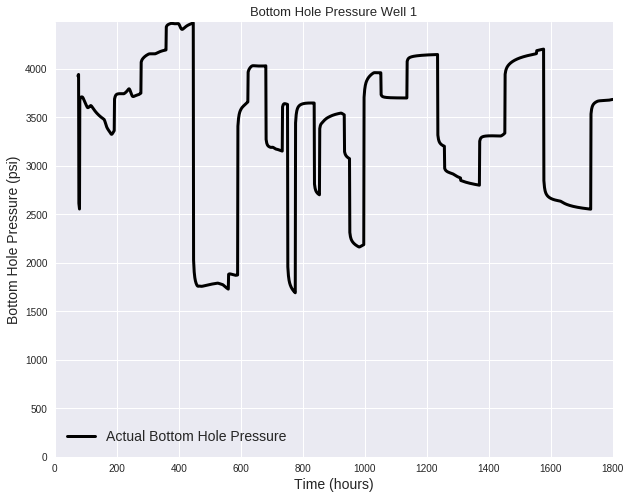

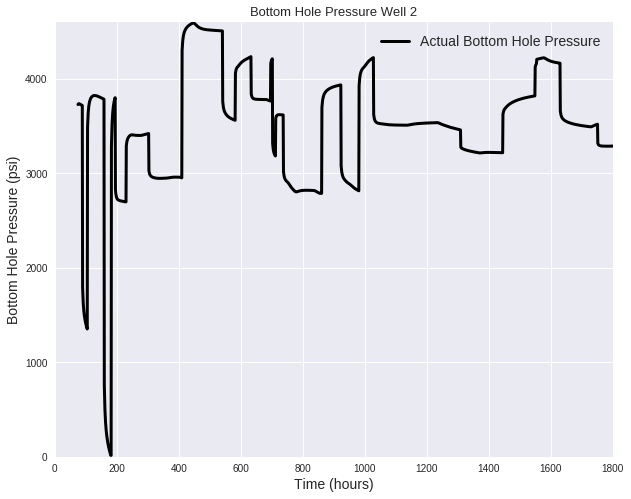

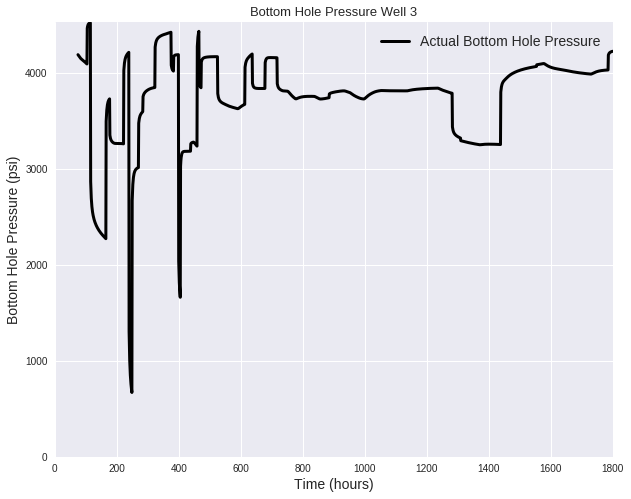

In [37]:
def plot_pressure_actual(t, q_actual, dev_fraction, test_fraction, well):
    """This function plots actual and predicted bottom hole pressure"""
    # Plotting pwf v time
    plt.figure()
    plt.plot(t, q_actual, 'k-', linewidth=3, label='Actual Bottom Hole Pressure')

    plt.xlabel("Time (hours)", fontsize=14)
    plt.ylabel("Bottom Hole Pressure (psi)", fontsize=14)
    plt.title("Bottom Hole Pressure Well "+str(well), y=1, fontsize=13)
    plt.legend(loc="best", prop=dict(size=14))
    plt.xlim(0, max(t))
    plt.ylim(0, max(q_actual) + 10)
    plt.grid(True)

for i in range(y_act.shape[1]):
    plot_pressure_actual(t[-len(y_act):].as_matrix(),
                   y_act[:, i], dev_fraction=dev_fraction, test_fraction=test_fraction, well=i+1)
    #plt.savefig('plot_LSTM_512_1024_lb25_well_' + str(i))

In [0]:
# Training

y_train_act = scaler_y.inverse_transform(y_train)

# Dev

y_dev_act = scaler_y.inverse_transform(y_dev)

# Test

y_test_act = scaler_y.inverse_transform(y_test)

# Train-Dev-Test
y_act = np.concatenate([y_train_act, y_dev_act, y_test_act])


In [0]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

print ('Files in Drive:')
!ls drive/

# Create a file in Drive.
!echo "This newly created file will appear in your Drive file list." > drive/created.txt

Files in Drive:
2016 NZ
20171219_082049.mp4
Achievements
Colab Notebooks
Consulting
CS230
C:\Users\E460\PycharmProjects\untitled3\Hackathon
Documents
IM
Intern_Full Time 2018
Misc
Peru 2017
Readings
Resume__Tita Ristanto.pdf
Resume__Tita Ristanto - Tita Ristanto.pdf
Selection
Sequoia Yosemite 2017
Stanford
SUN Energy
Trip
Untitled spreadsheet.ods
Untitled spreadsheet.ods (795d2dd5)


In [0]:
os.chdir('drive/Stanford')
os.getcwd()


'/content/drive/Stanford'